Library

In [2]:
import subprocess
import serial
import re
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kruskal

# no enkripsi

In [4]:
import os

# Folder output utama
code_folders = ["rfida", "rfidb", "rfidc", "rfidd", "rfide"]

# Buat folder utama jika belum ada
for folder in code_folders:
    os.makedirs(folder, exist_ok=True)

def generate_code_without_key(file_path, id_values):
    # Template kode Arduino tanpa enkripsi dan tanpa kunci
    code_template = f'''
#include <SPI.h>
#include <MFRC522.h>
#include <Wire.h>
#include <Adafruit_INA219.h>
#include <string.h>
#include <MemoryFree.h>
#include <LiquidCrystal_I2C.h>

#define SS_PIN 10
#define RST_PIN 9

MFRC522 rfid(SS_PIN, RST_PIN);
Adafruit_INA219 ina219;
LiquidCrystal_I2C lcd(0x27, 16, 2);

byte buffer[8];

float Voltage;
float Current;

void displayData() {{
    int memoryUsage = 2048 - freeMemory();

    Serial.print(F("Memory Usage = "));
    Serial.print(memoryUsage);
    Serial.println(F(" B"));

    float Power = Voltage * (Current / 1000);
    Serial.print(F("Voltage: "));
    Serial.print(Voltage);
    Serial.println(F(" V"));
    Serial.print(F("Current: "));
    Serial.print(Current);
    Serial.println(F(" mA"));
    Serial.print(F("Power: "));
    Serial.print(Power);
    Serial.println(F(" W"));
    
    Serial.println(F("selesai"));
}}

void setup() {{
    Serial.begin(9600);
    SPI.begin();
    rfid.PCD_Init();
    ina219.begin();
    
    lcd.begin(16, 2);
    lcd.backlight();
    lcd.setCursor(0, 0);
    lcd.print("RFID System Ready");
    delay(2000);
    lcd.clear();
}}

void loop() {{
    Voltage = ina219.getBusVoltage_V();
    Current = ina219.getCurrent_mA();
    if (rfid.PICC_IsNewCardPresent() && rfid.PICC_ReadCardSerial()) {{
        byte cardID[{id_values}] = {{0}};
        size_t idLength = rfid.uid.size;

        for (byte i = 0; i < idLength && i < {id_values}; i++) {{
            cardID[i] = rfid.uid.uidByte[i];
        }}

        if (idLength < {id_values}) {{
            memset(&cardID[idLength], 0, {id_values} - idLength);
        }}

        lcd.clear();
        lcd.setCursor(0, 0);
        lcd.print("RFID Detected!");
        lcd.setCursor(0, 1);
        lcd.print("Processing...");

        Serial.print(F("Padded Data: "));
        for (size_t i = 0; i < {id_values}; i++) {{
            if (cardID[i] < 0x10) Serial.print("0");
            Serial.print(cardID[i], HEX);
            Serial.print(" ");
        }}
        Serial.println();

        displayData();

        lcd.clear();
        lcd.setCursor(0, 0);
        lcd.print("Processing Done!");
        delay(2000);
        lcd.clear();
    }}
}}
'''

    with open(file_path, 'w') as file:
        file.write(code_template)

    print(f"Code without key for {id_values}-byte plaintext has been written to {file_path}")

# Generate folders and codes
for folder in code_folders:
    for i in range(352, 7, -8):
        filename = f"nocry_{i}"
        sketch_folder = os.path.join(folder, filename)
        os.makedirs(sketch_folder, exist_ok=True)  # Membuat folder untuk setiap file

        file_path = os.path.join(sketch_folder, f"{filename}.ino")

        generate_code_without_key(file_path, i)


Code without key for 352-byte plaintext has been written to rfida\nocry_352\nocry_352.ino
Code without key for 344-byte plaintext has been written to rfida\nocry_344\nocry_344.ino
Code without key for 336-byte plaintext has been written to rfida\nocry_336\nocry_336.ino
Code without key for 328-byte plaintext has been written to rfida\nocry_328\nocry_328.ino
Code without key for 320-byte plaintext has been written to rfida\nocry_320\nocry_320.ino
Code without key for 312-byte plaintext has been written to rfida\nocry_312\nocry_312.ino
Code without key for 304-byte plaintext has been written to rfida\nocry_304\nocry_304.ino
Code without key for 296-byte plaintext has been written to rfida\nocry_296\nocry_296.ino
Code without key for 288-byte plaintext has been written to rfida\nocry_288\nocry_288.ino
Code without key for 280-byte plaintext has been written to rfida\nocry_280\nocry_280.ino
Code without key for 272-byte plaintext has been written to rfida\nocry_272\nocry_272.ino
Code witho

running nocry

In [5]:
import os
import re
import subprocess
import time
import serial

# Configuration
port = "COM8"
baud_rate = 9600
base_folders = ["rfida", "rfidb", "rfidc", "rfidd", "rfide"]
log_folder = "logs_rfid_multi"
arduino_cli_path = r"C:\Program Files\Arduino IDE\resources\app\lib\backend\resources\arduino-cli.exe"

# Create log folder if it doesn't exist
os.makedirs(log_folder, exist_ok=True)

# Timeout duration in seconds for each phase
COMPILE_TIMEOUT = 60
UPLOAD_TIMEOUT = 30
SERIAL_TIMEOUT = 10

def parse_serial_data(serial_line):
    """
    Parse the serial data and return structured information.
    """
    if "Padded Data" in serial_line:
        match = re.search(r"Padded Data: (.+)", serial_line)
        return {"Padded Data": match.group(1)} if match else None
    elif "Memory Usage" in serial_line:
        match = re.search(r"Memory Usage = (\d+) B", serial_line)
        return {"Memory Usage (B)": int(match.group(1))} if match else None
    elif "Voltage" in serial_line:
        match = re.search(r"Voltage: ([\d.]+) V", serial_line)
        return {"Voltage (V)": float(match.group(1))} if match else None
    elif "Current" in serial_line:
        match = re.search(r"Current: ([\d.]+) mA", serial_line)
        return {"Current (mA)": float(match.group(1))} if match else None
    elif "Power" in serial_line:
        match = re.search(r"Power: ([\d.]+) W", serial_line)
        return {"Power (W)": float(match.group(1))} if match else None
    elif "selesai" in serial_line.lower():
        return {"Status": "Process Completed"}
    return {"Raw": serial_line.strip()}

def compile_and_upload(sketch_name, sketch_path):
    log_file = os.path.join(log_folder, f"{sketch_name}_output.txt")

    try:
        # Compile code to get storage information
        compile_command = [arduino_cli_path, "compile", "--fqbn", "arduino:avr:nano", sketch_path]
        result = subprocess.run(compile_command, capture_output=True, text=True, timeout=COMPILE_TIMEOUT)

        # Retrieve storage information from compilation output
        flash_match = re.search(r"Sketch uses (\d+) bytes.*Maximum is (\d+) bytes", result.stdout)
        ram_match = re.search(r"Global variables use (\d+) bytes.*Maximum is (\d+) bytes", result.stdout)
        flash_usage = f"{flash_match.group(1)} / {flash_match.group(2)} bytes" if flash_match else "Unknown"
        ram_usage = f"{ram_match.group(1)} / {ram_match.group(2)} bytes" if ram_match else "Unknown"

        print(f"{sketch_name} - Flash: {flash_usage}, RAM: {ram_usage}")

        # Log Flash and RAM info
        with open(log_file, "w", encoding="utf-8") as f:
            f.write(f"{sketch_name} - Flash: {flash_usage}, RAM: {ram_usage}\n\n")

        # Upload code to Arduino
        upload_command = [arduino_cli_path, "upload", "-p", port, "--fqbn", "arduino:avr:nano", sketch_path]
        subprocess.run(upload_command, timeout=UPLOAD_TIMEOUT)

        time.sleep(2)  # Wait after upload

    except subprocess.TimeoutExpired:
        print(f"Error: {sketch_name} - Compilation or upload timed out.")
    except Exception as e:
        print(f"Error: {sketch_name} - {e}")

    # Read from Serial Monitor and log to file
    try:
        with serial.Serial(port, baud_rate, timeout=1) as ser, open(log_file, "a", encoding="utf-8") as f:
            start_time = time.time()
            while time.time() - start_time < SERIAL_TIMEOUT:
                if ser.in_waiting > 0:
                    line = ser.readline().decode("utf-8", errors="ignore").strip()
                    parsed_line = parse_serial_data(line)
                    print(parsed_line)
                    f.write(str(parsed_line) + "\n")
                    if "Status" in parsed_line and parsed_line["Status"] == "Process Completed":
                        print(f"Detected completion for {sketch_name}.")
                        return
    except serial.SerialException as e:
        print(f"Serial Error: {sketch_name} - {e}")
    except Exception as e:
        print(f"Error while reading serial: {sketch_name} - {e}")

# Loop through each base folder
for base_folder in base_folders:
    subfolders = sorted(
        [folder for folder in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, folder))],
        key=lambda x: int(x.split('_')[1])  # Extract number after "_" and sort numerically
    )

    for folder_name in subfolders:
        sketch_path = os.path.join(base_folder, folder_name, f"{folder_name}.ino")
        if os.path.isfile(sketch_path):
            print(f"Running {folder_name} in {base_folder}...")
            compile_and_upload(f"{base_folder}_{folder_name}", sketch_path)
            print(f"Completed {folder_name} in {base_folder}\n")
        else:
            print(f"File {folder_name}.ino not found in {folder_name} within {base_folder}")

Running nocry_8 in rfida...
rfida_nocry_8 - Flash: 12732 / 30720 bytes, RAM: 577 / 2048 bytes
{'Padded Data': '6A 61 C5 AC 00 00 00 00'}
{'Memory Usage (B)': 616}
{'Voltage (V)': 4.19}
{'Current (mA)': 7.1}
{'Power (W)': 0.03}
{'Status': 'Process Completed'}
Detected completion for rfida_nocry_8.
Completed nocry_8 in rfida

Running nocry_16 in rfida...
rfida_nocry_16 - Flash: 12726 / 30720 bytes, RAM: 577 / 2048 bytes
{'Padded Data': '6A 61 C5 AC 00 00 00 00 00 00 00 00 00 00 00 00'}
{'Memory Usage (B)': 616}
{'Voltage (V)': 4.19}
{'Current (mA)': 6.9}
{'Power (W)': 0.03}
{'Status': 'Process Completed'}
Detected completion for rfida_nocry_16.
Completed nocry_16 in rfida

Running nocry_24 in rfida...
rfida_nocry_24 - Flash: 12726 / 30720 bytes, RAM: 577 / 2048 bytes
{'Padded Data': '6A 61 C5 AC 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00'}
{'Memory Usage (B)': 616}
{'Voltage (V)': 4.19}
{'Current (mA)': 6.9}
{'Power (W)': 0.03}
{'Status': 'Process Completed'}
Detected co

csv nocry

In [17]:
import ast
import pandas as pd
from glob import glob

# Konfigurasi
log_folder = "logs_rfid_multi"
output_csv = "rfid_data.csv"
outputnomean = "nomean_rfid_data.csv"

# Ukuran byte yang sesuai dengan file log
byte_sizes = [8, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256, 272, 288, 304, 320, 336, 352]

# List untuk menyimpan data mentah
data_list = []

# Memproses setiap file log berdasarkan ukuran byte
for byte_size in byte_sizes:
    files = glob(f"{log_folder}/*_{byte_size}_output*")
    if not files:
        print(f"No log files found for byte size: {byte_size}")
        continue

    print(f"Processing byte size: {byte_size}...")

    for file in files:
        try:
            # Inisialisasi nilai default
            flash_value = memory_usage = None
            voltage = current = power = None

            with open(file, 'r') as f:
                for line in f:
                    line = line.strip()

                    if "Flash:" in line:
                        try:
                            flash_value = int(line.split("Flash:")[1].split('/')[0].strip())
                        except Exception as e:
                            print(f"Error parsing Flash in line: {line} - {e}")

                    elif "Memory Usage (B)" in line:
                        try:
                            data = ast.literal_eval(line)
                            if "Memory Usage (B)" in data:
                                memory_usage = int(data["Memory Usage (B)"])
                        except Exception as e:
                            print(f"Error parsing Memory Usage in line: {line} - {e}")

                    elif "Voltage" in line or "Current" in line or "Power" in line:
                        try:
                            data = ast.literal_eval(line)
                            if "Voltage (V)" in data:
                                voltage = float(data["Voltage (V)"])
                            if "Current (mA)" in data:
                                current = float(data["Current (mA)"])
                            if "Power (W)" in data:
                                power = float(data["Power (W)"])
                        except Exception as e:
                            print(f"Error parsing Voltage/Current/Power in line: {line} - {e}")

            # Tambahkan data ke list
            data_list.append({
                "Byte Size": byte_size,
                "File Name": file,
                "Flash (bytes)": flash_value,
                "Memory Usage (bytes)": memory_usage,
                "Voltage (V)": voltage,
                "Current (mA)": current,
                "Power (W)": power
            })

        except Exception as e:
            print(f"Error reading file {file}: {e}")

# Simpan data mentah ke CSV meskipun data_list kosong
if data_list:
    df_raw = pd.DataFrame(data_list)
    df_raw.to_csv(outputnomean, index=False)
    print(f"Raw data saved to {outputnomean}")
else:
    print("No data found to save in outputnomean. Creating empty CSV.")
    pd.DataFrame(columns=[
        "Byte Size", "File Name", "Flash (bytes)", "Memory Usage (bytes)",
        "Voltage (V)", "Current (mA)", "Power (W)"
    ]).to_csv(outputnomean, index=False)

# Proses penghitungan rata-rata dari CSV raw
try:
    df_raw = pd.read_csv(outputnomean)

    if not df_raw.empty:
        # Pilih hanya kolom numerik untuk penghitungan rata-rata
        numerical_cols = df_raw.select_dtypes(include=['number']).columns

        # Hitung rata-rata berdasarkan Byte Size
        df_mean = df_raw.groupby("Byte Size", as_index=False)[numerical_cols].mean()

        # Simpan data rata-rata ke file CSV
        df_mean.to_csv(output_csv, index=False)

        print(f"Averaged data saved to {output_csv}")
        print(df_mean.head())
    else:
        print("Raw data file is empty. No data to calculate mean.")

except FileNotFoundError:
    print(f"File {outputnomean} not found. Please ensure it exists.")
except Exception as e:
    print(f"An error occurred: {e}")


Processing byte size: 8...
Processing byte size: 16...
Processing byte size: 32...
Processing byte size: 48...
Processing byte size: 64...
Processing byte size: 80...
Processing byte size: 96...
Processing byte size: 112...
Processing byte size: 128...
Processing byte size: 144...
Processing byte size: 160...
Processing byte size: 176...
Processing byte size: 192...
Processing byte size: 208...
Processing byte size: 224...
Processing byte size: 240...
Processing byte size: 256...
Processing byte size: 272...
Processing byte size: 288...
Processing byte size: 304...
Processing byte size: 320...
Processing byte size: 336...
Processing byte size: 352...
Raw data saved to nomean_rfid_data.csv
Averaged data saved to rfid_data.csv
   Byte Size  Flash (bytes)  Memory Usage (bytes)  Voltage (V)  Current (mA)  \
0        8.0        12732.0                 616.0        4.190          7.04   
1       16.0        12726.0                 616.0        4.192          7.04   
2       32.0        12726

output nocry

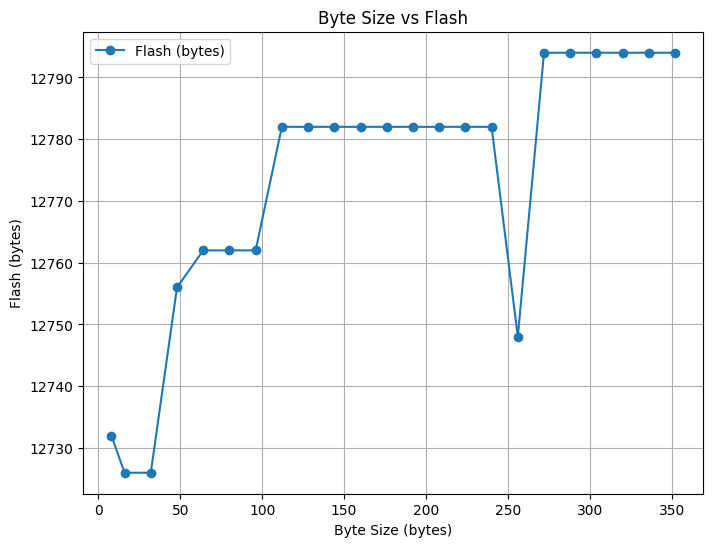

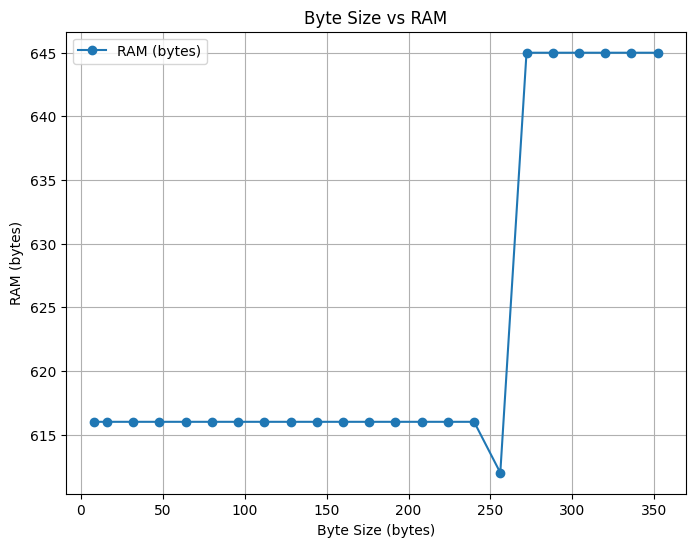

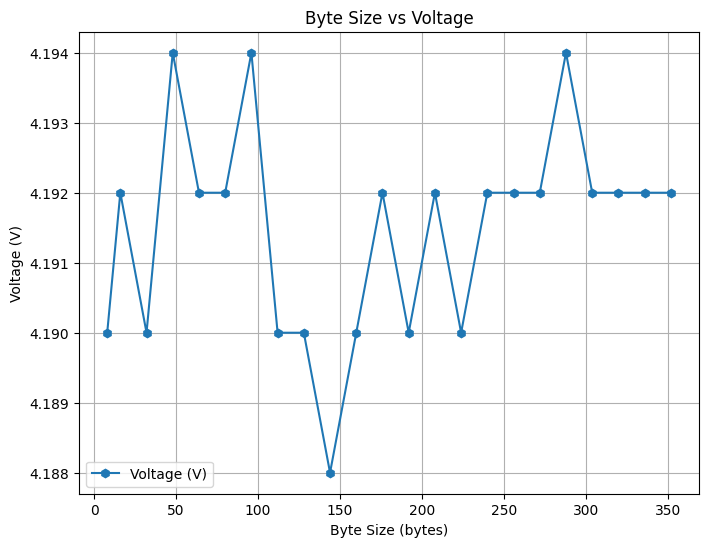

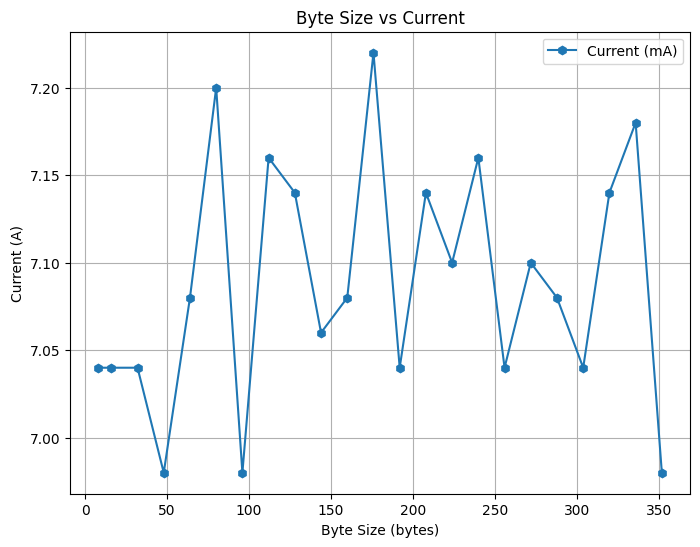

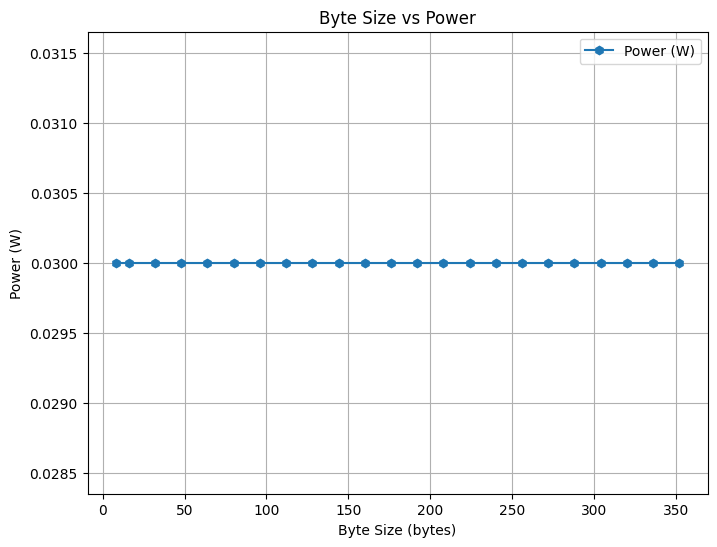

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Membaca data dari CSV (sesuaikan path jika diperlukan)
file_path = 'rfid_data.csv'
data = pd.read_csv(file_path)

# Grafik 4: Byte Size vs Flash
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Flash (bytes)'], marker='o', label='Flash (bytes)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Flash (bytes)')
plt.title('Byte Size vs Flash')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 5: Byte Size vs RAM
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Memory Usage (bytes)'], marker='o', label='RAM (bytes)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('RAM (bytes)')
plt.title('Byte Size vs RAM')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 9: Byte Size vs Encryption Voltage dan Decryption Voltage
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Voltage (V)'], marker='h', label='Voltage (V)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Voltage (V)')
plt.title('Byte Size vs Voltage')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 10: Byte Size vs Encryption Current dan Duplicate Current
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Current (mA)'], marker='h', label='Current (mA)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Current (A)')
plt.title('Byte Size vs Current')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 11: Byte Size vs Encryption Power dan Duplicate Power
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Power (W)'], marker='h', label='Power (W)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Power (W)')
plt.title('Byte Size vs Power')
plt.grid(True)
plt.legend()
plt.show()


kw nocry

rm2

In [7]:

# Load dataset
file_path = "nomean_rfid_data.xlsx"  # Replace with your file path
data = pd.read_excel(file_path)

# Display the structure of the dataset
print(data.head())

# Define columns for analysis
byte_sizes = data["Byte Size"].unique()  # Unique byte sizes

# Group data by byte size for Kruskal-Wallis analysis
grouped_flash_usages = [data[data["Byte Size"] == b]["Flash (bytes)"].dropna() for b in byte_sizes]
grouped_ram_usages = [data[data["Byte Size"] == b]["Memory Usage (bytes)"].dropna() for b in byte_sizes]
#powers = [data[data["Byte Size"] == b]["Power (W)"].dropna() for b in byte_sizes]

# Perform Kruskal-Wallis test for each metric
kw_flash_usage = kruskal(*grouped_flash_usages)
kw_ram_usage = kruskal(*grouped_ram_usages)
#kw_power = kruskal(*powers)

# Display results
print("Kruskal-Wallis Test Results:")
print(f"Flash Usage: H-statistic = {kw_flash_usage.statistic}, p-value = {kw_flash_usage.pvalue}")
print(f"RAM Usage: H-statistic = {kw_ram_usage.statistic}, p-value = {kw_ram_usage.pvalue}")
#print(f" Power: H-statistic = {kw_power.statistic}, p-value = {kw_power.pvalue}")

# Interpretation
if kw_flash_usage.pvalue < 0.05:
    print("Significant difference found in Flash Usage across byte sizes.")
else:
    print("No significant difference in Flash Usage across byte sizes.")

if kw_ram_usage.pvalue < 0.05:
    print("Significant difference found in RAM Usage across byte sizes.")
else:
    print("No significant difference in RAM Usage across byte sizes.")

# if kw_power.pvalue < 0.05:
#     print("Significant difference found in  Power across byte sizes.")
# else:
#     print("No significant difference in  Power across byte sizes.")


   Byte Size                                 File Name  Flash (bytes)  \
0          8  logs_rfid_multi\rfida_nocry_8_output.txt          12732   
1          8  logs_rfid_multi\rfidb_nocry_8_output.txt          12732   
2          8  logs_rfid_multi\rfidc_nocry_8_output.txt          12732   
3          8  logs_rfid_multi\rfidd_nocry_8_output.txt          12732   
4          8  logs_rfid_multi\rfide_nocry_8_output.txt          12732   

   Memory Usage (bytes)  Voltage (V)  Current (mA)  Power (W)  
0                   616         4.19           7.1       0.03  
1                   616         4.19           6.8       0.03  
2                   616         4.19           7.0       0.03  
3                   616         4.19           7.0       0.03  
4                   616         4.19           7.3       0.03  
Kruskal-Wallis Test Results:
Flash Usage: H-statistic = 113.99999999999997, p-value = 2.118891261201638e-14
RAM Usage: H-statistic = 113.99999999999996, p-value = 2.118891261201

rm3

   Byte Size                                 File Name  Flash (bytes)  \
0          8  logs_rfid_multi\rfida_nocry_8_output.txt          12732   
1          8  logs_rfid_multi\rfidb_nocry_8_output.txt          12732   
2          8  logs_rfid_multi\rfidc_nocry_8_output.txt          12732   
3          8  logs_rfid_multi\rfidd_nocry_8_output.txt          12732   
4          8  logs_rfid_multi\rfide_nocry_8_output.txt          12732   

   RAM (bytes)  Voltage (V)  Current (mA)  Power (W)  
0          616         4.19           7.1       0.03  
1          616         4.19           6.8       0.03  
2          616         4.19           7.0       0.03  
3          616         4.19           7.0       0.03  
4          616         4.19           7.3       0.03  
Kruskal-Wallis Test Results:
Flash: statistic=46.445, p-value=9.424e-12
RAM: statistic=57.230, p-value=3.877e-14
Voltage: statistic=1.541, p-value=2.145e-01
Current: statistic=0.261, p-value=6.096e-01


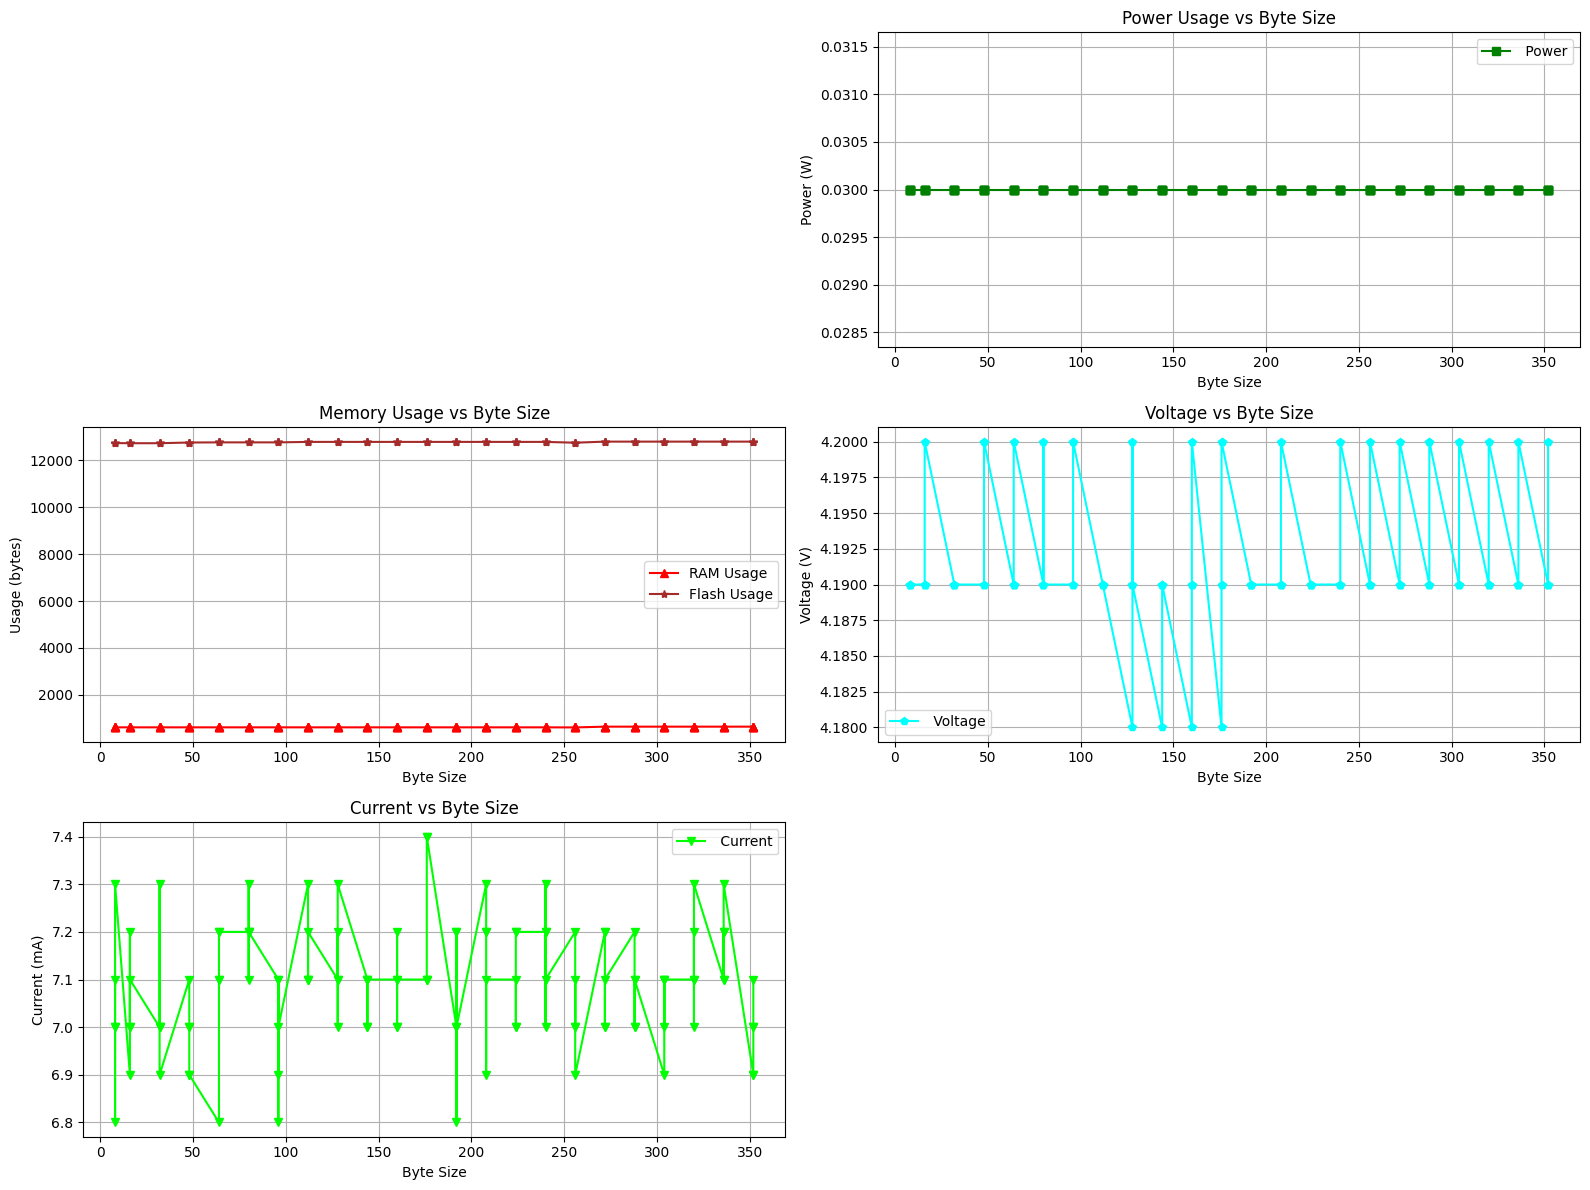

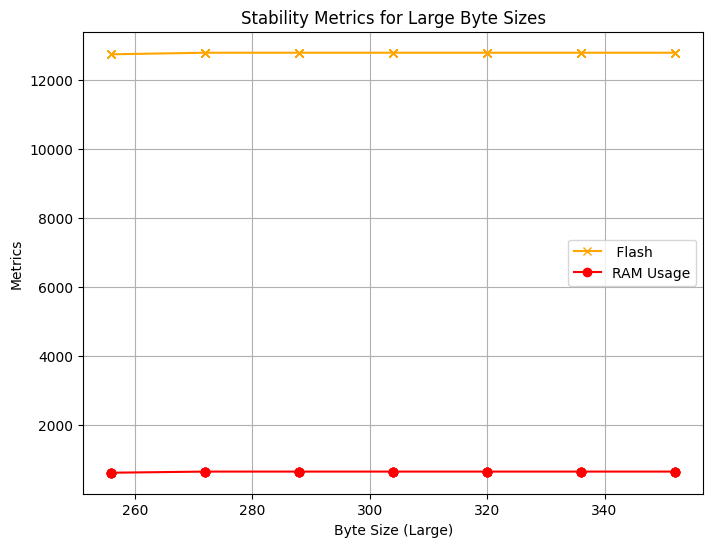

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kruskal

# Load the dataset
file_path = "nomean_rfid_data.xlsx"  # Replace with your file name
data = pd.read_excel(file_path)

# Display structure of dataset
print(data.head())

# Define columns
byte_sizes = data["Byte Size"]
flash_usages = data["Flash (bytes)"]
ram_usages = data["RAM (bytes)"]
voltages = data["Voltage (V)"]
currents = data["Current (mA)"]
# powers = data["Power (W)"]

# Define groups for Kruskal-Wallis based on byte size thresholds
threshold = byte_sizes.max() * 0.7  # Define "large" as the top 30% of byte sizes
group_large = data[data["Byte Size"] >= threshold]
group_small = data[data["Byte Size"] < threshold]

# Perform Kruskal-Wallis test for each performance metric
kruskal_results = {
    "Flash": kruskal(group_large["Flash (bytes)"], group_small["Flash (bytes)"]),
    "RAM": kruskal(group_large["RAM (bytes)"], group_small["RAM (bytes)"]),
    "Voltage": kruskal(group_large["Voltage (V)"], group_small["Voltage (V)"]),
    "Current": kruskal(group_large["Current (mA)"], group_small["Current (mA)"]),
    # "Power": kruskal(group_large["Power (W)"], group_small["Power (W)"]),
}

print("Kruskal-Wallis Test Results:")
for metric, result in kruskal_results.items():
    print(f"{metric}: statistic={result.statistic:.3f}, p-value={result.pvalue:.3e}")

# Plot trends to visualize performance
plt.figure(figsize=(16, 12))


# Power Usage vs Byte Size
plt.subplot(3, 2, 2)
plt.plot(byte_sizes, powers, marker='s', color='g', label=" Power")
plt.title("Power Usage vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Power (W)")
plt.legend()
plt.grid(True)

# Memory Usage vs Byte Size
plt.subplot(3, 2, 3)
plt.plot(byte_sizes, ram_usages, marker='^', color='r', label="RAM Usage")
plt.plot(byte_sizes, flash_usages, marker='*', color='brown', label="Flash Usage")
plt.title("Memory Usage vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Usage (bytes)")
plt.legend()
plt.grid(True)

# Voltage vs Byte Size
plt.subplot(3, 2, 4)
plt.plot(byte_sizes, voltages, marker='p', color='cyan', label=" Voltage")
plt.title("Voltage vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Voltage (V)")
plt.legend()
plt.grid(True)

# Current vs Byte Size
plt.subplot(3, 2, 5)
plt.plot(byte_sizes, currents, marker='v', color='lime', label=" Current")
plt.title("Current vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Current (mA)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Stability Check for Large Data
plt.figure(figsize=(8, 6))
plt.plot(group_large["Byte Size"], group_large["Flash (bytes)"], marker='x', linestyle='-', color='orange', label=" Flash")
# plt.plot(group_large["Byte Size"], group_large[" Power (W)"], marker='d', linestyle='--', color='purple', label=" Power")
plt.plot(group_large["Byte Size"], group_large["RAM (bytes)"], marker='o', linestyle='-', color='red', label="RAM Usage")
plt.title("Stability Metrics for Large Byte Sizes")
plt.xlabel("Byte Size (Large)")
plt.ylabel("Metrics")
plt.grid(True)
plt.legend()
plt.show()


# SKINNY128

Generate SKINNY128

In [ ]:
import os

# Folder output utama
code_folders = ["skinny128rfida", "skinny128rfidb", "skinny128rfidc", "skinny128rfidd", "skinny128rfide"]

# Buat folder utama jika belum ada
for folder in code_folders:
    os.makedirs(folder, exist_ok=True)

def generate_code_with_decrementing_plaintext(file_path, id_values):
    # Template kode Arduino
    code_template = f'''
#include <SPI.h>
#include <MFRC522.h>
#include <Wire.h>
#include <Adafruit_INA219.h>
#include "Skinny128.h"
#include <string.h>
#include <MemoryFree.h>
#include <LiquidCrystal_I2C.h> 

#define SS_PIN 10
#define RST_PIN 9

MFRC522 rfid(SS_PIN, RST_PIN);
Adafruit_INA219 ina219;
LiquidCrystal_I2C lcd(0x27, 16, 2);

Skinny128_128 skinny128;
byte ciphertext[{id_values}];
byte decryptedtext[{id_values}];
unsigned long encryptionTime;
unsigned long decryptionTime;

byte buffer[16];

float encryptionVoltage;
float encryptionCurrent;
float decryptionVoltage;
float decryptionCurrent;

const byte key[16] = {{ 0x0f, 0x0e, 0x0d, 0x0c, 0x0b, 0x0a, 0x09, 0x08,
                         0x07, 0x06, 0x05, 0x04, 0x03, 0x02, 0x01, 0x00 }};

void encryptAndMeasure(BlockCipher *cipher, const byte *key, size_t keySize, byte *plaintext, size_t plaintextSize) {{
  unsigned long startTime = micros();
  cipher->setKey(key, keySize);

  for (size_t i = 0; i < plaintextSize; i += 16) {{
    cipher->encryptBlock(buffer, &plaintext[i]);
    memcpy(&ciphertext[i], buffer, 16);
  }}

  unsigned long endTime = micros();
  encryptionVoltage = ina219.getBusVoltage_V();
  encryptionCurrent = ina219.getCurrent_mA();
  encryptionTime = endTime - startTime;

  // Output encrypted data (ciphertext)
  Serial.print(F("Ciphertext: "));
  for (size_t i = 0; i < plaintextSize; i++) {{
    if (ciphertext[i] < 0x10) Serial.print("0");
    Serial.print(ciphertext[i], HEX);
    Serial.print(" ");
  }}
  Serial.println();
  Serial.print(F("Encryption Completed in "));
  Serial.print(encryptionTime);
  Serial.println(F(" microseconds"));
}}

void decryptAndMeasure(BlockCipher *cipher, const byte *key, size_t keySize, byte *ciphertext, size_t ciphertextSize) {{
    unsigned long startdecTime = micros();
    cipher->setKey(key, keySize);

    for (size_t i = 0; i < ciphertextSize; i += 16) {{
        cipher->decryptBlock(buffer, &ciphertext[i]);
        memcpy(&decryptedtext[i], buffer, 16);
    }}

    unsigned long enddecTime = micros();
    decryptionVoltage = ina219.getBusVoltage_V();
    decryptionCurrent = ina219.getCurrent_mA();
    decryptionTime = enddecTime - startdecTime;

    // Output decrypted data
    Serial.print(F("Decrypted Text: "));
    for (size_t i = 0; i < ciphertextSize; i++) {{
        if (decryptedtext[i] < 0x10) Serial.print("0");
        Serial.print(decryptedtext[i], HEX);
        Serial.print(" ");
    }}
    Serial.println();
    Serial.print(F("Decryption Completed in "));
    Serial.print(decryptionTime);
    Serial.println(F(" microseconds"));
}}

void displayData() {{
    float encryptionPower = encryptionVoltage * (encryptionCurrent / 1000);
    float decryptionPower = decryptionVoltage * (decryptionCurrent / 1000);
    int memoryUsage = 2048 - freeMemory();

    Serial.print(F("Memory Usage = "));
    Serial.print(memoryUsage);
    Serial.println(F(" B"));

    Serial.print(F("Encryption Voltage: "));
    Serial.print(encryptionVoltage);
    Serial.println(F(" V"));
    Serial.print(F("Encryption Current: "));
    Serial.print(encryptionCurrent);
    Serial.println(F(" mA"));
    Serial.print(F("Encryption Power: "));
    Serial.print(encryptionPower);
    Serial.println(F(" W"));
    
    Serial.print(F("Decryption Voltage: "));
    Serial.print(decryptionVoltage);
    Serial.println(F(" V"));
    Serial.print(F("Decryption Current: "));
    Serial.print(decryptionCurrent);
    Serial.println(F(" mA"));
    Serial.print(F("Decryption Power: "));
    Serial.print(decryptionPower);
    Serial.println(F(" W"));

    Serial.println(F("selesai"));
}}

void setup() {{
    Serial.begin(9600);
    SPI.begin();
    rfid.PCD_Init();
    ina219.begin();
    
    lcd.begin(16, 2);
    lcd.backlight();
    lcd.setCursor(0, 0);
    lcd.print("RFID System Ready");
    delay(2000);
    lcd.clear();
}}

void loop() {{
    if (rfid.PICC_IsNewCardPresent() && rfid.PICC_ReadCardSerial()) {{
        byte cardID[{id_values}] = {{0}};
        size_t idLength = rfid.uid.size;

        for (byte i = 0; i < idLength && i < {id_values}; i++) {{
            cardID[i] = rfid.uid.uidByte[i];
        }}

        if (idLength < {id_values}) {{
            memset(&cardID[idLength], 0, {id_values} - idLength);
        }}

        lcd.clear();
        lcd.setCursor(0, 0);
        lcd.print("RFID Detected!");
        lcd.setCursor(0, 1);
        lcd.print("Encrypting...");

        encryptAndMeasure(&skinny128, key, sizeof(key), cardID, {id_values});
        decryptAndMeasure(&skinny128, key, sizeof(key), ciphertext, {id_values});
        displayData();

        lcd.clear();
        lcd.setCursor(0, 0);
        lcd.print("Encryption Done!");
        delay(2000);
        lcd.clear();
    }}
}}
'''

    with open(file_path, 'w') as file:
        file.write(code_template)

    print(f"Code with {id_values}-byte plaintext has been written to {file_path}")

# Generate folders and codes
for folder in code_folders:
    for i in range(352, 15, -16):
        filename = f"skinny128_{i}"
        sketch_folder = os.path.join(folder, filename)
        os.makedirs(sketch_folder, exist_ok=True)  # Membuat folder untuk setiap file

        file_path = os.path.join(sketch_folder, f"{filename}.ino")

        generate_code_with_decrementing_plaintext(file_path, i)


Running SKINNY128

In [ ]:
# Configuration
port = "COM8"
baud_rate = 9600
base_folders = ["skinny128rfida", "skinny128rfidb", "skinny128rfidc", "skinny128rfidd", "skinny128rfide"]
log_folder = "logs_skinny128_multi"
arduino_cli_path = r"C:\Program Files\Arduino IDE\resources\app\lib\backend\resources\arduino-cli.exe"

# Create log folder if it doesn't exist
os.makedirs(log_folder, exist_ok=True)

# Timeout duration in seconds for each phase
COMPILE_TIMEOUT = 60
UPLOAD_TIMEOUT = 30
SERIAL_TIMEOUT = 10


def parse_serial_data(serial_line):
    """
    Parse the serial data and return structured information.
    """
    if "Ciphertext" in serial_line:
        match = re.search(r"Ciphertext: (.+)", serial_line)
        return {"Ciphertext": match.group(1)} if match else None
    elif "Encryption Completed" in serial_line:
        match = re.search(r"Encryption Completed in (\d+) microseconds", serial_line)
        return {"Encryption Time": int(match.group(1))} if match else None
    elif "Decrypted Text" in serial_line:
        match = re.search(r"Decrypted Text: (.+)", serial_line)
        return {"Decrypted Text": match.group(1)} if match else None
    elif "Decryption Completed" in serial_line:
        match = re.search(r"Decryption Completed in (\d+) microseconds", serial_line)
        return {"Decryption Time": int(match.group(1))} if match else None
    elif "Memory Usage" in serial_line:
        match = re.search(r"Memory Usage = (\d+) B", serial_line)
        return {"Memory Usage (B)": int(match.group(1))} if match else None
    elif "Encryption Voltage" in serial_line:
        match = re.search(r"Encryption Voltage: ([\d.]+) V", serial_line)
        return {"Encryption Voltage (V)": float(match.group(1))} if match else None
    elif "Encryption Current" in serial_line:
        match = re.search(r"Encryption Current: ([\d.]+) mA", serial_line)
        return {"Encryption Current (mA)": float(match.group(1))} if match else None
    elif "Encryption Power" in serial_line:
        match = re.search(r"Encryption Power: ([\d.]+) W", serial_line)
        return {"Encryption Power (W)": float(match.group(1))} if match else None
    elif "Decryption Voltage" in serial_line:
        match = re.search(r"Decryption Voltage: ([\d.]+) V", serial_line)
        return {"Decryption Voltage (V)": float(match.group(1))} if match else None
    elif "Decryption Current" in serial_line:
        match = re.search(r"Decryption Current: ([\d.]+) mA", serial_line)
        return {"Decryption Current (mA)": float(match.group(1))} if match else None
    elif "Decryption Power" in serial_line:
        match = re.search(r"Decryption Power: ([\d.]+) W", serial_line)
        return {"Decryption Power (W)": float(match.group(1))} if match else None
    elif "selesai" in serial_line.lower():
        return {"Status": "Process Completed"}
    return {"Raw": serial_line.strip()}


def compile_and_upload(sketch_name, sketch_path):
    log_file = os.path.join(log_folder, f"{sketch_name}_output.txt")
    
    try:
        # Compile code to get storage information
        compile_command = [arduino_cli_path, "compile", "--fqbn", "arduino:avr:nano", sketch_path]
        result = subprocess.run(compile_command, capture_output=True, text=True, timeout=COMPILE_TIMEOUT)
        
        # Retrieve storage information from compilation output
        flash_match = re.search(r"Sketch uses (\d+) bytes.*Maximum is (\d+) bytes", result.stdout)
        ram_match = re.search(r"Global variables use (\d+) bytes.*Maximum is (\d+) bytes", result.stdout)
        flash_usage = f"{flash_match.group(1)} / {flash_match.group(2)} bytes" if flash_match else "Unknown"
        ram_usage = f"{ram_match.group(1)} / {ram_match.group(2)} bytes" if ram_match else "Unknown"

        print(f"{sketch_name} - Flash: {flash_usage}, RAM: {ram_usage}")

        # Log Flash and RAM info
        with open(log_file, "w", encoding="utf-8") as f:
            f.write(f"{sketch_name} - Flash: {flash_usage}, RAM: {ram_usage}\n\n")

        # Upload code to Arduino
        upload_command = [arduino_cli_path, "upload", "-p", port, "--fqbn", "arduino:avr:nano", sketch_path]
        subprocess.run(upload_command, timeout=UPLOAD_TIMEOUT)

        time.sleep(2)  # Wait after upload

    except subprocess.TimeoutExpired:
        print(f"Error: {sketch_name} - Compilation or upload timed out.")
    except Exception as e:
        print(f"Error: {sketch_name} - {e}")

    # Read from Serial Monitor and log to file
    try:
        with serial.Serial(port, baud_rate, timeout=1) as ser, open(log_file, "a", encoding="utf-8") as f:
            start_time = time.time()
            while time.time() - start_time < SERIAL_TIMEOUT:
                if ser.in_waiting > 0:
                    line = ser.readline().decode("utf-8", errors="ignore").strip()
                    parsed_line = parse_serial_data(line)
                    print(parsed_line)
                    f.write(str(parsed_line) + "\n")
                    if "Status" in parsed_line and parsed_line["Status"] == "Process Completed":
                        print(f"Detected completion for {sketch_name}.")
                        return
    except serial.SerialException as e:
        print(f"Serial Error: {sketch_name} - {e}")
    except Exception as e:
        print(f"Error while reading serial: {sketch_name} - {e}")


# Loop through each base folder
for base_folder in base_folders:
    subfolders = sorted(
        [folder for folder in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, folder))],
        key=lambda x: int(x.split('_')[1])  # Extract number after "128_" and sort numerically
    )

    for folder_name in subfolders:
        sketch_path = os.path.join(base_folder, folder_name, f"{folder_name}.ino")
        if os.path.isfile(sketch_path):
            print(f"Running {folder_name} in {base_folder}...")
            compile_and_upload(f"{base_folder}_{folder_name}", sketch_path)
            print(f"Completed {folder_name} in {base_folder}\n")
        else:
            print(f"File {folder_name}.ino not found in {folder_name} within {base_folder}")


CSV SKINNY128

In [4]:
import ast  # Import untuk evaluasi literal
import pandas as pd
from glob import glob

# Konfigurasi
log_folder = "logs_skinny128_multi"
output_csv = "nomean_skinny128_data.csv"

# Ukuran byte yang sesuai dengan file log
data_list = []

for byte_size in byte_sizes:
    files = glob(f"{log_folder}/*_{byte_size}_output*")
    if not files:
        print(f"No log files found for byte size: {byte_size}")
        continue

    print(f"Processing byte size: {byte_size}...")

    for file in files:
        try:
            flash_value = ram_value = encryption_time = decryption_time = None
            encryption_voltage = encryption_current = encryption_power = None
            decryption_voltage = decryption_current = decryption_power = None

            with open(file, 'r') as f:
                for line in f:
                    line = line.strip()

                    if "Flash:" in line:
                        try:
                            flash_value = int(line.split("Flash:")[1].split('/')[0].strip())
                        except Exception as e:
                            print(f"Error parsing Flash in line: {line} - {e}")

                    elif "'Encryption Time" in line:
                        try:
                            data = ast.literal_eval(line)
                            if "Encryption Time" in data:
                                encryption_time = int(data["Encryption Time"])
                        except Exception as e:
                            print(f"Error parsing Encryption Time in line: {line} - {e}")

                    elif "'Decryption Time':" in line:
                        try:
                            data = ast.literal_eval(line)
                            if "Decryption Time" in data:
                                decryption_time = int(data["Decryption Time"])
                        except Exception as e:
                            print(f"Error parsing Decryption Time in line: {line} - {e}")

                    elif "Memory Usage:" in line or "Memory Usage (B)" in line:
                        try:
                            data = ast.literal_eval(line)
                            if "Memory Usage (B)" in data:
                                ram_value = int(data["Memory Usage (B)"])
                        except Exception as e:
                            print(f"Error parsing RAM in line: {line} - {e}")

                    elif "Voltage" in line or "Current" in line or "Power" in line:
                        try:
                            data = ast.literal_eval(line)
                            if "Encryption Voltage (V)" in data:
                                encryption_voltage = float(data["Encryption Voltage (V)"])
                            if "Encryption Current (mA)" in data:
                                encryption_current = float(data["Encryption Current (mA)"])
                            if "Encryption Power (W)" in data:
                                encryption_power = float(data["Encryption Power (W)"])
                            if "Decryption Voltage (V)" in data:
                                decryption_voltage = float(data["Decryption Voltage (V)"])
                            if "Decryption Current (mA)" in data:
                                decryption_current = float(data["Decryption Current (mA)"])
                            if "Decryption Power (W)" in data:
                                decryption_power = float(data["Decryption Power (W)"])
                        except Exception as e:
                            print(f"Error parsing Voltage/Current/Power in line: {line} - {e}")

            # Tambahkan data ke list
            data_list.append({
                "Byte Size": byte_size,
                "File Name": file,
                "Flash (bytes)": flash_value,
                "RAM (bytes)": ram_value,
                "Encryption Time (µs)": encryption_time,
                "Decryption Time (µs)": decryption_time,
                "Encryption Voltage (V)": encryption_voltage,
                "Encryption Current (mA)": encryption_current,
                "Encryption Power (W)": encryption_power,
                "Decryption Voltage (V)": decryption_voltage,
                "Decryption Current (mA)": decryption_current,
                "Decryption Power (W)": decryption_power,
            })

        except Exception as e:
            print(f"Error reading file {file}: {e}")

# Simpan data ke CSV
df = pd.DataFrame(data_list)
df.to_csv(output_csv, index=False)

# Tampilkan beberapa data
print(df.head())



Processing byte size: 16...
Processing byte size: 32...
Processing byte size: 48...
Processing byte size: 64...
Processing byte size: 80...
Processing byte size: 96...
Processing byte size: 112...
Processing byte size: 128...
Processing byte size: 144...
Processing byte size: 160...
Processing byte size: 176...
Processing byte size: 192...
Processing byte size: 208...
Processing byte size: 224...
Processing byte size: 240...
Processing byte size: 256...
Processing byte size: 272...
Processing byte size: 288...
Processing byte size: 304...
Processing byte size: 320...
Processing byte size: 336...
Processing byte size: 352...
   Byte Size                                          File Name  \
0         16  logs_skinny128_multi\skinny128rfida_skinny128_...   
1         16  logs_skinny128_multi\skinny128rfidb_skinny128_...   
2         16  logs_skinny128_multi\skinny128rfidc_skinny128_...   
3         16  logs_skinny128_multi\skinny128rfidd_skinny128_...   
4         16  logs_skinny128_mult

Output SKINNY128

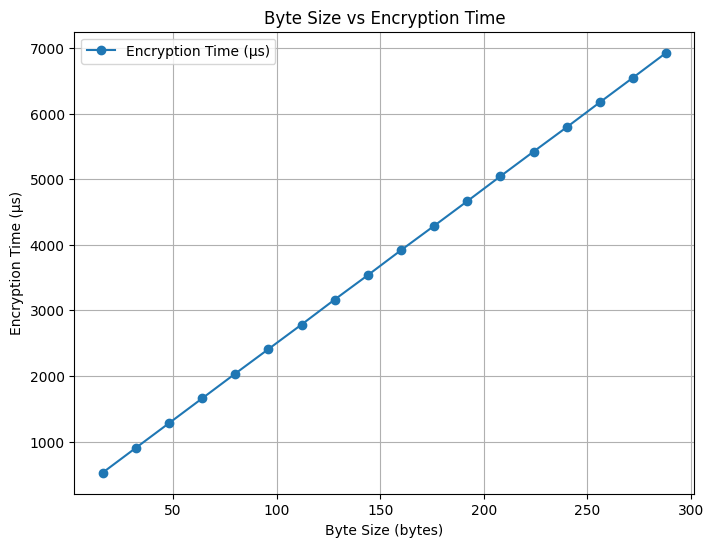

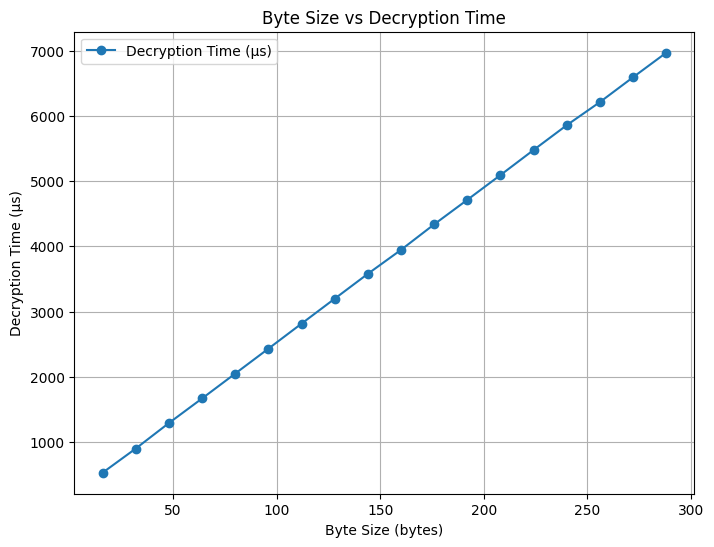

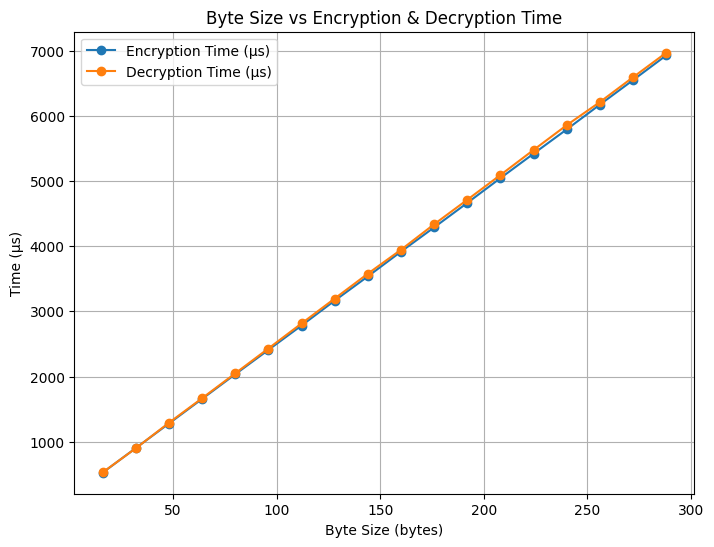

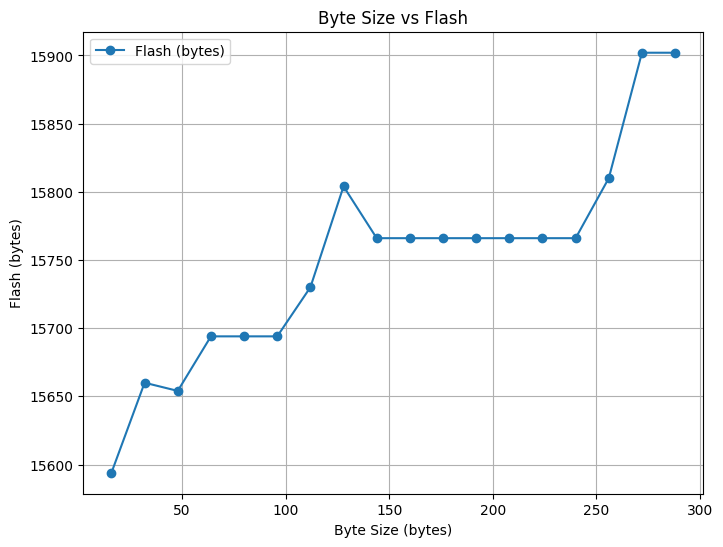

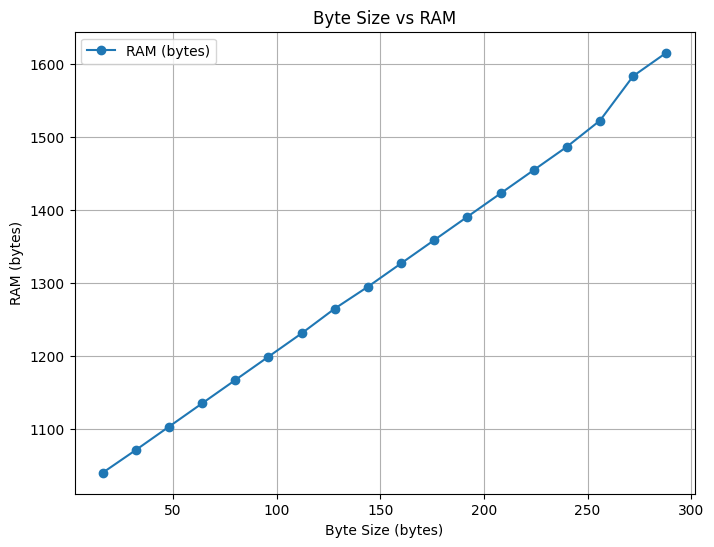

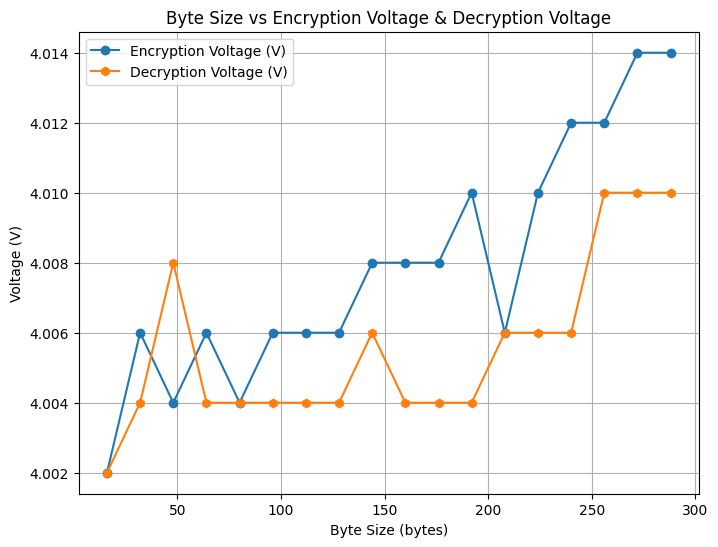

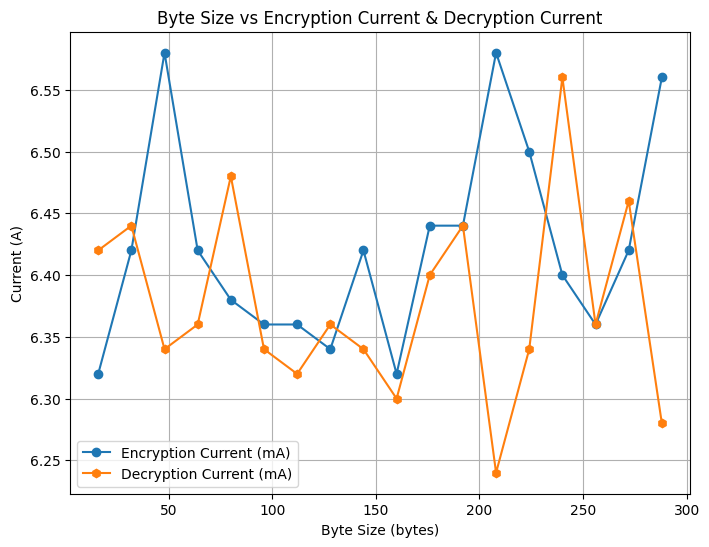

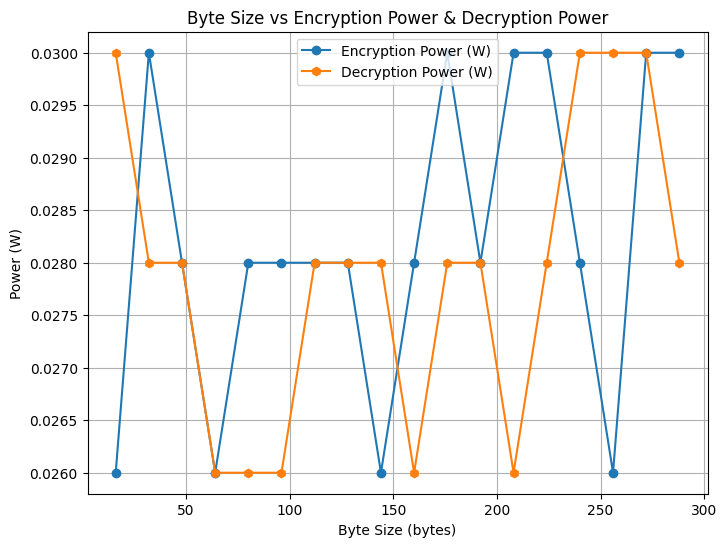

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Membaca data dari CSV (sesuaikan path jika diperlukan)
file_path = 'processed_skinny128_data.csv'
data = pd.read_csv(file_path)

# Grafik 1: Byte Size vs Encryption Time
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Encryption Time (µs)'], marker='o', label='Encryption Time (µs)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Encryption Time (µs)')
plt.title('Byte Size vs Encryption Time')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 2: Byte Size vs Decryption Time
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Decryption Time (µs)'], marker='o', label='Decryption Time (µs)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Decryption Time (µs)')
plt.title('Byte Size vs Decryption Time')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 3: Byte Size vs Encryption & Decryption Time
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Encryption Time (µs)'], marker='o', label='Encryption Time (µs)')
plt.plot(data['Byte Size'], data['Avg Decryption Time (µs)'], marker='o', label='Decryption Time (µs)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Time (µs)')
plt.title('Byte Size vs Encryption & Decryption Time')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 4: Byte Size vs Flash
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Flash (bytes)'], marker='o', label='Flash (bytes)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Flash (bytes)')
plt.title('Byte Size vs Flash')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 5: Byte Size vs RAM
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg RAM (bytes)'], marker='o', label='RAM (bytes)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('RAM (bytes)')
plt.title('Byte Size vs RAM')
plt.grid(True)
plt.legend()
plt.show()

# # Grafik 6: Byte Size vs Encryption Voltage
# plt.figure(figsize=(8, 6))
# plt.plot(data['Byte Size'], data['Avg Encryption Voltage (V)'], marker='o', label='Encryption Voltage (V)')
# plt.xlabel('Byte Size (bytes)')
# plt.ylabel('Voltage (V)')
# plt.title('Byte Size vs Encryption Voltage')
# plt.grid(True)
# plt.legend()
# plt.show()

# # Grafik 7: Byte Size vs Encryption Current
# plt.figure(figsize=(8, 6))
# plt.plot(data['Byte Size'], data['Avg Encryption Current (A)'], marker='o', label='Encryption Current (A)')
# plt.xlabel('Byte Size (bytes)')
# plt.ylabel('Current (A)')
# plt.title('Byte Size vs Encryption Current')
# plt.grid(True)
# plt.legend()
# plt.show()

# # Grafik 8: Byte Size vs Encryption Power
# plt.figure(figsize=(8, 6))
# plt.plot(data['Byte Size'], data['Avg Encryption Power (W)'], marker='o', label='Encryption Power (W)')
# plt.xlabel('Byte Size (bytes)')
# plt.ylabel('Power (W)')
# plt.title('Byte Size vs Encryption Power')
# plt.grid(True)
# plt.legend()
# plt.show()

# Grafik 9: Byte Size vs Encryption Voltage dan Decryption Voltage
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Encryption Voltage (V)'], marker='o', label='Encryption Voltage (V)')
plt.plot(data['Byte Size'], data['Avg Decryption Voltage (V)'], marker='h', label='Decryption Voltage (V)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Voltage (V)')
plt.title('Byte Size vs Encryption Voltage & Decryption Voltage')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 10: Byte Size vs Encryption Current dan Duplicate Current
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Encryption Current (mA)'], marker='o', label='Encryption Current (mA)')
plt.plot(data['Byte Size'], data['Avg Decryption Current (mA)'], marker='h', label='Decryption Current (mA)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Current (A)')
plt.title('Byte Size vs Encryption Current & Decryption Current')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 11: Byte Size vs Encryption Power dan Duplicate Power
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Encryption Power (W)'], marker='o', label='Encryption Power (W)')
plt.plot(data['Byte Size'], data['Avg Decryption Power (W)'], marker='h', label='Decryption Power (W)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Power (W)')
plt.title('Byte Size vs Encryption Power & Decryption Power')
plt.grid(True)
plt.legend()
plt.show()


Krukal Wallis SKINNY128

Rumusan masalah 2

In [7]:

# Load dataset
file_path = "nomean_skinny128_data.xlsx"  # Replace with your file path
data = pd.read_excel(file_path)

# Display the structure of the dataset
print(data.head())

# Define columns for analysis
byte_sizes = data["Byte Size"].unique()  # Unique byte sizes

# Group data by byte size for Kruskal-Wallis analysis
grouped_flash_usages = [data[data["Byte Size"] == b]["Flash (bytes)"].dropna() for b in byte_sizes]
grouped_ram_usages = [data[data["Byte Size"] == b]["RAM (bytes)"].dropna() for b in byte_sizes]
grouped_encryption_times = [data[data["Byte Size"] == b]["Encryption Time (µs)"].dropna() for b in byte_sizes]
grouped_decryption_times = [data[data["Byte Size"] == b]["Decryption Time (µs)"].dropna() for b in byte_sizes]
grouped_encryption_powers = [data[data["Byte Size"] == b]["Encryption Power (W)"].dropna() for b in byte_sizes]
grouped_decryption_powers = [data[data["Byte Size"] == b]["Decryption Power (W)"].dropna() for b in byte_sizes]

# Perform Kruskal-Wallis test for each metric
kw_flash_usage = kruskal(*grouped_flash_usages)
kw_ram_usage = kruskal(*grouped_ram_usages)
kw_encryption_time = kruskal(*grouped_encryption_times)
kw_decryption_time = kruskal(*grouped_decryption_times)
kw_encryption_power = kruskal(*grouped_encryption_powers)
kw_decryption_power = kruskal(*grouped_decryption_powers)

# Display results
print("Kruskal-Wallis Test Results:")
print(f"Flash Usage: H-statistic = {kw_flash_usage.statistic}, p-value = {kw_flash_usage.pvalue}")
print(f"RAM Usage: H-statistic = {kw_ram_usage.statistic}, p-value = {kw_ram_usage.pvalue}")
print(f"Encryption Time: H-statistic = {kw_encryption_time.statistic}, p-value = {kw_encryption_time.pvalue}")
print(f"Decryption Time: H-statistic = {kw_decryption_time.statistic}, p-value = {kw_decryption_time.pvalue}")
print(f"Encryption Power: H-statistic = {kw_encryption_power.statistic}, p-value = {kw_encryption_power.pvalue}")
print(f"Decryption Power: H-statistic = {kw_decryption_power.statistic}, p-value = {kw_decryption_power.pvalue}")

# Interpretation
if kw_flash_usage.pvalue < 0.05:
    print("Significant difference found in Flash Usage across byte sizes.")
else:
    print("No significant difference in Flash Usage across byte sizes.")

if kw_ram_usage.pvalue < 0.05:
    print("Significant difference found in RAM Usage across byte sizes.")
else:
    print("No significant difference in RAM Usage across byte sizes.")

if kw_encryption_time.pvalue < 0.05:
    print("Significant difference found in Encryption Time across byte sizes.")
else:
    print("No significant difference in Encryption Time across byte sizes.")

if kw_decryption_time.pvalue < 0.05:
    print("Significant difference found in Decryption Time across byte sizes.")
else:
    print("No significant difference in Decryption Time across byte sizes.")

if kw_encryption_power.pvalue < 0.05:
    print("Significant difference found in Encryption Power across byte sizes.")
else:
    print("No significant difference in Encryption Power across byte sizes.")

if kw_decryption_power.pvalue < 0.05:
    print("Significant difference found in Decryption Power across byte sizes.")
else:
    print("No significant difference in Decryption Power across byte sizes.")


   Byte Size                                          File Name  \
0         16  logs_skinny128_multi\skinny128rfida_skinny128_...   
1         16  logs_skinny128_multi\skinny128rfidb_skinny128_...   
2         16  logs_skinny128_multi\skinny128rfidc_skinny128_...   
3         16  logs_skinny128_multi\skinny128rfidd_skinny128_...   
4         16  logs_skinny128_multi\skinny128rfide_skinny128_...   

   Flash (bytes)  RAM (bytes)  Encryption Time (µs)  Decryption Time (µs)  \
0          15618         1043                   524                   524   
1          15588         1039                   524                   532   
2          15588         1039                   524                   528   
3          15588         1039                   524                   528   
4          15588         1039                   524                   528   

   Encryption Voltage (V)  Encryption Current (mA)  Encryption Power (W)  \
0                    3.98                      6.0        

Rumusan masalah 3

   Byte Size                                          File Name  \
0         16  logs_skinny128_multi\skinny128rfida_skinny128_...   
1         16  logs_skinny128_multi\skinny128rfidb_skinny128_...   
2         16  logs_skinny128_multi\skinny128rfidc_skinny128_...   
3         16  logs_skinny128_multi\skinny128rfidd_skinny128_...   
4         16  logs_skinny128_multi\skinny128rfide_skinny128_...   

   Flash (bytes)  RAM (bytes)  Encryption Time (µs)  Decryption Time (µs)  \
0          15618         1043                   524                   524   
1          15588         1039                   524                   532   
2          15588         1039                   524                   528   
3          15588         1039                   524                   528   
4          15588         1039                   524                   528   

   Encryption Voltage (V)  Encryption Current (mA)  Encryption Power (W)  \
0                    3.98                      6.0        

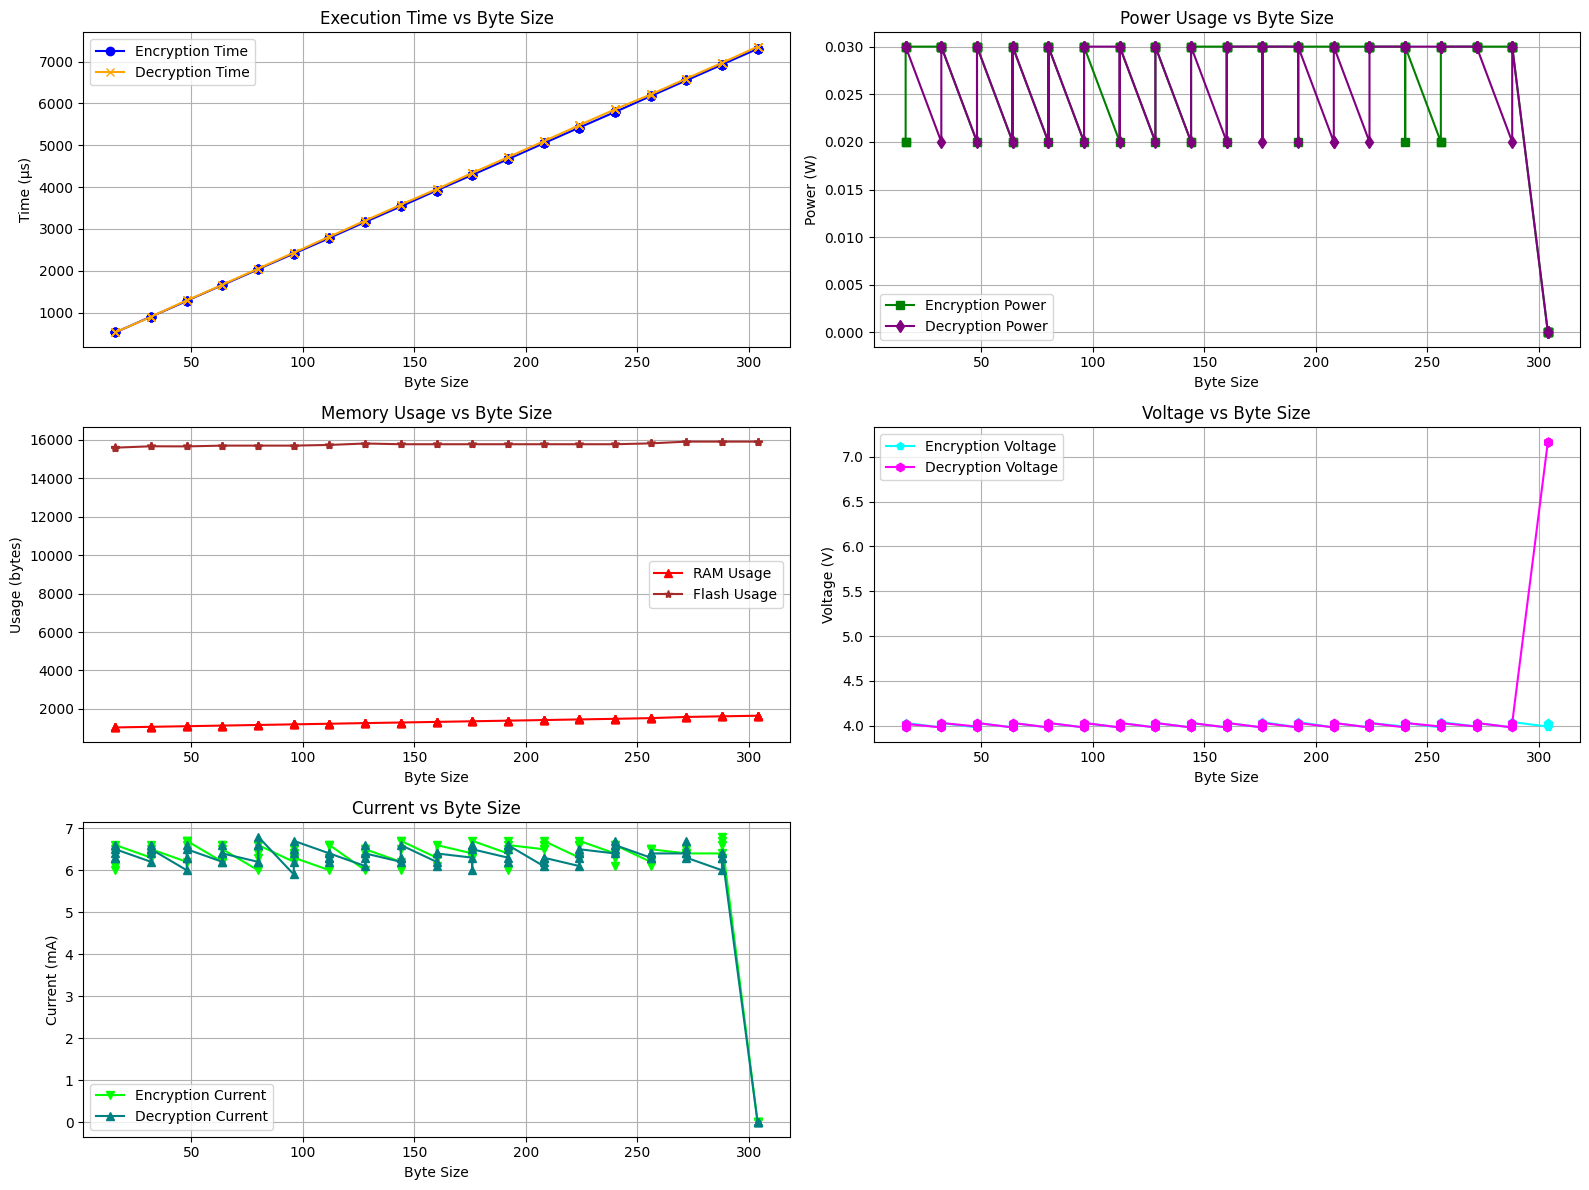

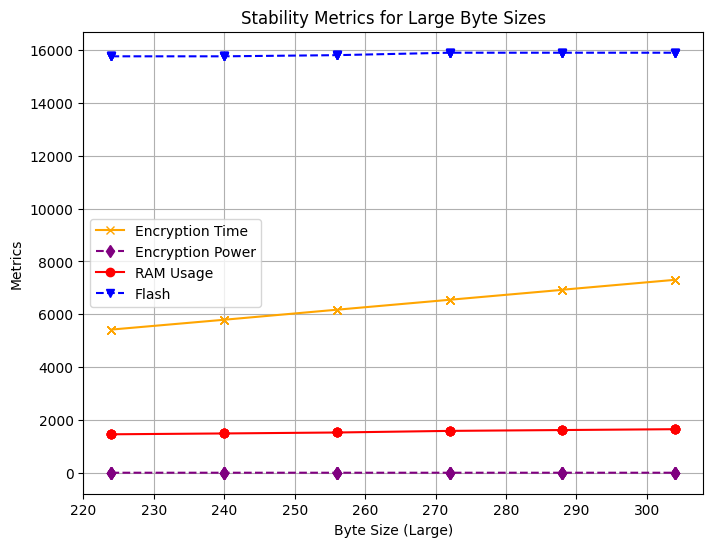

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kruskal

# Load the dataset
file_path = "nomean_skinny128_data.xlsx"  # Replace with your file name
data = pd.read_excel(file_path)

# Display structure of dataset
print(data.head())

# Define columns
byte_sizes = data["Byte Size"]
flash_usages = data["Flash (bytes)"]
ram_usages = data["RAM (bytes)"]
encryption_times = data["Encryption Time (\u00b5s)"]
decryption_times = data["Decryption Time (\u00b5s)"]
encryption_voltages = data["Encryption Voltage (V)"]
encryption_currents = data["Encryption Current (mA)"]
encryption_powers = data["Encryption Power (W)"]
decryption_voltages = data["Decryption Voltage (V)"]
decryption_currents = data["Decryption Current (mA)"]
decryption_powers = data["Decryption Power (W)"]

# Define groups for Kruskal-Wallis based on byte size thresholds
threshold = byte_sizes.max() * 0.7  # Define "large" as the top 30% of byte sizes
group_large = data[data["Byte Size"] >= threshold]
group_small = data[data["Byte Size"] < threshold]

# Perform Kruskal-Wallis test for each performance metric
kruskal_results = {
    "Flash": kruskal(group_large["Flash (bytes)"], group_small["Flash (bytes)"]),
    "RAM": kruskal(group_large["RAM (bytes)"], group_small["RAM (bytes)"]),
    "Encryption Time": kruskal(group_large["Encryption Time (\u00b5s)"], group_small["Encryption Time (\u00b5s)"]),
    "Decryption Time": kruskal(group_large["Decryption Time (\u00b5s)"], group_small["Decryption Time (\u00b5s)"]),
    "Encryption Voltage": kruskal(group_large["Encryption Voltage (V)"], group_small["Encryption Voltage (V)"]),
    "Decryption Voltage": kruskal(group_large["Decryption Voltage (V)"], group_small["Decryption Voltage (V)"]),
    "Encryption Current": kruskal(group_large["Encryption Current (mA)"], group_small["Encryption Current (mA)"]),
    "Decryption Current": kruskal(group_large["Decryption Current (mA)"], group_small["Decryption Current (mA)"]),
    "Encryption Power": kruskal(group_large["Encryption Power (W)"], group_small["Encryption Power (W)"]),
    "Decryption Power": kruskal(group_large["Decryption Power (W)"], group_small["Decryption Power (W)"]),
}

print("Kruskal-Wallis Test Results:")
for metric, result in kruskal_results.items():
    print(f"{metric}: statistic={result.statistic:.3f}, p-value={result.pvalue:.3e}")

# Plot trends to visualize performance
plt.figure(figsize=(16, 12))

# Execution Time vs Byte Size
plt.subplot(3, 2, 1)
plt.plot(byte_sizes, encryption_times, marker='o', color='b', label="Encryption Time")
plt.plot(byte_sizes, decryption_times, marker='x', color='orange', label="Decryption Time")
plt.title("Execution Time vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Time (\u00b5s)")
plt.legend()
plt.grid(True)

# Power Usage vs Byte Size
plt.subplot(3, 2, 2)
plt.plot(byte_sizes, encryption_powers, marker='s', color='g', label="Encryption Power")
plt.plot(byte_sizes, decryption_powers, marker='d', color='purple', label="Decryption Power")
plt.title("Power Usage vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Power (W)")
plt.legend()
plt.grid(True)

# Memory Usage vs Byte Size
plt.subplot(3, 2, 3)
plt.plot(byte_sizes, ram_usages, marker='^', color='r', label="RAM Usage")
plt.plot(byte_sizes, flash_usages, marker='*', color='brown', label="Flash Usage")
plt.title("Memory Usage vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Usage (bytes)")
plt.legend()
plt.grid(True)

# Voltage vs Byte Size
plt.subplot(3, 2, 4)
plt.plot(byte_sizes, encryption_voltages, marker='p', color='cyan', label="Encryption Voltage")
plt.plot(byte_sizes, decryption_voltages, marker='h', color='magenta', label="Decryption Voltage")
plt.title("Voltage vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Voltage (V)")
plt.legend()
plt.grid(True)

# Current vs Byte Size
plt.subplot(3, 2, 5)
plt.plot(byte_sizes, encryption_currents, marker='v', color='lime', label="Encryption Current")
plt.plot(byte_sizes, decryption_currents, marker='^', color='teal', label="Decryption Current")
plt.title("Current vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Current (mA)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Stability Check for Large Data
plt.figure(figsize=(8, 6))
plt.plot(group_large["Byte Size"], group_large["Encryption Time (\u00b5s)"], marker='x', linestyle='-', color='orange', label="Encryption Time")
plt.plot(group_large["Byte Size"], group_large["Encryption Power (W)"], marker='d', linestyle='--', color='purple', label="Encryption Power")
plt.plot(group_large["Byte Size"], group_large["RAM (bytes)"], marker='o', linestyle='-', color='red', label="RAM Usage")
plt.plot(group_large["Byte Size"], group_large["Flash (bytes)"], marker='v', linestyle='--', color='blue', label="Flash")
plt.title("Stability Metrics for Large Byte Sizes")
plt.xlabel("Byte Size (Large)")
plt.ylabel("Metrics")
plt.grid(True)
plt.legend()
plt.show()


# SKINNY256

Generate SKINNY256

In [ ]:
import os

# Folder output utama
code_folders = ["skinny256rfida", "skinny256rfidb", "skinny256rfidc", "skinny256rfidd", "skinny256rfide"]

# Buat folder utama jika belum ada
for folder in code_folders:
    os.makedirs(folder, exist_ok=True)

def generate_code_with_decrementing_plaintext(file_path, id_values):
    # Template kode Arduino
    code_template = f'''
#include <SPI.h>
#include <MFRC522.h>
#include <Wire.h>
#include <Adafruit_INA219.h>
#include "Skinny128.h"
#include <string.h>
#include <MemoryFree.h>
#include <LiquidCrystal_I2C.h> 

#define SS_PIN 10
#define RST_PIN 9

MFRC522 rfid(SS_PIN, RST_PIN);
Adafruit_INA219 ina219;
LiquidCrystal_I2C lcd(0x27, 16, 2);

Skinny128_256 skinny;
byte ciphertext[{id_values}];
byte decryptedtext[{id_values}];
unsigned long encryptionTime;
unsigned long decryptionTime;

byte buffer[16];

float encryptionVoltage;
float encryptionCurrent;
float decryptionVoltage;
float decryptionCurrent;

const byte key[32] = {{0x1f, 0x1e, 0x1d, 0x1c, 0x1b, 0x1a, 0x19, 0x18, 
                        0x17, 0x16, 0x15, 0x14, 0x13, 0x12, 0x11, 0x10, 
                        0x0f, 0x0e, 0x0d, 0x0c, 0x0b, 0x0a, 0x09, 0x08, 
                        x07, 0x06, 0x05, 0x04, 0x03, 0x02, 0x01, 0x00}};

void encryptAndMeasure(BlockCipher *cipher, const byte *key, size_t keySize, byte *plaintext, size_t plaintextSize) {{
  unsigned long startTime = micros();
  cipher->setKey(key, keySize);

  for (size_t i = 0; i < plaintextSize; i += 16) {{
    cipher->encryptBlock(buffer, &plaintext[i]);
    memcpy(&ciphertext[i], buffer, 16);
  }}

  unsigned long endTime = micros();
  encryptionVoltage = ina219.getBusVoltage_V();
  encryptionCurrent = ina219.getCurrent_mA();
  encryptionTime = endTime - startTime;

  // Output encrypted data (ciphertext)
  Serial.print(F("Ciphertext: "));
  for (size_t i = 0; i < plaintextSize; i++) {{
    if (ciphertext[i] < 0x10) Serial.print("0");
    Serial.print(ciphertext[i], HEX);
    Serial.print(" ");
  }}
  Serial.println();
  Serial.print(F("Encryption Completed in "));
  Serial.print(encryptionTime);
  Serial.println(F(" microseconds"));
}}

void decryptAndMeasure(BlockCipher *cipher, const byte *key, size_t keySize, byte *ciphertext, size_t ciphertextSize) {{
    unsigned long startdecTime = micros();
    cipher->setKey(key, keySize);

    for (size_t i = 0; i < ciphertextSize; i += 16) {{
        cipher->decryptBlock(buffer, &ciphertext[i]);
        memcpy(&decryptedtext[i], buffer, 16);
    }}

    unsigned long enddecTime = micros();
    decryptionVoltage = ina219.getBusVoltage_V();
    decryptionCurrent = ina219.getCurrent_mA();
    decryptionTime = enddecTime - startdecTime;

    // Output decrypted data
    Serial.print(F("Decrypted Text: "));
    for (size_t i = 0; i < ciphertextSize; i++) {{
        if (decryptedtext[i] < 0x10) Serial.print("0");
        Serial.print(decryptedtext[i], HEX);
        Serial.print(" ");
    }}
    Serial.println();
    Serial.print(F("Decryption Completed in "));
    Serial.print(decryptionTime);
    Serial.println(F(" microseconds"));
}}

void displayData() {{
    float encryptionPower = encryptionVoltage * (encryptionCurrent / 1000);
    float decryptionPower = decryptionVoltage * (decryptionCurrent / 1000);
    int memoryUsage = 2048 - freeMemory();

    Serial.print(F("Memory Usage = "));
    Serial.print(memoryUsage);
    Serial.println(F(" B"));

    Serial.print(F("Encryption Voltage: "));
    Serial.print(encryptionVoltage);
    Serial.println(F(" V"));
    Serial.print(F("Encryption Current: "));
    Serial.print(encryptionCurrent);
    Serial.println(F(" mA"));
    Serial.print(F("Encryption Power: "));
    Serial.print(encryptionPower);
    Serial.println(F(" W"));
    
    Serial.print(F("Decryption Voltage: "));
    Serial.print(decryptionVoltage);
    Serial.println(F(" V"));
    Serial.print(F("Decryption Current: "));
    Serial.print(decryptionCurrent);
    Serial.println(F(" mA"));
    Serial.print(F("Decryption Power: "));
    Serial.print(decryptionPower);
    Serial.println(F(" W"));

    Serial.println(F("selesai"));
}}

void setup() {{
    Serial.begin(9600);
    SPI.begin();
    rfid.PCD_Init();
    ina219.begin();
    
    lcd.begin(16, 2);
    lcd.backlight();
    lcd.setCursor(0, 0);
    lcd.print("RFID System Ready");
    delay(2000);
    lcd.clear();
}}

void loop() {{
    if (rfid.PICC_IsNewCardPresent() && rfid.PICC_ReadCardSerial()) {{
        byte cardID[{id_values}] = {{0}};
        size_t idLength = rfid.uid.size;

        for (byte i = 0; i < idLength && i < {id_values}; i++) {{
            cardID[i] = rfid.uid.uidByte[i];
        }}

        if (idLength < {id_values}) {{
            memset(&cardID[idLength], 0, {id_values} - idLength);
        }}

        lcd.clear();
        lcd.setCursor(0, 0);
        lcd.print("RFID Detected!");
        lcd.setCursor(0, 1);
        lcd.print("Encrypting...");

        encryptAndMeasure(&skinny, key, sizeof(key), cardID, {id_values});
        decryptAndMeasure(&skinny, key, sizeof(key), ciphertext, {id_values});
        displayData();

        lcd.clear();
        lcd.setCursor(0, 0);
        lcd.print("Encryption Done!");
        delay(2000);
        lcd.clear();
    }}
}}
'''

    with open(file_path, 'w') as file:
        file.write(code_template)

    print(f"Code with {id_values}-byte plaintext has been written to {file_path}")

# Generate folders and codes
for folder in code_folders:
    for i in range(352, 15, -16):
        filename = f"skinny256_{i}"
        sketch_folder = os.path.join(folder, filename)
        os.makedirs(sketch_folder, exist_ok=True)  # Membuat folder untuk setiap file

        file_path = os.path.join(sketch_folder, f"{filename}.ino")

        generate_code_with_decrementing_plaintext(file_path, i)


Running SKINNY256

In [ ]:
# Configuration
port = "COM8"
baud_rate = 9600
# base_folders = ["skinny256rfida", "skinny256rfidb", "skinny256rfidc", "skinny256rfidd", "skinny256rfide"]
base_folders = ["skinny256rfide"]
log_folder = "logs_skinny256_multi"
arduino_cli_path = r"C:\Program Files\Arduino IDE\resources\app\lib\backend\resources\arduino-cli.exe"

# Create log folder if it doesn't exist
os.makedirs(log_folder, exist_ok=True)

# Timeout duration in seconds for each phase
COMPILE_TIMEOUT = 60
UPLOAD_TIMEOUT = 30
SERIAL_TIMEOUT = 10


def parse_serial_data(serial_line):
    """
    Parse the serial data and return structured information.
    """
    if "Ciphertext" in serial_line:
        match = re.search(r"Ciphertext: (.+)", serial_line)
        return {"Ciphertext": match.group(1)} if match else None
    elif "Encryption Completed" in serial_line:
        match = re.search(r"Encryption Completed in (\d+) microseconds", serial_line)
        return {"Encryption Time": int(match.group(1))} if match else None
    elif "Decrypted Text" in serial_line:
        match = re.search(r"Decrypted Text: (.+)", serial_line)
        return {"Decrypted Text": match.group(1)} if match else None
    elif "Decryption Completed" in serial_line:
        match = re.search(r"Decryption Completed in (\d+) microseconds", serial_line)
        return {"Decryption Time": int(match.group(1))} if match else None
    elif "Memory Usage" in serial_line:
        match = re.search(r"Memory Usage = (\d+) B", serial_line)
        return {"Memory Usage (B)": int(match.group(1))} if match else None
    elif "Encryption Voltage" in serial_line:
        match = re.search(r"Encryption Voltage: ([\d.]+) V", serial_line)
        return {"Encryption Voltage (V)": float(match.group(1))} if match else None
    elif "Encryption Current" in serial_line:
        match = re.search(r"Encryption Current: ([\d.]+) mA", serial_line)
        return {"Encryption Current (mA)": float(match.group(1))} if match else None
    elif "Encryption Power" in serial_line:
        match = re.search(r"Encryption Power: ([\d.]+) W", serial_line)
        return {"Encryption Power (W)": float(match.group(1))} if match else None
    elif "Decryption Voltage" in serial_line:
        match = re.search(r"Decryption Voltage: ([\d.]+) V", serial_line)
        return {"Decryption Voltage (V)": float(match.group(1))} if match else None
    elif "Decryption Current" in serial_line:
        match = re.search(r"Decryption Current: ([\d.]+) mA", serial_line)
        return {"Decryption Current (mA)": float(match.group(1))} if match else None
    elif "Decryption Power" in serial_line:
        match = re.search(r"Decryption Power: ([\d.]+) W", serial_line)
        return {"Decryption Power (W)": float(match.group(1))} if match else None
    elif "selesai" in serial_line.lower():
        return {"Status": "Process Completed"}
    return {"Raw": serial_line.strip()}


def compile_and_upload(sketch_name, sketch_path):
    log_file = os.path.join(log_folder, f"{sketch_name}_output.txt")
    
    try:
        # Compile code to get storage information
        compile_command = [arduino_cli_path, "compile", "--fqbn", "arduino:avr:nano", sketch_path]
        result = subprocess.run(compile_command, capture_output=True, text=True, timeout=COMPILE_TIMEOUT)
        
        # Retrieve storage information from compilation output
        flash_match = re.search(r"Sketch uses (\d+) bytes.*Maximum is (\d+) bytes", result.stdout)
        ram_match = re.search(r"Global variables use (\d+) bytes.*Maximum is (\d+) bytes", result.stdout)
        flash_usage = f"{flash_match.group(1)} / {flash_match.group(2)} bytes" if flash_match else "Unknown"
        ram_usage = f"{ram_match.group(1)} / {ram_match.group(2)} bytes" if ram_match else "Unknown"

        print(f"{sketch_name} - Flash: {flash_usage}, RAM: {ram_usage}")

        # Log Flash and RAM info
        with open(log_file, "w", encoding="utf-8") as f:
            f.write(f"{sketch_name} - Flash: {flash_usage}, RAM: {ram_usage}\n\n")

        # Upload code to Arduino
        upload_command = [arduino_cli_path, "upload", "-p", port, "--fqbn", "arduino:avr:nano", sketch_path]
        subprocess.run(upload_command, timeout=UPLOAD_TIMEOUT)

        time.sleep(2)  # Wait after upload

    except subprocess.TimeoutExpired:
        print(f"Error: {sketch_name} - Compilation or upload timed out.")
    except Exception as e:
        print(f"Error: {sketch_name} - {e}")

    # Read from Serial Monitor and log to file
    try:
        with serial.Serial(port, baud_rate, timeout=1) as ser, open(log_file, "a", encoding="utf-8") as f:
            start_time = time.time()
            while time.time() - start_time < SERIAL_TIMEOUT:
                if ser.in_waiting > 0:
                    line = ser.readline().decode("utf-8", errors="ignore").strip()
                    parsed_line = parse_serial_data(line)
                    print(parsed_line)
                    f.write(str(parsed_line) + "\n")
                    if "Status" in parsed_line and parsed_line["Status"] == "Process Completed":
                        print(f"Detected completion for {sketch_name}.")
                        return
    except serial.SerialException as e:
        print(f"Serial Error: {sketch_name} - {e}")
    except Exception as e:
        print(f"Error while reading serial: {sketch_name} - {e}")


# Loop through each base folder
for base_folder in base_folders:
    subfolders = sorted(
        [folder for folder in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, folder))],
        key=lambda x: int(x.split('_')[1])  # Extract number after "128_" and sort numerically
    )

    for folder_name in subfolders:
        sketch_path = os.path.join(base_folder, folder_name, f"{folder_name}.ino")
        if os.path.isfile(sketch_path):
            print(f"Running {folder_name} in {base_folder}...")
            compile_and_upload(f"{base_folder}_{folder_name}", sketch_path)
            print(f"Completed {folder_name} in {base_folder}\n")
        else:
            print(f"File {folder_name}.ino not found in {folder_name} within {base_folder}")


CSV SKINNY256

In [8]:
import ast  # Import untuk evaluasi literal
import pandas as pd
from glob import glob

# Konfigurasi
log_folder = "logs_skinny256_multi"
output_csv = "nomean_skinny256_data.csv"

# Ukuran byte yang sesuai dengan file log
byte_sizes = [16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256, 272, 288, 304, 320, 336, 352]

# List untuk menyimpan data hasil pemrosesan
data_list = []

# Proses setiap ukuran byte
for byte_size in byte_sizes:
    files = glob(f"{log_folder}/*_{byte_size}_output*")
    if not files:
        print(f"No log files found for byte size: {byte_size}")
        continue

    print(f"Processing byte size: {byte_size}...")

    for file in files:
        try:
            flash_value = ram_value = encryption_time = decryption_time = None
            encryption_voltage = encryption_current = encryption_power = None
            decryption_voltage = decryption_current = decryption_power = None

            with open(file, 'r') as f:
                for line in f:
                    line = line.strip()

                    if "Flash:" in line:
                        try:
                            flash_value = int(line.split("Flash:")[1].split('/')[0].strip())
                        except Exception as e:
                            print(f"Error parsing Flash in line: {line} - {e}")

                    elif "'Encryption Time" in line:
                        try:
                            data = ast.literal_eval(line)
                            if "Encryption Time" in data:
                                encryption_time = int(data["Encryption Time"])
                        except Exception as e:
                            print(f"Error parsing Encryption Time in line: {line} - {e}")

                    elif "'Decryption Time':" in line:
                        try:
                            data = ast.literal_eval(line)
                            if "Decryption Time" in data:
                                decryption_time = int(data["Decryption Time"])
                        except Exception as e:
                            print(f"Error parsing Decryption Time in line: {line} - {e}")

                    elif "Memory Usage:" in line or "Memory Usage (B)" in line:
                        try:
                            data = ast.literal_eval(line)
                            if "Memory Usage (B)" in data:
                                ram_value = int(data["Memory Usage (B)"])
                        except Exception as e:
                            print(f"Error parsing RAM in line: {line} - {e}")

                    elif "Voltage" in line or "Current" in line or "Power" in line:
                        try:
                            data = ast.literal_eval(line)
                            if "Encryption Voltage (V)" in data:
                                encryption_voltage = float(data["Encryption Voltage (V)"])
                            if "Encryption Current (mA)" in data:
                                encryption_current = float(data["Encryption Current (mA)"])
                            if "Encryption Power (W)" in data:
                                encryption_power = float(data["Encryption Power (W)"])
                            if "Decryption Voltage (V)" in data:
                                decryption_voltage = float(data["Decryption Voltage (V)"])
                            if "Decryption Current (mA)" in data:
                                decryption_current = float(data["Decryption Current (mA)"])
                            if "Decryption Power (W)" in data:
                                decryption_power = float(data["Decryption Power (W)"])
                        except Exception as e:
                            print(f"Error parsing Voltage/Current/Power in line: {line} - {e}")

            # Tambahkan data ke list
            data_list.append({
                "Byte Size": byte_size,
                "File Name": file,
                "Flash (bytes)": flash_value,
                "RAM (bytes)": ram_value,
                "Encryption Time (µs)": encryption_time,
                "Decryption Time (µs)": decryption_time,
                "Encryption Voltage (V)": encryption_voltage,
                "Encryption Current (mA)": encryption_current,
                "Encryption Power (W)": encryption_power,
                "Decryption Voltage (V)": decryption_voltage,
                "Decryption Current (mA)": decryption_current,
                "Decryption Power (W)": decryption_power,
            })

        except Exception as e:
            print(f"Error reading file {file}: {e}")

# Simpan data ke CSV
df = pd.DataFrame(data_list)
df.to_csv(output_csv, index=False)

# Tampilkan beberapa data
print(df.head())


Processing byte size: 16...
Processing byte size: 32...
Processing byte size: 48...
Processing byte size: 64...
Processing byte size: 80...
Processing byte size: 96...
Processing byte size: 112...
Processing byte size: 128...
Processing byte size: 144...
Processing byte size: 160...
Processing byte size: 176...
Processing byte size: 192...
Processing byte size: 208...
Processing byte size: 224...
Processing byte size: 240...
Processing byte size: 256...
Processing byte size: 272...
Processing byte size: 288...
Processing byte size: 304...
Processing byte size: 320...
Processing byte size: 336...
No log files found for byte size: 352
   Byte Size                                          File Name  \
0         16  logs_skinny256_multi\skinny256rfida_skinny256_...   
1         16  logs_skinny256_multi\skinny256rfidb_skinny256_...   
2         16  logs_skinny256_multi\skinny256rfidc_skinny256_...   
3         16  logs_skinny256_multi\skinny256rfidd_skinny256_...   
4         16  logs_skinn

Output SKINNY256

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Membaca data dari CSV (sesuaikan path jika diperlukan)
file_path = 'processed_skinny256_data.csv'
data = pd.read_csv(file_path)

# Grafik 1: Byte Size vs Encryption Time
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Encryption Time (µs)'], marker='o', label='Encryption Time (µs)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Encryption Time (µs)')
plt.title('Byte Size vs Encryption Time')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 2: Byte Size vs Decryption Time
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Decryption Time (µs)'], marker='o', label='Decryption Time (µs)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Decryption Time (µs)')
plt.title('Byte Size vs Decryption Time')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 3: Byte Size vs Encryption & Decryption Time
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Encryption Time (µs)'], marker='o', label='Encryption Time (µs)')
plt.plot(data['Byte Size'], data['Avg Decryption Time (µs)'], marker='o', label='Decryption Time (µs)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Time (µs)')
plt.title('Byte Size vs Encryption & Decryption Time')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 4: Byte Size vs Flash
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Flash (bytes)'], marker='o', label='Flash (bytes)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Flash (bytes)')
plt.title('Byte Size vs Flash')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 5: Byte Size vs RAM
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg RAM (bytes)'], marker='o', label='RAM (bytes)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('RAM (bytes)')
plt.title('Byte Size vs RAM')
plt.grid(True)
plt.legend()
plt.show()

# # Grafik 6: Byte Size vs Encryption Voltage
# plt.figure(figsize=(8, 6))
# plt.plot(data['Byte Size'], data['Avg Encryption Voltage (V)'], marker='o', label='Encryption Voltage (V)')
# plt.xlabel('Byte Size (bytes)')
# plt.ylabel('Voltage (V)')
# plt.title('Byte Size vs Encryption Voltage')
# plt.grid(True)
# plt.legend()
# plt.show()

# # Grafik 7: Byte Size vs Encryption Current
# plt.figure(figsize=(8, 6))
# plt.plot(data['Byte Size'], data['Avg Encryption Current (A)'], marker='o', label='Encryption Current (A)')
# plt.xlabel('Byte Size (bytes)')
# plt.ylabel('Current (A)')
# plt.title('Byte Size vs Encryption Current')
# plt.grid(True)
# plt.legend()
# plt.show()

# # Grafik 8: Byte Size vs Encryption Power
# plt.figure(figsize=(8, 6))
# plt.plot(data['Byte Size'], data['Avg Encryption Power (W)'], marker='o', label='Encryption Power (W)')
# plt.xlabel('Byte Size (bytes)')
# plt.ylabel('Power (W)')
# plt.title('Byte Size vs Encryption Power')
# plt.grid(True)
# plt.legend()
# plt.show()

# Grafik 9: Byte Size vs Encryption Voltage dan Decryption Voltage
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Encryption Voltage (V)'], marker='o', label='Encryption Voltage (V)')
plt.plot(data['Byte Size'], data['Avg Decryption Voltage (V)'], marker='h', label='Decryption Voltage (V)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Voltage (V)')
plt.title('Byte Size vs Encryption Voltage & Decryption Voltage')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 10: Byte Size vs Encryption Current dan Duplicate Current
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Encryption Current (mA)'], marker='o', label='Encryption Current (mA)')
plt.plot(data['Byte Size'], data['Avg Decryption Current (mA)'], marker='h', label='Decryption Current (mA)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Current (A)')
plt.title('Byte Size vs Encryption Current & Decryption Current')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 11: Byte Size vs Encryption Power dan Duplicate Power
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Encryption Power (W)'], marker='o', label='Encryption Power (W)')
plt.plot(data['Byte Size'], data['Avg Decryption Power (W)'], marker='h', label='Decryption Power (W)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Power (W)')
plt.title('Byte Size vs Encryption Power & Decryption Power')
plt.grid(True)
plt.legend()
plt.show()


KW 256

RM2 256

In [3]:

# Load dataset
file_path = "nomean_skinny256_data.xlsx"  # Replace with your file path
data = pd.read_excel(file_path)

# Display the structure of the dataset
print(data.head())

# Define columns for analysis
byte_sizes = data["Byte Size"].unique()  # Unique byte sizes

# Group data by byte size for Kruskal-Wallis analysis
grouped_flash_usages = [data[data["Byte Size"] == b]["Flash (bytes)"].dropna() for b in byte_sizes]
grouped_ram_usages = [data[data["Byte Size"] == b]["RAM (bytes)"].dropna() for b in byte_sizes]
grouped_encryption_times = [data[data["Byte Size"] == b]["Encryption Time (µs)"].dropna() for b in byte_sizes]
grouped_decryption_times = [data[data["Byte Size"] == b]["Decryption Time (µs)"].dropna() for b in byte_sizes]
grouped_encryption_powers = [data[data["Byte Size"] == b]["Encryption Power (W)"].dropna() for b in byte_sizes]
grouped_decryption_powers = [data[data["Byte Size"] == b]["Decryption Power (W)"].dropna() for b in byte_sizes]

# Perform Kruskal-Wallis test for each metric
kw_flash_usage = kruskal(*grouped_flash_usages)
kw_ram_usage = kruskal(*grouped_ram_usages)
kw_encryption_time = kruskal(*grouped_encryption_times)
kw_decryption_time = kruskal(*grouped_decryption_times)
kw_encryption_power = kruskal(*grouped_encryption_powers)
kw_decryption_power = kruskal(*grouped_decryption_powers)

# Display results
print("Kruskal-Wallis Test Results:")
print(f"Flash Usage: H-statistic = {kw_flash_usage.statistic}, p-value = {kw_flash_usage.pvalue}")
print(f"RAM Usage: H-statistic = {kw_ram_usage.statistic}, p-value = {kw_ram_usage.pvalue}")
print(f"Encryption Time: H-statistic = {kw_encryption_time.statistic}, p-value = {kw_encryption_time.pvalue}")
print(f"Decryption Time: H-statistic = {kw_decryption_time.statistic}, p-value = {kw_decryption_time.pvalue}")
print(f"Encryption Power: H-statistic = {kw_encryption_power.statistic}, p-value = {kw_encryption_power.pvalue}")
print(f"Decryption Power: H-statistic = {kw_decryption_power.statistic}, p-value = {kw_decryption_power.pvalue}")

# Interpretation
if kw_flash_usage.pvalue < 0.05:
    print("Significant difference found in Flash Usage across byte sizes.")
else:
    print("No significant difference in Flash Usage across byte sizes.")

if kw_ram_usage.pvalue < 0.05:
    print("Significant difference found in RAM Usage across byte sizes.")
else:
    print("No significant difference in RAM Usage across byte sizes.")

if kw_encryption_time.pvalue < 0.05:
    print("Significant difference found in Encryption Time across byte sizes.")
else:
    print("No significant difference in Encryption Time across byte sizes.")

if kw_decryption_time.pvalue < 0.05:
    print("Significant difference found in Decryption Time across byte sizes.")
else:
    print("No significant difference in Decryption Time across byte sizes.")

if kw_encryption_power.pvalue < 0.05:
    print("Significant difference found in Encryption Power across byte sizes.")
else:
    print("No significant difference in Encryption Power across byte sizes.")

if kw_decryption_power.pvalue < 0.05:
    print("Significant difference found in Decryption Power across byte sizes.")
else:
    print("No significant difference in Decryption Power across byte sizes.")


   Byte Size                                          File Name  \
0         16  logs_skinny256_multi\skinny256rfida_skinny256_...   
1         16  logs_skinny256_multi\skinny256rfidb_skinny256_...   
2         16  logs_skinny256_multi\skinny256rfidc_skinny256_...   
3         16  logs_skinny256_multi\skinny256rfidd_skinny256_...   
4         16  logs_skinny256_multi\skinny256rfide_skinny256_...   

   Flash (bytes)  RAM (bytes)  Encryption Time (µs)  Decryption Time (µs)  \
0          15928         1119                   940                   940   
1          15928         1119                   940                   944   
2          15928         1119                   940                   940   
3          15928         1119                   940                   940   
4          15928         1119                   940                   940   

   Encryption Voltage (V)  Encryption Current (mA)  Encryption Power (W)  \
0                    3.98                      6.1        

RM3

   Byte Size                                          File Name  \
0         16  logs_skinny256_multi\skinny256rfida_skinny256_...   
1         16  logs_skinny256_multi\skinny256rfidb_skinny256_...   
2         16  logs_skinny256_multi\skinny256rfidc_skinny256_...   
3         16  logs_skinny256_multi\skinny256rfidd_skinny256_...   
4         16  logs_skinny256_multi\skinny256rfide_skinny256_...   

   Flash (bytes)  RAM (bytes)  Encryption Time (µs)  Decryption Time (µs)  \
0          15928         1119                   940                   940   
1          15928         1119                   940                   944   
2          15928         1119                   940                   940   
3          15928         1119                   940                   940   
4          15928         1119                   940                   940   

   Encryption Voltage (V)  Encryption Current (mA)  Encryption Power (W)  \
0                    3.98                      6.1        

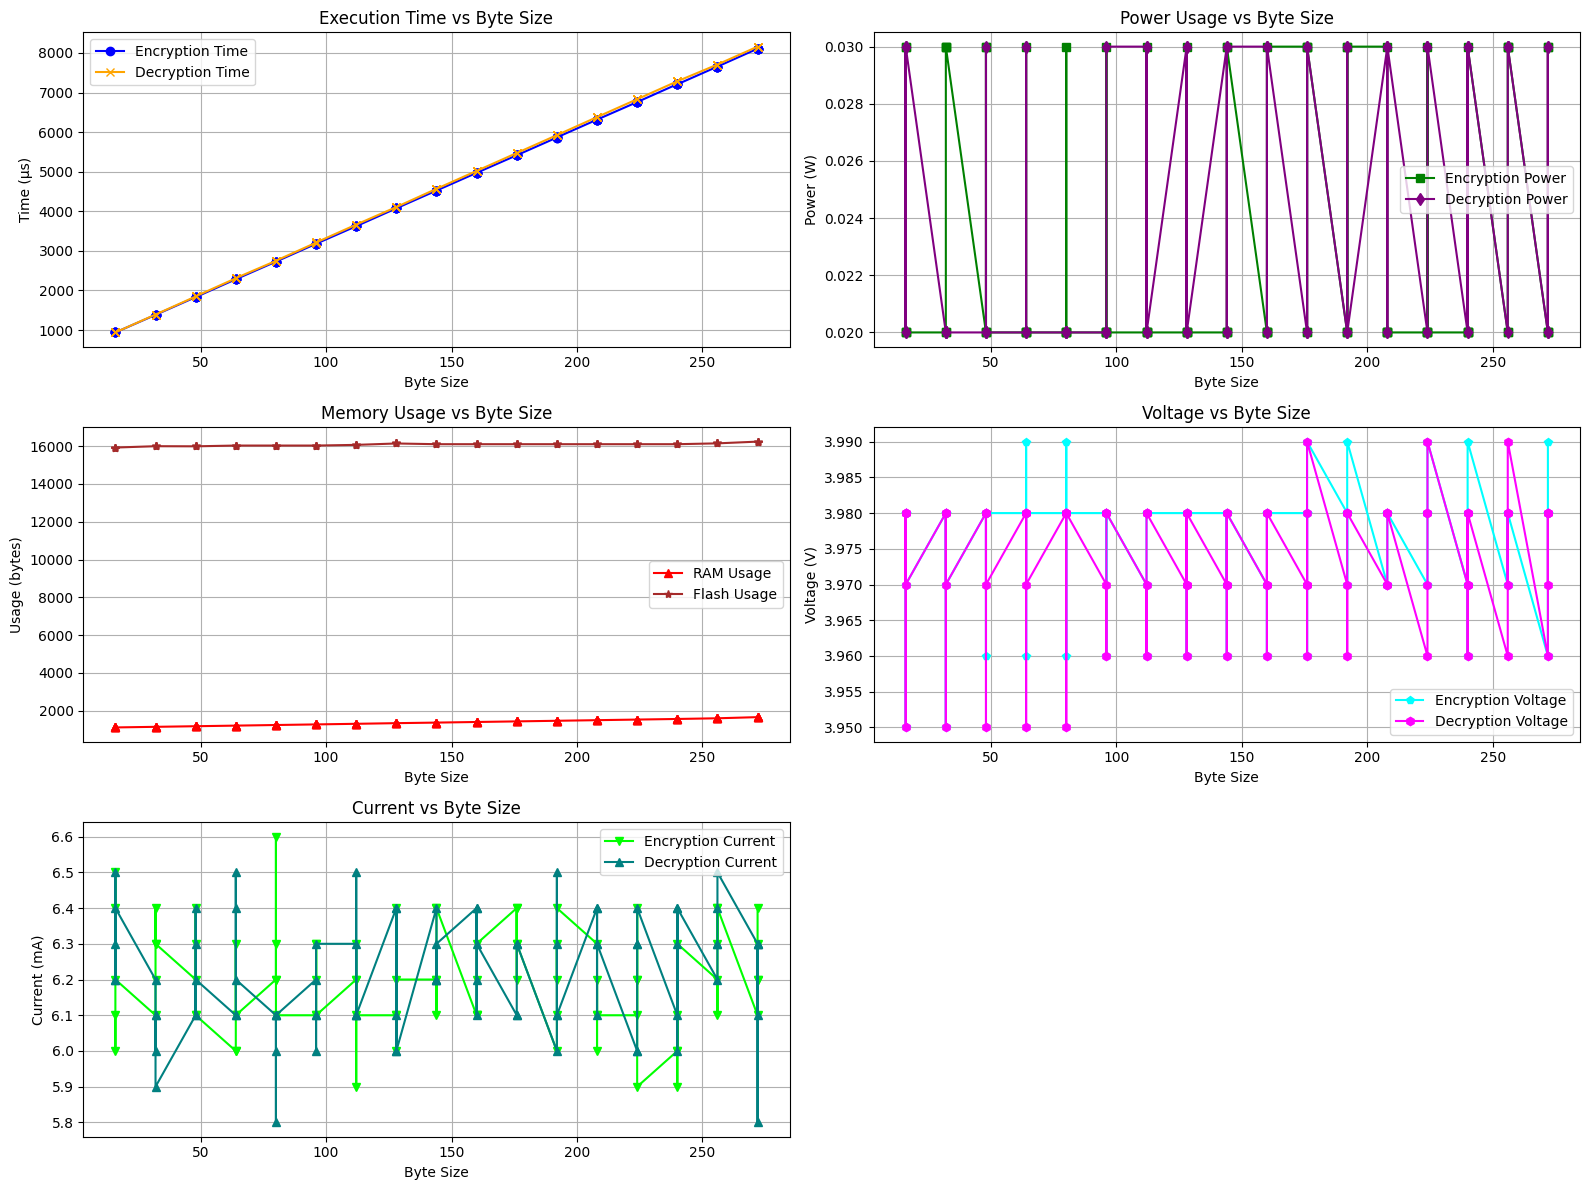

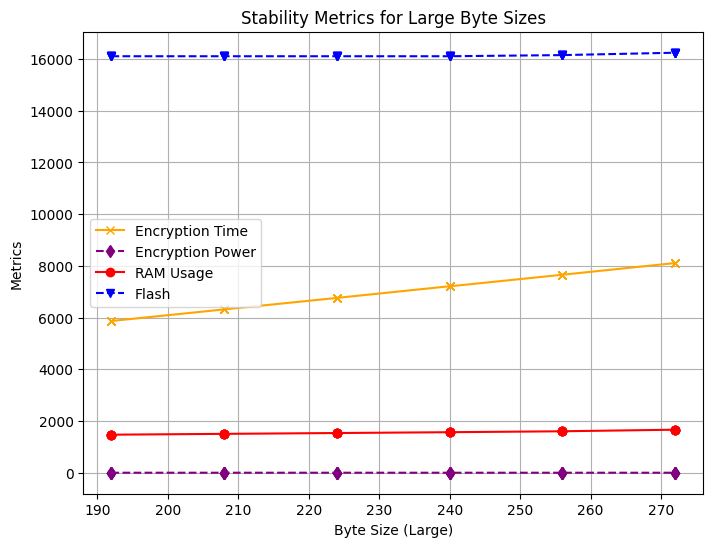

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kruskal

# Load the dataset
file_path = "nomean_skinny256_data.xlsx"  # Replace with your file name
data = pd.read_excel(file_path)

# Display structure of dataset
print(data.head())

# Define columns
byte_sizes = data["Byte Size"]
flash_usages = data["Flash (bytes)"]
ram_usages = data["RAM (bytes)"]
encryption_times = data["Encryption Time (\u00b5s)"]
decryption_times = data["Decryption Time (\u00b5s)"]
encryption_voltages = data["Encryption Voltage (V)"]
encryption_currents = data["Encryption Current (mA)"]
encryption_powers = data["Encryption Power (W)"]
decryption_voltages = data["Decryption Voltage (V)"]
decryption_currents = data["Decryption Current (mA)"]
decryption_powers = data["Decryption Power (W)"]

# Define groups for Kruskal-Wallis based on byte size thresholds
threshold = byte_sizes.max() * 0.7  # Define "large" as the top 30% of byte sizes
group_large = data[data["Byte Size"] >= threshold]
group_small = data[data["Byte Size"] < threshold]

# Perform Kruskal-Wallis test for each performance metric
kruskal_results = {
    "Flash": kruskal(group_large["Flash (bytes)"], group_small["Flash (bytes)"]),
    "RAM": kruskal(group_large["RAM (bytes)"], group_small["RAM (bytes)"]),
    "Encryption Time": kruskal(group_large["Encryption Time (\u00b5s)"], group_small["Encryption Time (\u00b5s)"]),
    "Decryption Time": kruskal(group_large["Decryption Time (\u00b5s)"], group_small["Decryption Time (\u00b5s)"]),
    "Encryption Voltage": kruskal(group_large["Encryption Voltage (V)"], group_small["Encryption Voltage (V)"]),
    "Decryption Voltage": kruskal(group_large["Decryption Voltage (V)"], group_small["Decryption Voltage (V)"]),
    "Encryption Current": kruskal(group_large["Encryption Current (mA)"], group_small["Encryption Current (mA)"]),
    "Decryption Current": kruskal(group_large["Decryption Current (mA)"], group_small["Decryption Current (mA)"]),
    "Encryption Power": kruskal(group_large["Encryption Power (W)"], group_small["Encryption Power (W)"]),
    "Decryption Power": kruskal(group_large["Decryption Power (W)"], group_small["Decryption Power (W)"]),
}

print("Kruskal-Wallis Test Results:")
for metric, result in kruskal_results.items():
    print(f"{metric}: statistic={result.statistic:.3f}, p-value={result.pvalue:.3e}")

# Plot trends to visualize performance
plt.figure(figsize=(16, 12))

# Execution Time vs Byte Size
plt.subplot(3, 2, 1)
plt.plot(byte_sizes, encryption_times, marker='o', color='b', label="Encryption Time")
plt.plot(byte_sizes, decryption_times, marker='x', color='orange', label="Decryption Time")
plt.title("Execution Time vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Time (\u00b5s)")
plt.legend()
plt.grid(True)

# Power Usage vs Byte Size
plt.subplot(3, 2, 2)
plt.plot(byte_sizes, encryption_powers, marker='s', color='g', label="Encryption Power")
plt.plot(byte_sizes, decryption_powers, marker='d', color='purple', label="Decryption Power")
plt.title("Power Usage vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Power (W)")
plt.legend()
plt.grid(True)

# Memory Usage vs Byte Size
plt.subplot(3, 2, 3)
plt.plot(byte_sizes, ram_usages, marker='^', color='r', label="RAM Usage")
plt.plot(byte_sizes, flash_usages, marker='*', color='brown', label="Flash Usage")
plt.title("Memory Usage vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Usage (bytes)")
plt.legend()
plt.grid(True)

# Voltage vs Byte Size
plt.subplot(3, 2, 4)
plt.plot(byte_sizes, encryption_voltages, marker='p', color='cyan', label="Encryption Voltage")
plt.plot(byte_sizes, decryption_voltages, marker='h', color='magenta', label="Decryption Voltage")
plt.title("Voltage vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Voltage (V)")
plt.legend()
plt.grid(True)

# Current vs Byte Size
plt.subplot(3, 2, 5)
plt.plot(byte_sizes, encryption_currents, marker='v', color='lime', label="Encryption Current")
plt.plot(byte_sizes, decryption_currents, marker='^', color='teal', label="Decryption Current")
plt.title("Current vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Current (mA)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Stability Check for Large Data
plt.figure(figsize=(8, 6))
plt.plot(group_large["Byte Size"], group_large["Encryption Time (\u00b5s)"], marker='x', linestyle='-', color='orange', label="Encryption Time")
plt.plot(group_large["Byte Size"], group_large["Encryption Power (W)"], marker='d', linestyle='--', color='purple', label="Encryption Power")
plt.plot(group_large["Byte Size"], group_large["RAM (bytes)"], marker='o', linestyle='-', color='red', label="RAM Usage")
plt.plot(group_large["Byte Size"], group_large["Flash (bytes)"], marker='v', linestyle='--', color='blue', label="Flash")
plt.title("Stability Metrics for Large Byte Sizes")
plt.xlabel("Byte Size (Large)")
plt.ylabel("Metrics")
plt.grid(True)
plt.legend()
plt.show()


# SKINNY384

Generate SKINNY384

In [ ]:
import os

# Folder output utama
code_folders = ["skinny384rfida", "skinny384rfidb", "skinny384rfidc", "skinny384rfidd", "skinny384rfide"]

# Buat folder utama jika belum ada
for folder in code_folders:
    os.makedirs(folder, exist_ok=True)

def generate_code_with_decrementing_plaintext(file_path, id_values):
    # Template kode Arduino
    code_template = f'''
#include <SPI.h>
#include <MFRC522.h>
#include <Wire.h>
#include <Adafruit_INA219.h>
#include "Skinny128.h"
#include <string.h>
#include <MemoryFree.h>
#include <LiquidCrystal_I2C.h> 

#define SS_PIN 10
#define RST_PIN 9

MFRC522 rfid(SS_PIN, RST_PIN);
Adafruit_INA219 ina219;
LiquidCrystal_I2C lcd(0x27, 16, 2);

Skinny128_384 skinny;
byte ciphertext[{id_values}];
byte decryptedtext[{id_values}];
unsigned long encryptionTime;
unsigned long decryptionTime;

byte buffer[16];

float encryptionVoltage;
float encryptionCurrent;
float decryptionVoltage;
float decryptionCurrent;

const byte key[48] = {{0x1f, 0x1e, 0x1d, 0x1c, 0x1b, 0x1a,  // 6 bytes
                             0x19, 0x18, 0x17, 0x16, 0x15, 0x14,  // 12 bytes
                            0x13, 0x12, 0x11, 0x10, 0x0f, 0x0e,  // 18 bytes
                            0x0d, 0x0c, 0x0b, 0x0a, 0x09, 0x08,  // 24 bytes
                            0x07, 0x06, 0x05, 0x04, 0x03, 0x02,  // 30 bytes                              
                            0x01, 0x00, 0x1d, 0x1c, 0x1b, 0x1a,  // 36 bytes
                             0x19, 0x18, 0x17, 0x16, 0x15, 0x14,  // 42 bytes
                            0x13, 0x12, 0x11, 0x10, 0x0f, 0x0e // 48 bytes
                              }};

void encryptAndMeasure(BlockCipher *cipher, const byte *key, size_t keySize, byte *plaintext, size_t plaintextSize) {{
  unsigned long startTime = micros();
  cipher->setKey(key, keySize);

  for (size_t i = 0; i < plaintextSize; i += 16) {{
    cipher->encryptBlock(buffer, &plaintext[i]);
    memcpy(&ciphertext[i], buffer, 16);
  }}

  unsigned long endTime = micros();
  encryptionVoltage = ina219.getBusVoltage_V();
  encryptionCurrent = ina219.getCurrent_mA();
  encryptionTime = endTime - startTime;

  // Output encrypted data (ciphertext)
  Serial.print(F("Ciphertext: "));
  for (size_t i = 0; i < plaintextSize; i++) {{
    if (ciphertext[i] < 0x10) Serial.print("0");
    Serial.print(ciphertext[i], HEX);
    Serial.print(" ");
  }}
  Serial.println();
  Serial.print(F("Encryption Completed in "));
  Serial.print(encryptionTime);
  Serial.println(F(" microseconds"));
}}

void decryptAndMeasure(BlockCipher *cipher, const byte *key, size_t keySize, byte *ciphertext, size_t ciphertextSize) {{
    unsigned long startdecTime = micros();
    cipher->setKey(key, keySize);

    for (size_t i = 0; i < ciphertextSize; i += 16) {{
        cipher->decryptBlock(buffer, &ciphertext[i]);
        memcpy(&decryptedtext[i], buffer, 16);
    }}

    unsigned long enddecTime = micros();
    decryptionVoltage = ina219.getBusVoltage_V();
    decryptionCurrent = ina219.getCurrent_mA();
    decryptionTime = enddecTime - startdecTime;

    // Output decrypted data
    Serial.print(F("Decrypted Text: "));
    for (size_t i = 0; i < ciphertextSize; i++) {{
        if (decryptedtext[i] < 0x10) Serial.print("0");
        Serial.print(decryptedtext[i], HEX);
        Serial.print(" ");
    }}
    Serial.println();
    Serial.print(F("Decryption Completed in "));
    Serial.print(decryptionTime);
    Serial.println(F(" microseconds"));
}}

void displayData() {{
    float encryptionPower = encryptionVoltage * (encryptionCurrent / 1000);
    float decryptionPower = decryptionVoltage * (decryptionCurrent / 1000);
    int memoryUsage = 2048 - freeMemory();

    Serial.print(F("Memory Usage = "));
    Serial.print(memoryUsage);
    Serial.println(F(" B"));

    Serial.print(F("Encryption Voltage: "));
    Serial.print(encryptionVoltage);
    Serial.println(F(" V"));
    Serial.print(F("Encryption Current: "));
    Serial.print(encryptionCurrent);
    Serial.println(F(" mA"));
    Serial.print(F("Encryption Power: "));
    Serial.print(encryptionPower);
    Serial.println(F(" W"));
    
    Serial.print(F("Decryption Voltage: "));
    Serial.print(decryptionVoltage);
    Serial.println(F(" V"));
    Serial.print(F("Decryption Current: "));
    Serial.print(decryptionCurrent);
    Serial.println(F(" mA"));
    Serial.print(F("Decryption Power: "));
    Serial.print(decryptionPower);
    Serial.println(F(" W"));

    Serial.println(F("selesai"));
}}

void setup() {{
    Serial.begin(9600);
    SPI.begin();
    rfid.PCD_Init();
    ina219.begin();
    
    lcd.begin(16, 2);
    lcd.backlight();
    lcd.setCursor(0, 0);
    lcd.print("RFID System Ready");
    delay(2000);
    lcd.clear();
}}

void loop() {{
    if (rfid.PICC_IsNewCardPresent() && rfid.PICC_ReadCardSerial()) {{
        byte cardID[{id_values}] = {{0}};
        size_t idLength = rfid.uid.size;

        for (byte i = 0; i < idLength && i < {id_values}; i++) {{
            cardID[i] = rfid.uid.uidByte[i];
        }}

        if (idLength < {id_values}) {{
            memset(&cardID[idLength], 0, {id_values} - idLength);
        }}

        lcd.clear();
        lcd.setCursor(0, 0);
        lcd.print("RFID Detected!");
        lcd.setCursor(0, 1);
        lcd.print("Encrypting...");

        encryptAndMeasure(&skinny, key, sizeof(key), cardID, {id_values});
        decryptAndMeasure(&skinny, key, sizeof(key), ciphertext, {id_values});
        displayData();

        lcd.clear();
        lcd.setCursor(0, 0);
        lcd.print("Encryption Done!");
        delay(2000);
        lcd.clear();
    }}
}}
'''

    with open(file_path, 'w') as file:
        file.write(code_template)

    print(f"Code with {id_values}-byte plaintext has been written to {file_path}")

# Generate folders and codes
for folder in code_folders:
    for i in range(240, 15, -16):
        filename = f"skinny384_{i}"
        sketch_folder = os.path.join(folder, filename)
        os.makedirs(sketch_folder, exist_ok=True)  # Membuat folder untuk setiap file

        file_path = os.path.join(sketch_folder, f"{filename}.ino")

        generate_code_with_decrementing_plaintext(file_path, i)


Running SKINNY384

In [ ]:
# Configuration
port = "COM8"
baud_rate = 9600
base_folders = ["skinny384rfide"]
log_folder = "logs_skinny384_multi"
arduino_cli_path = r"C:\Program Files\Arduino IDE\resources\app\lib\backend\resources\arduino-cli.exe"

# Create log folder if it doesn't exist
os.makedirs(log_folder, exist_ok=True)

# Timeout duration in seconds for each phase
COMPILE_TIMEOUT = 60
UPLOAD_TIMEOUT = 30
SERIAL_TIMEOUT = 10


def parse_serial_data(serial_line):
    """
    Parse the serial data and return structured information.
    """
    if "Ciphertext" in serial_line:
        match = re.search(r"Ciphertext: (.+)", serial_line)
        return {"Ciphertext": match.group(1)} if match else None
    elif "Encryption Completed" in serial_line:
        match = re.search(r"Encryption Completed in (\d+) microseconds", serial_line)
        return {"Encryption Time": int(match.group(1))} if match else None
    elif "Decrypted Text" in serial_line:
        match = re.search(r"Decrypted Text: (.+)", serial_line)
        return {"Decrypted Text": match.group(1)} if match else None
    elif "Decryption Completed" in serial_line:
        match = re.search(r"Decryption Completed in (\d+) microseconds", serial_line)
        return {"Decryption Time": int(match.group(1))} if match else None
    elif "Memory Usage" in serial_line:
        match = re.search(r"Memory Usage = (\d+) B", serial_line)
        return {"Memory Usage (B)": int(match.group(1))} if match else None
    elif "Encryption Voltage" in serial_line:
        match = re.search(r"Encryption Voltage: ([\d.]+) V", serial_line)
        return {"Encryption Voltage (V)": float(match.group(1))} if match else None
    elif "Encryption Current" in serial_line:
        match = re.search(r"Encryption Current: ([\d.]+) mA", serial_line)
        return {"Encryption Current (mA)": float(match.group(1))} if match else None
    elif "Encryption Power" in serial_line:
        match = re.search(r"Encryption Power: ([\d.]+) W", serial_line)
        return {"Encryption Power (W)": float(match.group(1))} if match else None
    elif "Decryption Voltage" in serial_line:
        match = re.search(r"Decryption Voltage: ([\d.]+) V", serial_line)
        return {"Decryption Voltage (V)": float(match.group(1))} if match else None
    elif "Decryption Current" in serial_line:
        match = re.search(r"Decryption Current: ([\d.]+) mA", serial_line)
        return {"Decryption Current (mA)": float(match.group(1))} if match else None
    elif "Decryption Power" in serial_line:
        match = re.search(r"Decryption Power: ([\d.]+) W", serial_line)
        return {"Decryption Power (W)": float(match.group(1))} if match else None
    elif "selesai" in serial_line.lower():
        return {"Status": "Process Completed"}
    return {"Raw": serial_line.strip()}


def compile_and_upload(sketch_name, sketch_path):
    log_file = os.path.join(log_folder, f"{sketch_name}_output.txt")
    
    try:
        # Compile code to get storage information
        compile_command = [arduino_cli_path, "compile", "--fqbn", "arduino:avr:nano", sketch_path]
        result = subprocess.run(compile_command, capture_output=True, text=True, timeout=COMPILE_TIMEOUT)
        
        # Retrieve storage information from compilation output
        flash_match = re.search(r"Sketch uses (\d+) bytes.*Maximum is (\d+) bytes", result.stdout)
        ram_match = re.search(r"Global variables use (\d+) bytes.*Maximum is (\d+) bytes", result.stdout)
        flash_usage = f"{flash_match.group(1)} / {flash_match.group(2)} bytes" if flash_match else "Unknown"
        ram_usage = f"{ram_match.group(1)} / {ram_match.group(2)} bytes" if ram_match else "Unknown"

        print(f"{sketch_name} - Flash: {flash_usage}, RAM: {ram_usage}")

        # Log Flash and RAM info
        with open(log_file, "w", encoding="utf-8") as f:
            f.write(f"{sketch_name} - Flash: {flash_usage}, RAM: {ram_usage}\n\n")

        # Upload code to Arduino
        upload_command = [arduino_cli_path, "upload", "-p", port, "--fqbn", "arduino:avr:nano", sketch_path]
        subprocess.run(upload_command, timeout=UPLOAD_TIMEOUT)

        time.sleep(2)  # Wait after upload

    except subprocess.TimeoutExpired:
        print(f"Error: {sketch_name} - Compilation or upload timed out.")
    except Exception as e:
        print(f"Error: {sketch_name} - {e}")

    # Read from Serial Monitor and log to file
    try:
        with serial.Serial(port, baud_rate, timeout=1) as ser, open(log_file, "a", encoding="utf-8") as f:
            start_time = time.time()
            while time.time() - start_time < SERIAL_TIMEOUT:
                if ser.in_waiting > 0:
                    line = ser.readline().decode("utf-8", errors="ignore").strip()
                    parsed_line = parse_serial_data(line)
                    print(parsed_line)
                    f.write(str(parsed_line) + "\n")
                    if "Status" in parsed_line and parsed_line["Status"] == "Process Completed":
                        print(f"Detected completion for {sketch_name}.")
                        return
    except serial.SerialException as e:
        print(f"Serial Error: {sketch_name} - {e}")
    except Exception as e:
        print(f"Error while reading serial: {sketch_name} - {e}")


# Loop through each base folder
for base_folder in base_folders:
    subfolders = sorted(
        [folder for folder in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, folder))],
        key=lambda x: int(x.split('_')[1])  # Extract number after "128_" and sort numerically
    )

    for folder_name in subfolders:
        sketch_path = os.path.join(base_folder, folder_name, f"{folder_name}.ino")
        if os.path.isfile(sketch_path):
            print(f"Running {folder_name} in {base_folder}...")
            compile_and_upload(f"{base_folder}_{folder_name}", sketch_path)
            print(f"Completed {folder_name} in {base_folder}\n")
        else:
            print(f"File {folder_name}.ino not found in {folder_name} within {base_folder}")


CSV SKINNY384

In [9]:
import ast  # Import untuk evaluasi literal
import pandas as pd
from glob import glob

# Konfigurasi
log_folder = "logs_skinny384_multi"
output_csv = "nomean_skinny384_data.csv"

# Ukuran byte yang sesuai dengan file log
byte_sizes = [16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256]

# List untuk menyimpan data hasil pemrosesan
data_list = []

# Proses setiap ukuran byte
for byte_size in byte_sizes:
    files = glob(f"{log_folder}/*_{byte_size}_output*")
    if not files:
        print(f"No log files found for byte size: {byte_size}")
        continue

    print(f"Processing byte size: {byte_size}...")

    for file in files:
        try:
            flash_value = ram_value = encryption_time = decryption_time = None
            encryption_voltage = encryption_current = encryption_power = None
            decryption_voltage = decryption_current = decryption_power = None

            with open(file, 'r') as f:
                for line in f:
                    line = line.strip()

                    if "Flash:" in line:
                        try:
                            flash_value = int(line.split("Flash:")[1].split('/')[0].strip())
                        except Exception as e:
                            print(f"Error parsing Flash in line: {line} - {e}")

                    elif "'Encryption Time" in line:
                        try:
                            data = ast.literal_eval(line)
                            if "Encryption Time" in data:
                                encryption_time = int(data["Encryption Time"])
                        except Exception as e:
                            print(f"Error parsing Encryption Time in line: {line} - {e}")

                    elif "'Decryption Time':" in line:
                        try:
                            data = ast.literal_eval(line)
                            if "Decryption Time" in data:
                                decryption_time = int(data["Decryption Time"])
                        except Exception as e:
                            print(f"Error parsing Decryption Time in line: {line} - {e}")

                    elif "Memory Usage:" in line or "Memory Usage (B)" in line:
                        try:
                            data = ast.literal_eval(line)
                            if "Memory Usage (B)" in data:
                                ram_value = int(data["Memory Usage (B)"])
                        except Exception as e:
                            print(f"Error parsing RAM in line: {line} - {e}")

                    elif "Voltage" in line or "Current" in line or "Power" in line:
                        try:
                            data = ast.literal_eval(line)
                            if "Encryption Voltage (V)" in data:
                                encryption_voltage = float(data["Encryption Voltage (V)"])
                            if "Encryption Current (mA)" in data:
                                encryption_current = float(data["Encryption Current (mA)"])
                            if "Encryption Power (W)" in data:
                                encryption_power = float(data["Encryption Power (W)"])
                            if "Decryption Voltage (V)" in data:
                                decryption_voltage = float(data["Decryption Voltage (V)"])
                            if "Decryption Current (mA)" in data:
                                decryption_current = float(data["Decryption Current (mA)"])
                            if "Decryption Power (W)" in data:
                                decryption_power = float(data["Decryption Power (W)"])
                        except Exception as e:
                            print(f"Error parsing Voltage/Current/Power in line: {line} - {e}")

            # Tambahkan data ke list
            data_list.append({
                "Byte Size": byte_size,
                "File Name": file,
                "Flash (bytes)": flash_value,
                "RAM (bytes)": ram_value,
                "Encryption Time (µs)": encryption_time,
                "Decryption Time (µs)": decryption_time,
                "Encryption Voltage (V)": encryption_voltage,
                "Encryption Current (mA)": encryption_current,
                "Encryption Power (W)": encryption_power,
                "Decryption Voltage (V)": decryption_voltage,
                "Decryption Current (mA)": decryption_current,
                "Decryption Power (W)": decryption_power,
            })

        except Exception as e:
            print(f"Error reading file {file}: {e}")

# Simpan data ke CSV
df = pd.DataFrame(data_list)
df.to_csv(output_csv, index=False)

# Tampilkan beberapa data
print(df.head())


Processing byte size: 16...
Processing byte size: 32...
Processing byte size: 48...
Processing byte size: 64...
Processing byte size: 80...
Processing byte size: 96...
Processing byte size: 112...
Processing byte size: 128...
Processing byte size: 144...
Processing byte size: 160...
Processing byte size: 176...
Processing byte size: 192...
Processing byte size: 208...
Processing byte size: 224...
Processing byte size: 240...
No log files found for byte size: 256
   Byte Size                                          File Name  \
0         16  logs_skinny384_multi\skinny384rfida_skinny384_...   
1         16  logs_skinny384_multi\skinny384rfidb_skinny384_...   
2         16  logs_skinny384_multi\skinny384rfidc_skinny384_...   
3         16  logs_skinny384_multi\skinny384rfidd_skinny384_...   
4         16  logs_skinny384_multi\skinny384rfide_skinny384_...   

   Flash (bytes)  RAM (bytes)  Encryption Time (µs)  Decryption Time (µs)  \
0          16064         1199                  1472  

Output  SKINNY384

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Membaca data dari CSV (sesuaikan path jika diperlukan)
file_path = 'processed_skinny384_data.csv'
data = pd.read_csv(file_path)

# Grafik 1: Byte Size vs Encryption Time
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Encryption Time (µs)'], marker='o', label='Encryption Time (µs)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Encryption Time (µs)')
plt.title('Byte Size vs Encryption Time')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 2: Byte Size vs Decryption Time
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Decryption Time (µs)'], marker='o', label='Decryption Time (µs)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Decryption Time (µs)')
plt.title('Byte Size vs Decryption Time')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 3: Byte Size vs Encryption & Decryption Time
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Encryption Time (µs)'], marker='o', label='Encryption Time (µs)')
plt.plot(data['Byte Size'], data['Avg Decryption Time (µs)'], marker='o', label='Decryption Time (µs)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Time (µs)')
plt.title('Byte Size vs Encryption & Decryption Time')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 4: Byte Size vs Flash
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Flash (bytes)'], marker='o', label='Flash (bytes)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Flash (bytes)')
plt.title('Byte Size vs Flash')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 5: Byte Size vs RAM
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg RAM (bytes)'], marker='o', label='RAM (bytes)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('RAM (bytes)')
plt.title('Byte Size vs RAM')
plt.grid(True)
plt.legend()
plt.show()

# # Grafik 6: Byte Size vs Encryption Voltage
# plt.figure(figsize=(8, 6))
# plt.plot(data['Byte Size'], data['Avg Encryption Voltage (V)'], marker='o', label='Encryption Voltage (V)')
# plt.xlabel('Byte Size (bytes)')
# plt.ylabel('Voltage (V)')
# plt.title('Byte Size vs Encryption Voltage')
# plt.grid(True)
# plt.legend()
# plt.show()

# # Grafik 7: Byte Size vs Encryption Current
# plt.figure(figsize=(8, 6))
# plt.plot(data['Byte Size'], data['Avg Encryption Current (A)'], marker='o', label='Encryption Current (A)')
# plt.xlabel('Byte Size (bytes)')
# plt.ylabel('Current (A)')
# plt.title('Byte Size vs Encryption Current')
# plt.grid(True)
# plt.legend()
# plt.show()

# # Grafik 8: Byte Size vs Encryption Power
# plt.figure(figsize=(8, 6))
# plt.plot(data['Byte Size'], data['Avg Encryption Power (W)'], marker='o', label='Encryption Power (W)')
# plt.xlabel('Byte Size (bytes)')
# plt.ylabel('Power (W)')
# plt.title('Byte Size vs Encryption Power')
# plt.grid(True)
# plt.legend()
# plt.show()

# Grafik 9: Byte Size vs Encryption Voltage dan Decryption Voltage
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Encryption Voltage (V)'], marker='o', label='Encryption Voltage (V)')
plt.plot(data['Byte Size'], data['Avg Decryption Voltage (V)'], marker='h', label='Decryption Voltage (V)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Voltage (V)')
plt.title('Byte Size vs Encryption Voltage & Decryption Voltage')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 10: Byte Size vs Encryption Current dan Duplicate Current
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Encryption Current (mA)'], marker='o', label='Encryption Current (mA)')
plt.plot(data['Byte Size'], data['Avg Decryption Current (mA)'], marker='h', label='Decryption Current (mA)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Current (A)')
plt.title('Byte Size vs Encryption Current & Decryption Current')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 11: Byte Size vs Encryption Power dan Duplicate Power
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Encryption Power (W)'], marker='o', label='Encryption Power (W)')
plt.plot(data['Byte Size'], data['Avg Decryption Power (W)'], marker='h', label='Decryption Power (W)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Power (W)')
plt.title('Byte Size vs Encryption Power & Decryption Power')
plt.grid(True)
plt.legend()
plt.show()


KW

RM2

In [5]:

# Load dataset
file_path = "nomean_skinny384_data.xlsx"  # Replace with your file path
data = pd.read_excel(file_path)

# Display the structure of the dataset
print(data.head())

# Define columns for analysis
byte_sizes = data["Byte Size"].unique()  # Unique byte sizes

# Group data by byte size for Kruskal-Wallis analysis
grouped_flash_usages = [data[data["Byte Size"] == b]["Flash (bytes)"].dropna() for b in byte_sizes]
grouped_ram_usages = [data[data["Byte Size"] == b]["RAM (bytes)"].dropna() for b in byte_sizes]
grouped_encryption_times = [data[data["Byte Size"] == b]["Encryption Time (µs)"].dropna() for b in byte_sizes]
grouped_decryption_times = [data[data["Byte Size"] == b]["Decryption Time (µs)"].dropna() for b in byte_sizes]
# grouped_encryption_powers = [data[data["Byte Size"] == b]["Encryption Power (W)"].dropna() for b in byte_sizes]
# grouped_decryption_powers = [data[data["Byte Size"] == b]["Decryption Power (W)"].dropna() for b in byte_sizes]

# Perform Kruskal-Wallis test for each metric
kw_flash_usage = kruskal(*grouped_flash_usages)
kw_ram_usage = kruskal(*grouped_ram_usages)
kw_encryption_time = kruskal(*grouped_encryption_times)
kw_decryption_time = kruskal(*grouped_decryption_times)
# kw_encryption_power = kruskal(*grouped_encryption_powers)
# kw_decryption_power = kruskal(*grouped_decryption_powers)

# Display results
print("Kruskal-Wallis Test Results:")
print(f"Flash Usage: H-statistic = {kw_flash_usage.statistic}, p-value = {kw_flash_usage.pvalue}")
print(f"RAM Usage: H-statistic = {kw_ram_usage.statistic}, p-value = {kw_ram_usage.pvalue}")
print(f"Encryption Time: H-statistic = {kw_encryption_time.statistic}, p-value = {kw_encryption_time.pvalue}")
print(f"Decryption Time: H-statistic = {kw_decryption_time.statistic}, p-value = {kw_decryption_time.pvalue}")
# print(f"Encryption Power: H-statistic = {kw_encryption_power.statistic}, p-value = {kw_encryption_power.pvalue}")
# print(f"Decryption Power: H-statistic = {kw_decryption_power.statistic}, p-value = {kw_decryption_power.pvalue}")

# Interpretation
if kw_flash_usage.pvalue < 0.05:
    print("Significant difference found in Flash Usage across byte sizes.")
else:
    print("No significant difference in Flash Usage across byte sizes.")

if kw_ram_usage.pvalue < 0.05:
    print("Significant difference found in RAM Usage across byte sizes.")
else:
    print("No significant difference in RAM Usage across byte sizes.")

if kw_encryption_time.pvalue < 0.05:
    print("Significant difference found in Encryption Time across byte sizes.")
else:
    print("No significant difference in Encryption Time across byte sizes.")

if kw_decryption_time.pvalue < 0.05:
    print("Significant difference found in Decryption Time across byte sizes.")
else:
    print("No significant difference in Decryption Time across byte sizes.")

# if kw_encryption_power.pvalue < 0.05:
#     print("Significant difference found in Encryption Power across byte sizes.")
# else:
#     print("No significant difference in Encryption Power across byte sizes.")

# if kw_decryption_power.pvalue < 0.05:
#     print("Significant difference found in Decryption Power across byte sizes.")
# else:
#     print("No significant difference in Decryption Power across byte sizes.")


   Byte Size                                          File Name  \
0         16  logs_skinny384_multi\skinny384rfida_skinny384_...   
1         16  logs_skinny384_multi\skinny384rfidb_skinny384_...   
2         16  logs_skinny384_multi\skinny384rfidc_skinny384_...   
3         16  logs_skinny384_multi\skinny384rfidd_skinny384_...   
4         16  logs_skinny384_multi\skinny384rfide_skinny384_...   

   Flash (bytes)  RAM (bytes)  Encryption Time (µs)  Decryption Time (µs)  \
0          16064         1199                  1472                  1492   
1          16064         1199                  1476                  1488   
2          16064         1199                  1476                  1488   
3          16064         1199                  1472                  1492   
4          16064         1199                  1476                  1488   

   Encryption Voltage (V)  Encryption Current (mA)  Encryption Power (W)  \
0                    4.22                      7.3        

rm3

   Byte Size                                          File Name  \
0         16  logs_skinny384_multi\skinny384rfida_skinny384_...   
1         16  logs_skinny384_multi\skinny384rfidb_skinny384_...   
2         16  logs_skinny384_multi\skinny384rfidc_skinny384_...   
3         16  logs_skinny384_multi\skinny384rfidd_skinny384_...   
4         16  logs_skinny384_multi\skinny384rfide_skinny384_...   

   Flash (bytes)  RAM (bytes)  Encryption Time (µs)  Decryption Time (µs)  \
0          16064         1199                  1472                  1492   
1          16064         1199                  1476                  1488   
2          16064         1199                  1476                  1488   
3          16064         1199                  1472                  1492   
4          16064         1199                  1476                  1488   

   Encryption Voltage (V)  Encryption Current (mA)  Encryption Power (W)  \
0                    4.22                      7.3        

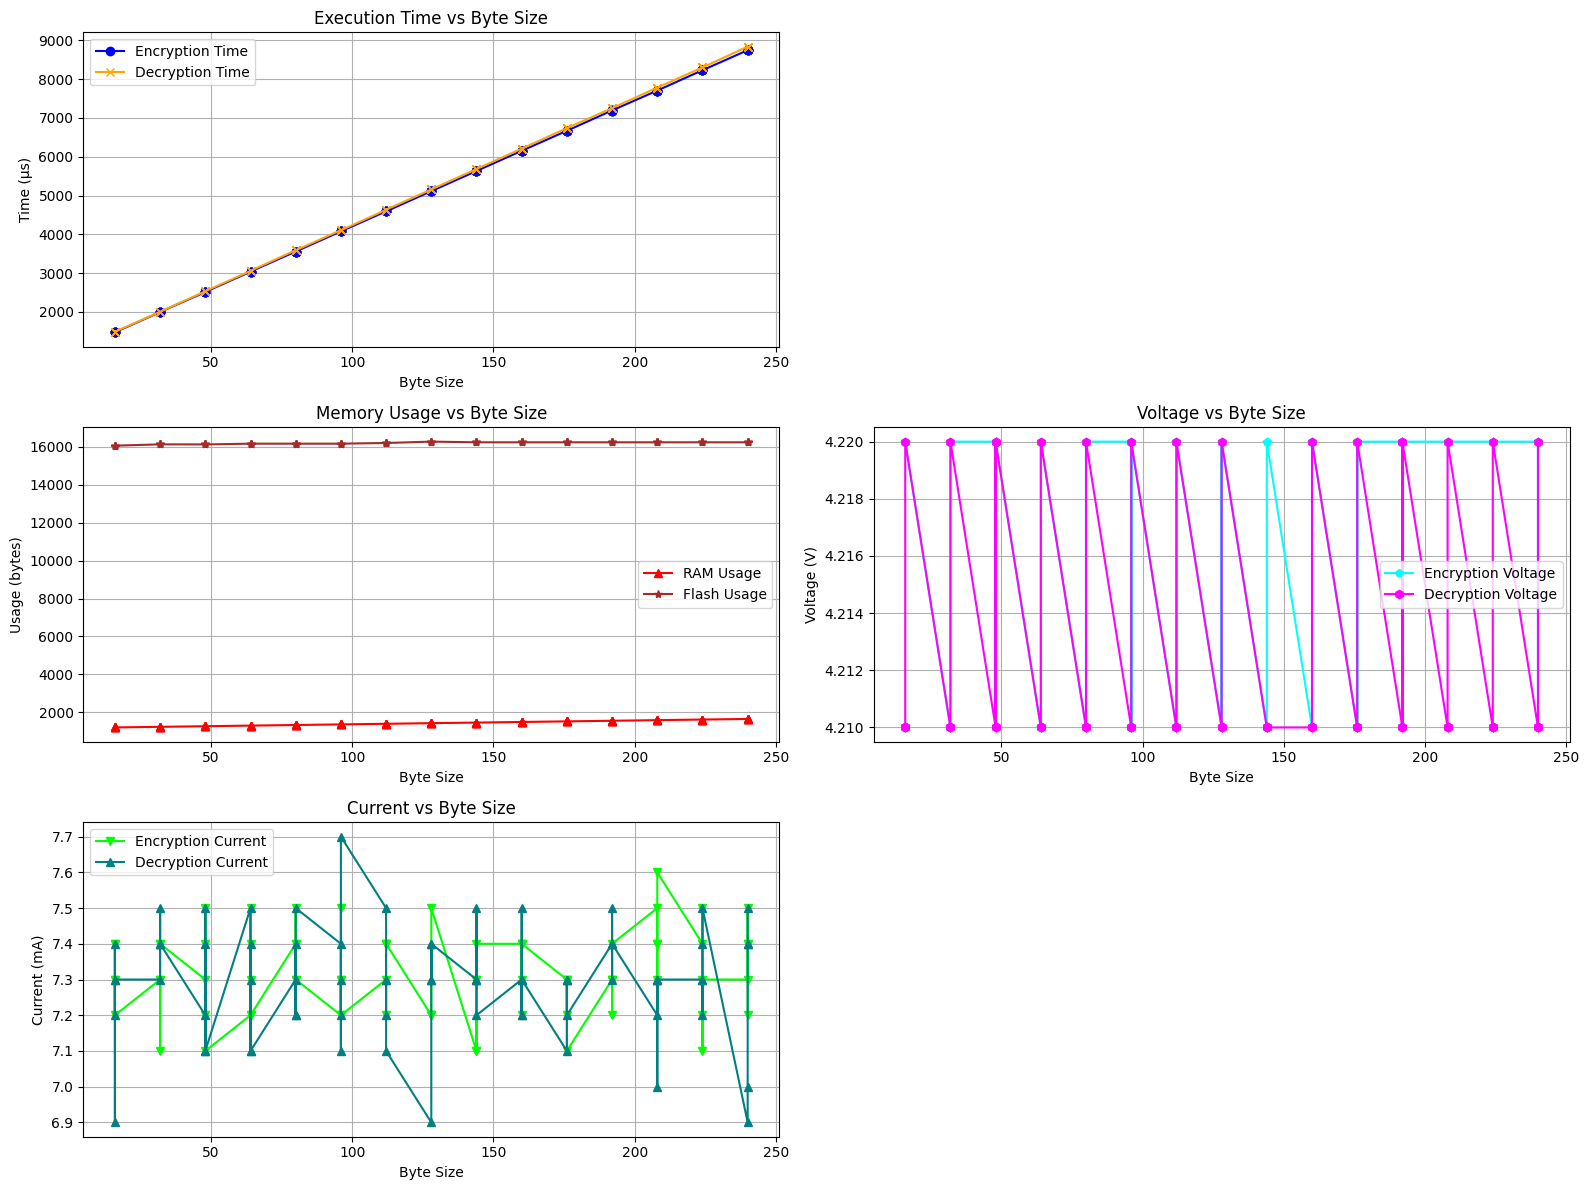

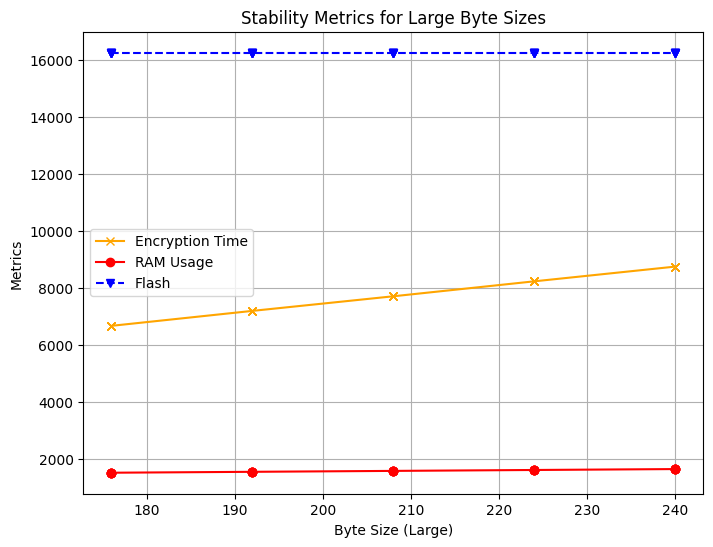

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kruskal

# Load the dataset
file_path = "nomean_skinny384_data.xlsx"  # Replace with your file name
data = pd.read_excel(file_path)

# Display structure of dataset
print(data.head())

# Define columns
byte_sizes = data["Byte Size"]
flash_usages = data["Flash (bytes)"]
ram_usages = data["RAM (bytes)"]
encryption_times = data["Encryption Time (\u00b5s)"]
decryption_times = data["Decryption Time (\u00b5s)"]
encryption_voltages = data["Encryption Voltage (V)"]
encryption_currents = data["Encryption Current (mA)"]
encryption_powers = data["Encryption Power (W)"]
decryption_voltages = data["Decryption Voltage (V)"]
decryption_currents = data["Decryption Current (mA)"]
decryption_powers = data["Decryption Power (W)"]

# Define groups for Kruskal-Wallis based on byte size thresholds
threshold = byte_sizes.max() * 0.7  # Define "large" as the top 30% of byte sizes
group_large = data[data["Byte Size"] >= threshold]
group_small = data[data["Byte Size"] < threshold]

# Perform Kruskal-Wallis test for each performance metric
kruskal_results = {
    "Flash": kruskal(group_large["Flash (bytes)"], group_small["Flash (bytes)"]),
    "RAM": kruskal(group_large["RAM (bytes)"], group_small["RAM (bytes)"]),
    "Encryption Time": kruskal(group_large["Encryption Time (\u00b5s)"], group_small["Encryption Time (\u00b5s)"]),
    "Decryption Time": kruskal(group_large["Decryption Time (\u00b5s)"], group_small["Decryption Time (\u00b5s)"]),
    "Encryption Voltage": kruskal(group_large["Encryption Voltage (V)"], group_small["Encryption Voltage (V)"]),
    "Decryption Voltage": kruskal(group_large["Decryption Voltage (V)"], group_small["Decryption Voltage (V)"]),
    "Encryption Current": kruskal(group_large["Encryption Current (mA)"], group_small["Encryption Current (mA)"]),
    "Decryption Current": kruskal(group_large["Decryption Current (mA)"], group_small["Decryption Current (mA)"]),
    # "Encryption Power": kruskal(group_large["Encryption Power (W)"], group_small["Encryption Power (W)"]),
    # "Decryption Power": kruskal(group_large["Decryption Power (W)"], group_small["Decryption Power (W)"]),
}

print("Kruskal-Wallis Test Results:")
for metric, result in kruskal_results.items():
    print(f"{metric}: statistic={result.statistic:.3f}, p-value={result.pvalue:.3e}")

# Plot trends to visualize performance
plt.figure(figsize=(16, 12))

# Execution Time vs Byte Size
plt.subplot(3, 2, 1)
plt.plot(byte_sizes, encryption_times, marker='o', color='b', label="Encryption Time")
plt.plot(byte_sizes, decryption_times, marker='x', color='orange', label="Decryption Time")
plt.title("Execution Time vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Time (\u00b5s)")
plt.legend()
plt.grid(True)

# # Power Usage vs Byte Size
# plt.subplot(3, 2, 2)
# plt.plot(byte_sizes, encryption_powers, marker='s', color='g', label="Encryption Power")
# plt.plot(byte_sizes, decryption_powers, marker='d', color='purple', label="Decryption Power")
# plt.title("Power Usage vs Byte Size")
# plt.xlabel("Byte Size")
# plt.ylabel("Power (W)")
# plt.legend()
# plt.grid(True)

# Memory Usage vs Byte Size
plt.subplot(3, 2, 3)
plt.plot(byte_sizes, ram_usages, marker='^', color='r', label="RAM Usage")
plt.plot(byte_sizes, flash_usages, marker='*', color='brown', label="Flash Usage")
plt.title("Memory Usage vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Usage (bytes)")
plt.legend()
plt.grid(True)

# Voltage vs Byte Size
plt.subplot(3, 2, 4)
plt.plot(byte_sizes, encryption_voltages, marker='p', color='cyan', label="Encryption Voltage")
plt.plot(byte_sizes, decryption_voltages, marker='h', color='magenta', label="Decryption Voltage")
plt.title("Voltage vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Voltage (V)")
plt.legend()
plt.grid(True)

# Current vs Byte Size
plt.subplot(3, 2, 5)
plt.plot(byte_sizes, encryption_currents, marker='v', color='lime', label="Encryption Current")
plt.plot(byte_sizes, decryption_currents, marker='^', color='teal', label="Decryption Current")
plt.title("Current vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Current (mA)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Stability Check for Large Data
plt.figure(figsize=(8, 6))
plt.plot(group_large["Byte Size"], group_large["Encryption Time (\u00b5s)"], marker='x', linestyle='-', color='orange', label="Encryption Time")
# plt.plot(group_large["Byte Size"], group_large["Encryption Power (W)"], marker='d', linestyle='--', color='purple', label="Encryption Power")
plt.plot(group_large["Byte Size"], group_large["RAM (bytes)"], marker='o', linestyle='-', color='red', label="RAM Usage")
plt.plot(group_large["Byte Size"], group_large["Flash (bytes)"], marker='v', linestyle='--', color='blue', label="Flash")
plt.title("Stability Metrics for Large Byte Sizes")
plt.xlabel("Byte Size (Large)")
plt.ylabel("Metrics")
plt.grid(True)
plt.legend()
plt.show()


# SKINNY64

Generate 6464

In [ ]:
import os

# Folder output utama
code_folders = ["skinny64rfidaa", "skinny64rfidbb", "skinny64rfidcc", "skinny64rfiddd", "skinny64rfidee"]

# Buat folder utama jika belum ada
for folder in code_folders:
    os.makedirs(folder, exist_ok=True)

def generate_code_with_decrementing_plaintext(file_path, id_values):
    # Template kode Arduino
    code_template = f'''
#include <SPI.h>
#include <MFRC522.h>
#include <Wire.h>
#include <Adafruit_INA219.h>
#include "Skinny64.h"
#include <string.h>
#include <MemoryFree.h>
#include <LiquidCrystal_I2C.h> 

#define SS_PIN 10
#define RST_PIN 9

MFRC522 rfid(SS_PIN, RST_PIN);
Adafruit_INA219 ina219;
LiquidCrystal_I2C lcd(0x27, 16, 2);

Skinny64_64 skinny;
byte ciphertext[{id_values}];
byte decryptedtext[{id_values}];
unsigned long encryptionTime;
unsigned long decryptionTime;

byte buffer[8];

float encryptionVoltage;
float encryptionCurrent;
float decryptionVoltage;
float decryptionCurrent;

const byte key[8] = {{0x1f, 0x1e, 0x1d, 0x1c, 0x1b, 0x1a, 0x19, 0x18}};


void encryptAndMeasure(BlockCipher *cipher, const byte *key, size_t keySize, byte *plaintext, size_t plaintextSize) {{
  unsigned long startTime = micros();
  cipher->setKey(key, keySize);

  for (size_t i = 0; i < plaintextSize; i += 8) {{
    cipher->encryptBlock(buffer, &plaintext[i]);
    memcpy(&ciphertext[i], buffer, 8);
  }}

  unsigned long endTime = micros();
  encryptionVoltage = ina219.getBusVoltage_V();
  encryptionCurrent = ina219.getCurrent_mA();
  encryptionTime = endTime - startTime;

  // Output encrypted data (ciphertext)
  Serial.print(F("Ciphertext: "));
  for (size_t i = 0; i < plaintextSize; i++) {{
    if (ciphertext[i] < 0x10) Serial.print("0");
    Serial.print(ciphertext[i], HEX);
    Serial.print(" ");
  }}
  Serial.println();
  Serial.print(F("Encryption Completed in "));
  Serial.print(encryptionTime);
  Serial.println(F(" microseconds"));
}}

void decryptAndMeasure(BlockCipher *cipher, const byte *key, size_t keySize, byte *ciphertext, size_t ciphertextSize) {{
    unsigned long startdecTime = micros();
    cipher->setKey(key, keySize);

    for (size_t i = 0; i < ciphertextSize; i += 8) {{
        cipher->decryptBlock(buffer, &ciphertext[i]);
        memcpy(&decryptedtext[i], buffer, 8);
    }}

    unsigned long enddecTime = micros();
    decryptionVoltage = ina219.getBusVoltage_V();
    decryptionCurrent = ina219.getCurrent_mA();
    decryptionTime = enddecTime - startdecTime;

    // Output decrypted data
    Serial.print(F("Decrypted Text: "));
    for (size_t i = 0; i < ciphertextSize; i++) {{
        if (decryptedtext[i] < 0x10) Serial.print("0");
        Serial.print(decryptedtext[i], HEX);
        Serial.print(" ");
    }}
    Serial.println();
    Serial.print(F("Decryption Completed in "));
    Serial.print(decryptionTime);
    Serial.println(F(" microseconds"));
}}

void displayData() {{
    float encryptionPower = encryptionVoltage * (encryptionCurrent / 1000);
    float decryptionPower = decryptionVoltage * (decryptionCurrent / 1000);
    int memoryUsage = 2048 - freeMemory();

    Serial.print(F("Memory Usage = "));
    Serial.print(memoryUsage);
    Serial.println(F(" B"));

    Serial.print(F("Encryption Voltage: "));
    Serial.print(encryptionVoltage);
    Serial.println(F(" V"));
    Serial.print(F("Encryption Current: "));
    Serial.print(encryptionCurrent);
    Serial.println(F(" mA"));
    Serial.print(F("Encryption Power: "));
    Serial.print(encryptionPower);
    Serial.println(F(" W"));
    
    Serial.print(F("Decryption Voltage: "));
    Serial.print(decryptionVoltage);
    Serial.println(F(" V"));
    Serial.print(F("Decryption Current: "));
    Serial.print(decryptionCurrent);
    Serial.println(F(" mA"));
    Serial.print(F("Decryption Power: "));
    Serial.print(decryptionPower);
    Serial.println(F(" W"));

    Serial.println(F("selesai"));
}}

void setup() {{
    Serial.begin(9600);
    SPI.begin();
    rfid.PCD_Init();
    ina219.begin();
    
    lcd.begin(16, 2);
    lcd.backlight();
    lcd.setCursor(0, 0);
    lcd.print("RFID System Ready");
    delay(2000);
    lcd.clear();
}}

void loop() {{
    if (rfid.PICC_IsNewCardPresent() && rfid.PICC_ReadCardSerial()) {{
        byte cardID[{id_values}] = {{0}};
        size_t idLength = rfid.uid.size;

        for (byte i = 0; i < idLength && i < {id_values}; i++) {{
            cardID[i] = rfid.uid.uidByte[i];
        }}

        if (idLength < {id_values}) {{
            memset(&cardID[idLength], 0, {id_values} - idLength);
        }}

        lcd.clear();
        lcd.setCursor(0, 0);
        lcd.print("RFID Detected!");
        lcd.setCursor(0, 1);
        lcd.print("Encrypting...");

        encryptAndMeasure(&skinny, key, sizeof(key), cardID, {id_values});
        decryptAndMeasure(&skinny, key, sizeof(key), ciphertext, {id_values});
        displayData();

        lcd.clear();
        lcd.setCursor(0, 0);
        lcd.print("Encryption Done!");
        delay(2000);
        lcd.clear();
    }}
}}
'''

    with open(file_path, 'w') as file:
        file.write(code_template)

    print(f"Code with {id_values}-byte plaintext has been written to {file_path}")

# Generate folders and codes
for folder in code_folders:
    for i in range(384, 311, -8):
        filename = f"skinny64_{i}"
        sketch_folder = os.path.join(folder, filename)
        os.makedirs(sketch_folder, exist_ok=True)  # Membuat folder untuk setiap file

        file_path = os.path.join(sketch_folder, f"{filename}.ino")

        generate_code_with_decrementing_plaintext(file_path, i)


Running SKINNY6464

In [ ]:
# Configuration
port = "COM8"
baud_rate = 9600
base_folders = ["skinny64rfidaa", "skinny64rfidbb", "skinny64rfidcc", "skinny64rfiddd", "skinny64rfidee"]

log_folder = "logs_skinny64_multi"
arduino_cli_path = r"C:\Program Files\Arduino IDE\resources\app\lib\backend\resources\arduino-cli.exe"

# Create log folder if it doesn't exist
os.makedirs(log_folder, exist_ok=True)

# Timeout duration in seconds for each phase
COMPILE_TIMEOUT = 60
UPLOAD_TIMEOUT = 30
SERIAL_TIMEOUT = 10


def parse_serial_data(serial_line):
    """
    Parse the serial data and return structured information.
    """
    if "Ciphertext" in serial_line:
        match = re.search(r"Ciphertext: (.+)", serial_line)
        return {"Ciphertext": match.group(1)} if match else None
    elif "Encryption Completed" in serial_line:
        match = re.search(r"Encryption Completed in (\d+) microseconds", serial_line)
        return {"Encryption Time": int(match.group(1))} if match else None
    elif "Decrypted Text" in serial_line:
        match = re.search(r"Decrypted Text: (.+)", serial_line)
        return {"Decrypted Text": match.group(1)} if match else None
    elif "Decryption Completed" in serial_line:
        match = re.search(r"Decryption Completed in (\d+) microseconds", serial_line)
        return {"Decryption Time": int(match.group(1))} if match else None
    elif "Memory Usage" in serial_line:
        match = re.search(r"Memory Usage = (\d+) B", serial_line)
        return {"Memory Usage (B)": int(match.group(1))} if match else None
    elif "Encryption Voltage" in serial_line:
        match = re.search(r"Encryption Voltage: ([\d.]+) V", serial_line)
        return {"Encryption Voltage (V)": float(match.group(1))} if match else None
    elif "Encryption Current" in serial_line:
        match = re.search(r"Encryption Current: ([\d.]+) mA", serial_line)
        return {"Encryption Current (mA)": float(match.group(1))} if match else None
    elif "Encryption Power" in serial_line:
        match = re.search(r"Encryption Power: ([\d.]+) W", serial_line)
        return {"Encryption Power (W)": float(match.group(1))} if match else None
    elif "Decryption Voltage" in serial_line:
        match = re.search(r"Decryption Voltage: ([\d.]+) V", serial_line)
        return {"Decryption Voltage (V)": float(match.group(1))} if match else None
    elif "Decryption Current" in serial_line:
        match = re.search(r"Decryption Current: ([\d.]+) mA", serial_line)
        return {"Decryption Current (mA)": float(match.group(1))} if match else None
    elif "Decryption Power" in serial_line:
        match = re.search(r"Decryption Power: ([\d.]+) W", serial_line)
        return {"Decryption Power (W)": float(match.group(1))} if match else None
    elif "selesai" in serial_line.lower():
        return {"Status": "Process Completed"}
    return {"Raw": serial_line.strip()}


def compile_and_upload(sketch_name, sketch_path):
    log_file = os.path.join(log_folder, f"{sketch_name}_output.txt")
    
    try:
        # Compile code to get storage information
        compile_command = [arduino_cli_path, "compile", "--fqbn", "arduino:avr:nano", sketch_path]
        result = subprocess.run(compile_command, capture_output=True, text=True, timeout=COMPILE_TIMEOUT)
        
        # Retrieve storage information from compilation output
        flash_match = re.search(r"Sketch uses (\d+) bytes.*Maximum is (\d+) bytes", result.stdout)
        ram_match = re.search(r"Global variables use (\d+) bytes.*Maximum is (\d+) bytes", result.stdout)
        flash_usage = f"{flash_match.group(1)} / {flash_match.group(2)} bytes" if flash_match else "Unknown"
        ram_usage = f"{ram_match.group(1)} / {ram_match.group(2)} bytes" if ram_match else "Unknown"

        print(f"{sketch_name} - Flash: {flash_usage}, RAM: {ram_usage}")

        # Log Flash and RAM info
        with open(log_file, "w", encoding="utf-8") as f:
            f.write(f"{sketch_name} - Flash: {flash_usage}, RAM: {ram_usage}\n\n")

        # Upload code to Arduino
        upload_command = [arduino_cli_path, "upload", "-p", port, "--fqbn", "arduino:avr:nano", sketch_path]
        subprocess.run(upload_command, timeout=UPLOAD_TIMEOUT)

        time.sleep(2)  # Wait after upload

    except subprocess.TimeoutExpired:
        print(f"Error: {sketch_name} - Compilation or upload timed out.")
    except Exception as e:
        print(f"Error: {sketch_name} - {e}")

    # Read from Serial Monitor and log to file
    try:
        with serial.Serial(port, baud_rate, timeout=1) as ser, open(log_file, "a", encoding="utf-8") as f:
            start_time = time.time()
            while time.time() - start_time < SERIAL_TIMEOUT:
                if ser.in_waiting > 0:
                    line = ser.readline().decode("utf-8", errors="ignore").strip()
                    parsed_line = parse_serial_data(line)
                    print(parsed_line)
                    f.write(str(parsed_line) + "\n")
                    if "Status" in parsed_line and parsed_line["Status"] == "Process Completed":
                        print(f"Detected completion for {sketch_name}.")
                        return
    except serial.SerialException as e:
        print(f"Serial Error: {sketch_name} - {e}")
    except Exception as e:
        print(f"Error while reading serial: {sketch_name} - {e}")


# Loop through each base folder
for base_folder in base_folders:
    subfolders = sorted(
        [folder for folder in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, folder))],
        key=lambda x: int(x.split('_')[1])  # Extract number after "128_" and sort numerically
    )

    for folder_name in subfolders:
        sketch_path = os.path.join(base_folder, folder_name, f"{folder_name}.ino")
        if os.path.isfile(sketch_path):
            print(f"Running {folder_name} in {base_folder}...")
            compile_and_upload(f"{base_folder}_{folder_name}", sketch_path)
            print(f"Completed {folder_name} in {base_folder}\n")
        else:
            print(f"File {folder_name}.ino not found in {folder_name} within {base_folder}")


CSV64

In [10]:
import ast  # Import untuk evaluasi literal
import pandas as pd
from glob import glob

# Konfigurasi
log_folder = "logs_skinny64_multi"
output_csv = "nomean_skinny64_data.csv"

# Ukuran byte yang sesuai dengan file log
byte_sizes = [8, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256, 272, 288, 304, 320, 336, 352, 360, 368, 376, 384]

# List untuk menyimpan data hasil pemrosesan
data_list = []

for byte_size in byte_sizes:
    files = glob(f"{log_folder}/*_{byte_size}_output*")
    if not files:
        print(f"No log files found for byte size: {byte_size}")
        continue

    print(f"Processing byte size: {byte_size}...")

    for file in files:
        try:
            flash_value = ram_value = encryption_time = decryption_time = None
            encryption_voltage = encryption_current = encryption_power = None
            decryption_voltage = decryption_current = decryption_power = None

            with open(file, 'r') as f:
                for line in f:
                    line = line.strip()

                    if "Flash:" in line:
                        try:
                            flash_value = int(line.split("Flash:")[1].split('/')[0].strip())
                        except Exception as e:
                            print(f"Error parsing Flash in line: {line} - {e}")

                    elif "'Encryption Time" in line:
                        try:
                            data = ast.literal_eval(line)
                            if "Encryption Time" in data:
                                encryption_time = int(data["Encryption Time"])
                        except Exception as e:
                            print(f"Error parsing Encryption Time in line: {line} - {e}")

                    elif "'Decryption Time':" in line:
                        try:
                            data = ast.literal_eval(line)
                            if "Decryption Time" in data:
                                decryption_time = int(data["Decryption Time"])
                        except Exception as e:
                            print(f"Error parsing Decryption Time in line: {line} - {e}")

                    elif "Memory Usage:" in line or "Memory Usage (B)" in line:
                        try:
                            data = ast.literal_eval(line)
                            if "Memory Usage (B)" in data:
                                ram_value = int(data["Memory Usage (B)"])
                        except Exception as e:
                            print(f"Error parsing RAM in line: {line} - {e}")

                    elif "Voltage" in line or "Current" in line or "Power" in line:
                        try:
                            data = ast.literal_eval(line)
                            if "Encryption Voltage (V)" in data:
                                encryption_voltage = float(data["Encryption Voltage (V)"])
                            if "Encryption Current (mA)" in data:
                                encryption_current = float(data["Encryption Current (mA)"])
                            if "Encryption Power (W)" in data:
                                encryption_power = float(data["Encryption Power (W)"])
                            if "Decryption Voltage (V)" in data:
                                decryption_voltage = float(data["Decryption Voltage (V)"])
                            if "Decryption Current (mA)" in data:
                                decryption_current = float(data["Decryption Current (mA)"])
                            if "Decryption Power (W)" in data:
                                decryption_power = float(data["Decryption Power (W)"])
                        except Exception as e:
                            print(f"Error parsing Voltage/Current/Power in line: {line} - {e}")

            # Tambahkan data ke list
            data_list.append({
                "Byte Size": byte_size,
                "File Name": file,
                "Flash (bytes)": flash_value,
                "RAM (bytes)": ram_value,
                "Encryption Time (µs)": encryption_time,
                "Decryption Time (µs)": decryption_time,
                "Encryption Voltage (V)": encryption_voltage,
                "Encryption Current (mA)": encryption_current,
                "Encryption Power (W)": encryption_power,
                "Decryption Voltage (V)": decryption_voltage,
                "Decryption Current (mA)": decryption_current,
                "Decryption Power (W)": decryption_power,
            })

        except Exception as e:
            print(f"Error reading file {file}: {e}")

# Simpan data ke CSV
df = pd.DataFrame(data_list)
df.to_csv(output_csv, index=False)

# Tampilkan beberapa data
print(df.head())


Processing byte size: 8...
Processing byte size: 16...
Processing byte size: 32...
Processing byte size: 48...
Processing byte size: 64...
Processing byte size: 80...
Processing byte size: 96...
Processing byte size: 112...
Processing byte size: 128...
Processing byte size: 144...
Processing byte size: 160...
Processing byte size: 176...
Processing byte size: 192...
Processing byte size: 208...
Processing byte size: 224...
Processing byte size: 240...
Processing byte size: 256...
Processing byte size: 272...
Processing byte size: 288...
Processing byte size: 304...
Processing byte size: 320...
Processing byte size: 336...
Processing byte size: 352...
Processing byte size: 360...
Processing byte size: 368...
Processing byte size: 376...
Processing byte size: 384...
   Byte Size                                          File Name  \
0          8  logs_skinny64_multi\skinny64rfida_skinny64_8_o...   
1          8  logs_skinny64_multi\skinny64rfidb_skinny64_8_o...   
2          8  logs_skinn

OUTPUT

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Membaca data dari CSV (sesuaikan path jika diperlukan)
file_path = 'processed_skinny64_data.csv'
data = pd.read_csv(file_path)

# Grafik 1: Byte Size vs Encryption Time
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Encryption Time (µs)'], marker='o', label='Encryption Time (µs)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Encryption Time (µs)')
plt.title('Byte Size vs Encryption Time')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 2: Byte Size vs Decryption Time
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Decryption Time (µs)'], marker='o', label='Decryption Time (µs)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Decryption Time (µs)')
plt.title('Byte Size vs Decryption Time')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 3: Byte Size vs Encryption & Decryption Time
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Encryption Time (µs)'], marker='o', label='Encryption Time (µs)')
plt.plot(data['Byte Size'], data['Avg Decryption Time (µs)'], marker='o', label='Decryption Time (µs)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Time (µs)')
plt.title('Byte Size vs Encryption & Decryption Time')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 4: Byte Size vs Flash
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Flash (bytes)'], marker='o', label='Flash (bytes)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Flash (bytes)')
plt.title('Byte Size vs Flash')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 5: Byte Size vs RAM
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg RAM (bytes)'], marker='o', label='RAM (bytes)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('RAM (bytes)')
plt.title('Byte Size vs RAM')
plt.grid(True)
plt.legend()
plt.show()

# # Grafik 6: Byte Size vs Encryption Voltage
# plt.figure(figsize=(8, 6))
# plt.plot(data['Byte Size'], data['Avg Encryption Voltage (V)'], marker='o', label='Encryption Voltage (V)')
# plt.xlabel('Byte Size (bytes)')
# plt.ylabel('Voltage (V)')
# plt.title('Byte Size vs Encryption Voltage')
# plt.grid(True)
# plt.legend()
# plt.show()

# # Grafik 7: Byte Size vs Encryption Current
# plt.figure(figsize=(8, 6))
# plt.plot(data['Byte Size'], data['Avg Encryption Current (A)'], marker='o', label='Encryption Current (A)')
# plt.xlabel('Byte Size (bytes)')
# plt.ylabel('Current (A)')
# plt.title('Byte Size vs Encryption Current')
# plt.grid(True)
# plt.legend()
# plt.show()

# # Grafik 8: Byte Size vs Encryption Power
# plt.figure(figsize=(8, 6))
# plt.plot(data['Byte Size'], data['Avg Encryption Power (W)'], marker='o', label='Encryption Power (W)')
# plt.xlabel('Byte Size (bytes)')
# plt.ylabel('Power (W)')
# plt.title('Byte Size vs Encryption Power')
# plt.grid(True)
# plt.legend()
# plt.show()

# Grafik 9: Byte Size vs Encryption Voltage dan Decryption Voltage
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Encryption Voltage (V)'], marker='o', label='Encryption Voltage (V)')
plt.plot(data['Byte Size'], data['Avg Decryption Voltage (V)'], marker='h', label='Decryption Voltage (V)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Voltage (V)')
plt.title('Byte Size vs Encryption Voltage & Decryption Voltage')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 10: Byte Size vs Encryption Current dan Duplicate Current
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Encryption Current (mA)'], marker='o', label='Encryption Current (mA)')
plt.plot(data['Byte Size'], data['Avg Decryption Current (mA)'], marker='h', label='Decryption Current (mA)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Current (A)')
plt.title('Byte Size vs Encryption Current & Decryption Current')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 11: Byte Size vs Encryption Power dan Duplicate Power
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Encryption Power (W)'], marker='o', label='Encryption Power (W)')
plt.plot(data['Byte Size'], data['Avg Decryption Power (W)'], marker='h', label='Decryption Power (W)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Power (W)')
plt.title('Byte Size vs Encryption Power & Decryption Power')
plt.grid(True)
plt.legend()
plt.show()


KW 64

RM2

In [8]:

# Load dataset
file_path = "nomean_skinny64_data.xlsx"  # Replace with your file path
data = pd.read_excel(file_path)

# Display the structure of the dataset
print(data.head())

# Define columns for analysis
byte_sizes = data["Byte Size"].unique()  # Unique byte sizes

# Group data by byte size for Kruskal-Wallis analysis
grouped_flash_usages = [data[data["Byte Size"] == b]["Flash (bytes)"].dropna() for b in byte_sizes]
grouped_ram_usages = [data[data["Byte Size"] == b]["RAM (bytes)"].dropna() for b in byte_sizes]
grouped_encryption_times = [data[data["Byte Size"] == b]["Encryption Time (µs)"].dropna() for b in byte_sizes]
grouped_decryption_times = [data[data["Byte Size"] == b]["Decryption Time (µs)"].dropna() for b in byte_sizes]
grouped_encryption_powers = [data[data["Byte Size"] == b]["Encryption Power (W)"].dropna() for b in byte_sizes]
grouped_decryption_powers = [data[data["Byte Size"] == b]["Decryption Power (W)"].dropna() for b in byte_sizes]

# Perform Kruskal-Wallis test for each metric
kw_flash_usage = kruskal(*grouped_flash_usages)
kw_ram_usage = kruskal(*grouped_ram_usages)
kw_encryption_time = kruskal(*grouped_encryption_times)
kw_decryption_time = kruskal(*grouped_decryption_times)
kw_encryption_power = kruskal(*grouped_encryption_powers)
kw_decryption_power = kruskal(*grouped_decryption_powers)

# Display results
print("Kruskal-Wallis Test Results:")
print(f"Flash Usage: H-statistic = {kw_flash_usage.statistic}, p-value = {kw_flash_usage.pvalue}")
print(f"RAM Usage: H-statistic = {kw_ram_usage.statistic}, p-value = {kw_ram_usage.pvalue}")
print(f"Encryption Time: H-statistic = {kw_encryption_time.statistic}, p-value = {kw_encryption_time.pvalue}")
print(f"Decryption Time: H-statistic = {kw_decryption_time.statistic}, p-value = {kw_decryption_time.pvalue}")
print(f"Encryption Power: H-statistic = {kw_encryption_power.statistic}, p-value = {kw_encryption_power.pvalue}")
print(f"Decryption Power: H-statistic = {kw_decryption_power.statistic}, p-value = {kw_decryption_power.pvalue}")

# Interpretation
if kw_flash_usage.pvalue < 0.05:
    print("Significant difference found in Flash Usage across byte sizes.")
else:
    print("No significant difference in Flash Usage across byte sizes.")

if kw_ram_usage.pvalue < 0.05:
    print("Significant difference found in RAM Usage across byte sizes.")
else:
    print("No significant difference in RAM Usage across byte sizes.")

if kw_encryption_time.pvalue < 0.05:
    print("Significant difference found in Encryption Time across byte sizes.")
else:
    print("No significant difference in Encryption Time across byte sizes.")

if kw_decryption_time.pvalue < 0.05:
    print("Significant difference found in Decryption Time across byte sizes.")
else:
    print("No significant difference in Decryption Time across byte sizes.")

if kw_encryption_power.pvalue < 0.05:
    print("Significant difference found in Encryption Power across byte sizes.")
else:
    print("No significant difference in Encryption Power across byte sizes.")

if kw_decryption_power.pvalue < 0.05:
    print("Significant difference found in Decryption Power across byte sizes.")
else:
    print("No significant difference in Decryption Power across byte sizes.")


   Byte Size                                          File Name  \
0          8  logs_skinny64_multi\skinny64rfida_skinny64_8_o...   
1          8  logs_skinny64_multi\skinny64rfidb_skinny64_8_o...   
2          8  logs_skinny64_multi\skinny64rfidc_skinny64_8_o...   
3          8  logs_skinny64_multi\skinny64rfidd_skinny64_8_o...   
4          8  logs_skinny64_multi\skinny64rfide_skinny64_8_o...   

   Flash (bytes)  RAM (bytes)  Encryption Time (µs)  Decryption Time (µs)  \
0          15314        815.0                   312                   312   
1          15314        815.0                   312                   312   
2          15314        815.0                   312                   312   
3          15314        815.0                   312                   312   
4          15314        815.0                   312                   312   

   Encryption Voltage (V)  Encryption Current (mA)  Encryption Power (W)  \
0                    3.97                      6.1        

C:\Users\Ghifari\AppData\Local\Temp\ipykernel_16708\1743144374.py:21: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  kw_ram_usage = kruskal(*grouped_ram_usages)
C:\Users\Ghifari\AppData\Local\Temp\ipykernel_16708\1743144374.py:24: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  kw_encryption_power = kruskal(*grouped_encryption_powers)
C:\Users\Ghifari\AppData\Local\Temp\ipykernel_16708\1743144374.py:25: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  kw_decryption_power = kruskal(*grouped_decryption_powers)


RM3

   Byte Size                                          File Name  \
0          8  logs_skinny64_multi\skinny64rfida_skinny64_8_o...   
1          8  logs_skinny64_multi\skinny64rfidb_skinny64_8_o...   
2          8  logs_skinny64_multi\skinny64rfidc_skinny64_8_o...   
3          8  logs_skinny64_multi\skinny64rfidd_skinny64_8_o...   
4          8  logs_skinny64_multi\skinny64rfide_skinny64_8_o...   

   Flash (bytes)  RAM (bytes)  Encryption Time (µs)  Decryption Time (µs)  \
0          15314        815.0                   312                   312   
1          15314        815.0                   312                   312   
2          15314        815.0                   312                   312   
3          15314        815.0                   312                   312   
4          15314        815.0                   312                   312   

   Encryption Voltage (V)  Encryption Current (mA)  Encryption Power (W)  \
0                    3.97                      6.1        

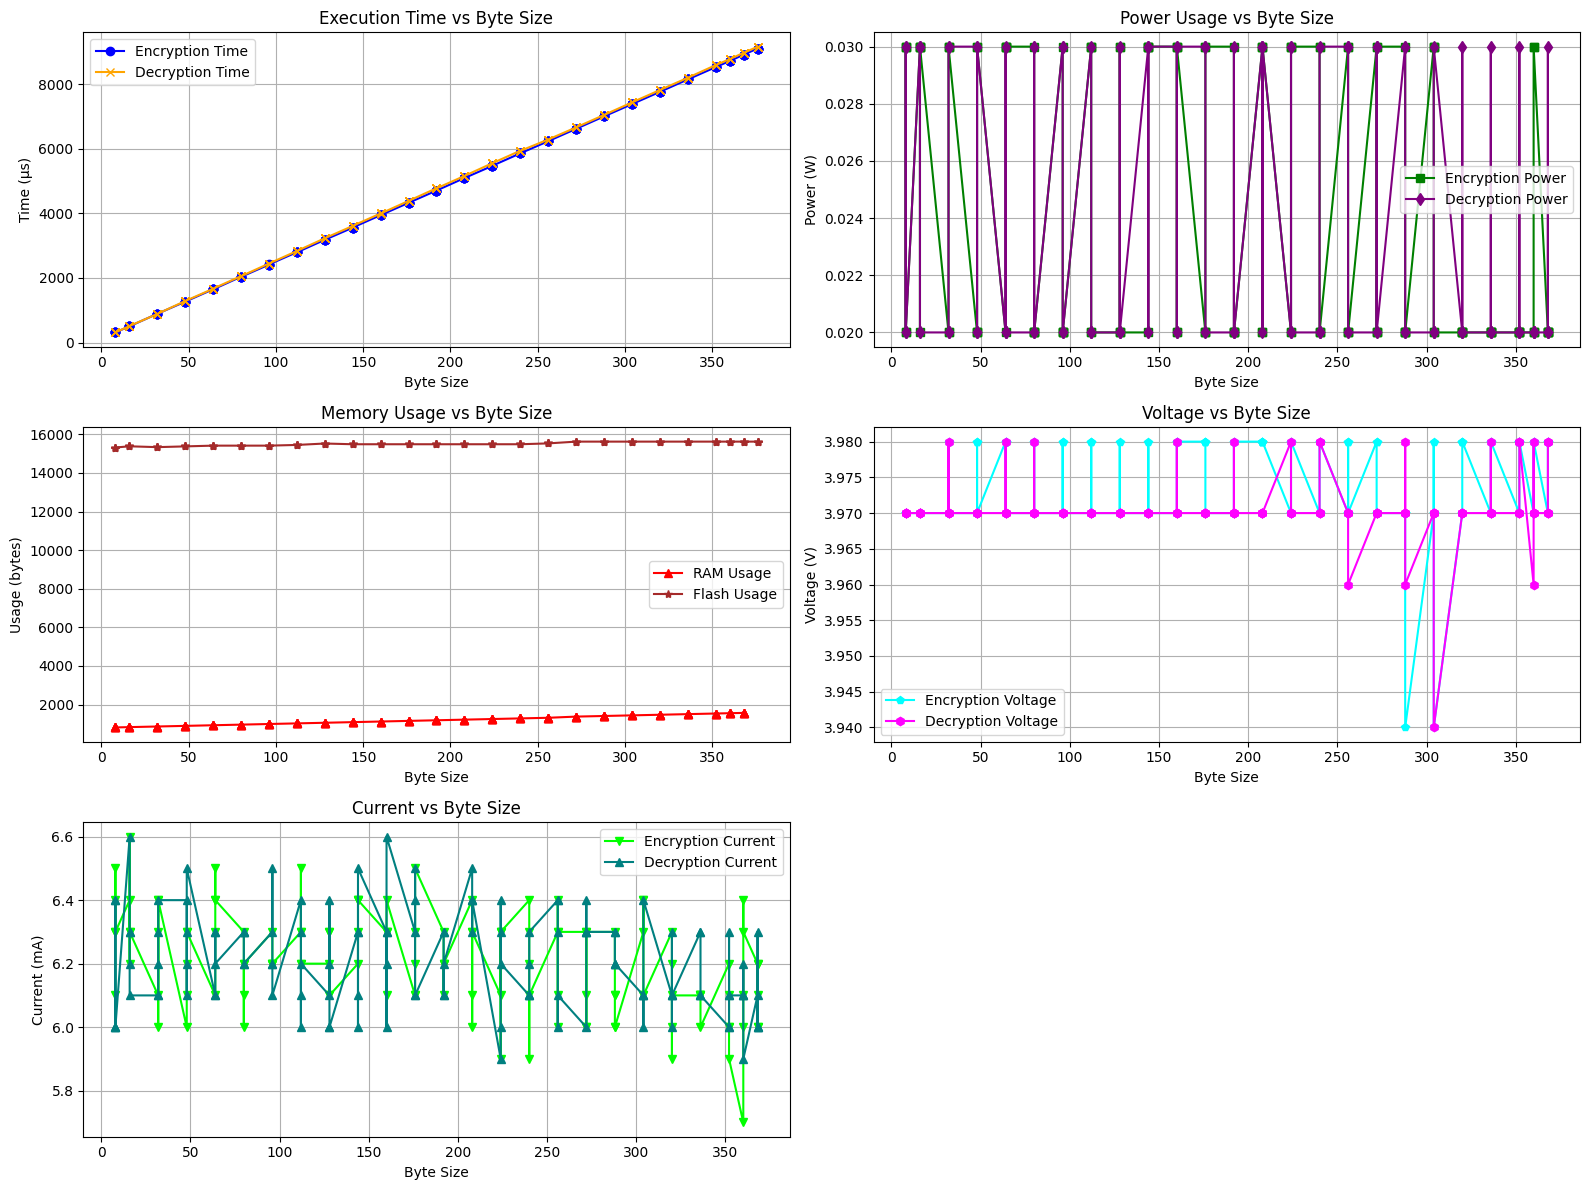

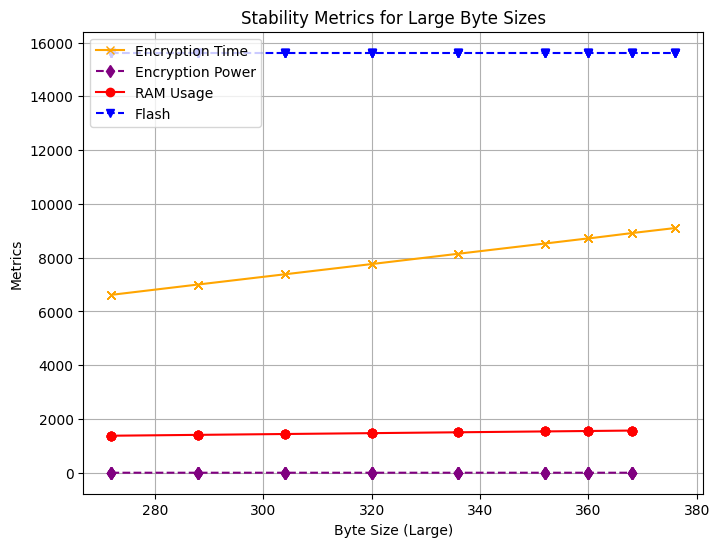

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kruskal

# Load the dataset
file_path = "nomean_skinny64_data.xlsx"  # Replace with your file name
data = pd.read_excel(file_path)

# Display structure of dataset
print(data.head())

# Define columns
byte_sizes = data["Byte Size"]
flash_usages = data["Flash (bytes)"]
ram_usages = data["RAM (bytes)"]
encryption_times = data["Encryption Time (\u00b5s)"]
decryption_times = data["Decryption Time (\u00b5s)"]
encryption_voltages = data["Encryption Voltage (V)"]
encryption_currents = data["Encryption Current (mA)"]
encryption_powers = data["Encryption Power (W)"]
decryption_voltages = data["Decryption Voltage (V)"]
decryption_currents = data["Decryption Current (mA)"]
decryption_powers = data["Decryption Power (W)"]

# Define groups for Kruskal-Wallis based on byte size thresholds
threshold = byte_sizes.max() * 0.7  # Define "large" as the top 30% of byte sizes
group_large = data[data["Byte Size"] >= threshold]
group_small = data[data["Byte Size"] < threshold]

# Perform Kruskal-Wallis test for each performance metric
kruskal_results = {
    "Flash": kruskal(group_large["Flash (bytes)"], group_small["Flash (bytes)"]),
    "RAM": kruskal(group_large["RAM (bytes)"], group_small["RAM (bytes)"]),
    "Encryption Time": kruskal(group_large["Encryption Time (\u00b5s)"], group_small["Encryption Time (\u00b5s)"]),
    "Decryption Time": kruskal(group_large["Decryption Time (\u00b5s)"], group_small["Decryption Time (\u00b5s)"]),
    "Encryption Voltage": kruskal(group_large["Encryption Voltage (V)"], group_small["Encryption Voltage (V)"]),
    "Decryption Voltage": kruskal(group_large["Decryption Voltage (V)"], group_small["Decryption Voltage (V)"]),
    "Encryption Current": kruskal(group_large["Encryption Current (mA)"], group_small["Encryption Current (mA)"]),
    "Decryption Current": kruskal(group_large["Decryption Current (mA)"], group_small["Decryption Current (mA)"]),
    "Encryption Power": kruskal(group_large["Encryption Power (W)"], group_small["Encryption Power (W)"]),
    "Decryption Power": kruskal(group_large["Decryption Power (W)"], group_small["Decryption Power (W)"]),
}

print("Kruskal-Wallis Test Results:")
for metric, result in kruskal_results.items():
    print(f"{metric}: statistic={result.statistic:.3f}, p-value={result.pvalue:.3e}")

# Plot trends to visualize performance
plt.figure(figsize=(16, 12))

# Execution Time vs Byte Size
plt.subplot(3, 2, 1)
plt.plot(byte_sizes, encryption_times, marker='o', color='b', label="Encryption Time")
plt.plot(byte_sizes, decryption_times, marker='x', color='orange', label="Decryption Time")
plt.title("Execution Time vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Time (\u00b5s)")
plt.legend()
plt.grid(True)

# Power Usage vs Byte Size
plt.subplot(3, 2, 2)
plt.plot(byte_sizes, encryption_powers, marker='s', color='g', label="Encryption Power")
plt.plot(byte_sizes, decryption_powers, marker='d', color='purple', label="Decryption Power")
plt.title("Power Usage vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Power (W)")
plt.legend()
plt.grid(True)

# Memory Usage vs Byte Size
plt.subplot(3, 2, 3)
plt.plot(byte_sizes, ram_usages, marker='^', color='r', label="RAM Usage")
plt.plot(byte_sizes, flash_usages, marker='*', color='brown', label="Flash Usage")
plt.title("Memory Usage vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Usage (bytes)")
plt.legend()
plt.grid(True)

# Voltage vs Byte Size
plt.subplot(3, 2, 4)
plt.plot(byte_sizes, encryption_voltages, marker='p', color='cyan', label="Encryption Voltage")
plt.plot(byte_sizes, decryption_voltages, marker='h', color='magenta', label="Decryption Voltage")
plt.title("Voltage vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Voltage (V)")
plt.legend()
plt.grid(True)

# Current vs Byte Size
plt.subplot(3, 2, 5)
plt.plot(byte_sizes, encryption_currents, marker='v', color='lime', label="Encryption Current")
plt.plot(byte_sizes, decryption_currents, marker='^', color='teal', label="Decryption Current")
plt.title("Current vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Current (mA)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Stability Check for Large Data
plt.figure(figsize=(8, 6))
plt.plot(group_large["Byte Size"], group_large["Encryption Time (\u00b5s)"], marker='x', linestyle='-', color='orange', label="Encryption Time")
plt.plot(group_large["Byte Size"], group_large["Encryption Power (W)"], marker='d', linestyle='--', color='purple', label="Encryption Power")
plt.plot(group_large["Byte Size"], group_large["RAM (bytes)"], marker='o', linestyle='-', color='red', label="RAM Usage")
plt.plot(group_large["Byte Size"], group_large["Flash (bytes)"], marker='v', linestyle='--', color='blue', label="Flash")
plt.title("Stability Metrics for Large Byte Sizes")
plt.xlabel("Byte Size (Large)")
plt.ylabel("Metrics")
plt.grid(True)
plt.legend()
plt.show()


# SKINNY 64128

Generate 64128

In [ ]:
import os

# Folder output utama
code_folders = ["skinny64128aa", "skinny64128bb", "skinny64128cc", "skinny64128dd", "skinny64128ee"]

# Buat folder utama jika belum ada
for folder in code_folders:
    os.makedirs(folder, exist_ok=True)

def generate_code_with_decrementing_plaintext(file_path, id_values):
    # Template kode Arduino
    code_template = f'''
#include <SPI.h>
#include <MFRC522.h>
#include <Wire.h>
#include <Adafruit_INA219.h>
#include "Skinny64.h"
#include <string.h>
#include <MemoryFree.h>
#include <LiquidCrystal_I2C.h> 

#define SS_PIN 10
#define RST_PIN 9

MFRC522 rfid(SS_PIN, RST_PIN);
Adafruit_INA219 ina219;
LiquidCrystal_I2C lcd(0x27, 16, 2);

Skinny64_128 skinny;
byte ciphertext[{id_values}];
byte decryptedtext[{id_values}];
unsigned long encryptionTime;
unsigned long decryptionTime;

byte buffer[8];

float encryptionVoltage;
float encryptionCurrent;
float decryptionVoltage;
float decryptionCurrent;

const byte key[16] = {{0x1f, 0x1e, 0x1d, 0x1c, 0x1b, 0x1a, 0x19, 0x18, 0x17, 0x16, 0x15, 0x14, 0x13, 0x12, 0x11, 0x10}};


void encryptAndMeasure(BlockCipher *cipher, const byte *key, size_t keySize, byte *plaintext, size_t plaintextSize) {{
  unsigned long startTime = micros();
  cipher->setKey(key, keySize);

  for (size_t i = 0; i < plaintextSize; i += 8) {{
    cipher->encryptBlock(buffer, &plaintext[i]);
    memcpy(&ciphertext[i], buffer, 8);
  }}

  unsigned long endTime = micros();
  encryptionVoltage = ina219.getBusVoltage_V();
  encryptionCurrent = ina219.getCurrent_mA();
  encryptionTime = endTime - startTime;

  // Output encrypted data (ciphertext)
  Serial.print(F("Ciphertext: "));
  for (size_t i = 0; i < plaintextSize; i++) {{
    if (ciphertext[i] < 0x10) Serial.print("0");
    Serial.print(ciphertext[i], HEX);
    Serial.print(" ");
  }}
  Serial.println();
  Serial.print(F("Encryption Completed in "));
  Serial.print(encryptionTime);
  Serial.println(F(" microseconds"));
}}

void decryptAndMeasure(BlockCipher *cipher, const byte *key, size_t keySize, byte *ciphertext, size_t ciphertextSize) {{
    unsigned long startdecTime = micros();
    cipher->setKey(key, keySize);

    for (size_t i = 0; i < ciphertextSize; i += 8) {{
        cipher->decryptBlock(buffer, &ciphertext[i]);
        memcpy(&decryptedtext[i], buffer, 8);
    }}

    unsigned long enddecTime = micros();
    decryptionVoltage = ina219.getBusVoltage_V();
    decryptionCurrent = ina219.getCurrent_mA();
    decryptionTime = enddecTime - startdecTime;

    // Output decrypted data
    Serial.print(F("Decrypted Text: "));
    for (size_t i = 0; i < ciphertextSize; i++) {{
        if (decryptedtext[i] < 0x10) Serial.print("0");
        Serial.print(decryptedtext[i], HEX);
        Serial.print(" ");
    }}
    Serial.println();
    Serial.print(F("Decryption Completed in "));
    Serial.print(decryptionTime);
    Serial.println(F(" microseconds"));
}}

void displayData() {{
    float encryptionPower = encryptionVoltage * (encryptionCurrent / 1000);
    float decryptionPower = decryptionVoltage * (decryptionCurrent / 1000);
    int memoryUsage = 2048 - freeMemory();

    Serial.print(F("Memory Usage = "));
    Serial.print(memoryUsage);
    Serial.println(F(" B"));

    Serial.print(F("Encryption Voltage: "));
    Serial.print(encryptionVoltage);
    Serial.println(F(" V"));
    Serial.print(F("Encryption Current: "));
    Serial.print(encryptionCurrent);
    Serial.println(F(" mA"));
    Serial.print(F("Encryption Power: "));
    Serial.print(encryptionPower);
    Serial.println(F(" W"));
    
    Serial.print(F("Decryption Voltage: "));
    Serial.print(decryptionVoltage);
    Serial.println(F(" V"));
    Serial.print(F("Decryption Current: "));
    Serial.print(decryptionCurrent);
    Serial.println(F(" mA"));
    Serial.print(F("Decryption Power: "));
    Serial.print(decryptionPower);
    Serial.println(F(" W"));

    Serial.println(F("selesai"));
}}

void setup() {{
    Serial.begin(9600);
    SPI.begin();
    rfid.PCD_Init();
    ina219.begin();
    
    lcd.begin(16, 2);
    lcd.backlight();
    lcd.setCursor(0, 0);
    lcd.print("RFID System Ready");
    delay(2000);
    lcd.clear();
}}

void loop() {{
    if (rfid.PICC_IsNewCardPresent() && rfid.PICC_ReadCardSerial()) {{
        byte cardID[{id_values}] = {{0}};
        size_t idLength = rfid.uid.size;

        for (byte i = 0; i < idLength && i < {id_values}; i++) {{
            cardID[i] = rfid.uid.uidByte[i];
        }}

        if (idLength < {id_values}) {{
            memset(&cardID[idLength], 0, {id_values} - idLength);
        }}

        lcd.clear();
        lcd.setCursor(0, 0);
        lcd.print("RFID Detected!");
        lcd.setCursor(0, 1);
        lcd.print("Encrypting...");

        encryptAndMeasure(&skinny, key, sizeof(key), cardID, {id_values});
        decryptAndMeasure(&skinny, key, sizeof(key), ciphertext, {id_values});
        displayData();

        lcd.clear();
        lcd.setCursor(0, 0);
        lcd.print("Encryption Done!");
        delay(2000);
        lcd.clear();
    }}
}}
'''

    with open(file_path, 'w') as file:
        file.write(code_template)

    print(f"Code with {id_values}-byte plaintext has been written to {file_path}")

# Generate folders and codes
for folder in code_folders:
    for i in range(384, 7, -8):
        filename = f"skinny64128_{i}"
        sketch_folder = os.path.join(folder, filename)
        os.makedirs(sketch_folder, exist_ok=True)  # Membuat folder untuk setiap file

        file_path = os.path.join(sketch_folder, f"{filename}.ino")

        generate_code_with_decrementing_plaintext(file_path, i)


Running SKINNY64128

In [ ]:
# Configuration
port = "COM8"
baud_rate = 9600
base_folders = ["skinny64128aa", "skinny64128bb", "skinny64128cc", "skinny64128dd", "skinny64128ee"]
log_folder = "logs_skinny64128_multi"
arduino_cli_path = r"C:\Program Files\Arduino IDE\resources\app\lib\backend\resources\arduino-cli.exe"

# Create log folder if it doesn't exist
os.makedirs(log_folder, exist_ok=True)

# Timeout duration in seconds for each phase
COMPILE_TIMEOUT = 60
UPLOAD_TIMEOUT = 30
SERIAL_TIMEOUT = 10


def parse_serial_data(serial_line):
    """
    Parse the serial data and return structured information.
    """
    if "Ciphertext" in serial_line:
        match = re.search(r"Ciphertext: (.+)", serial_line)
        return {"Ciphertext": match.group(1)} if match else None
    elif "Encryption Completed" in serial_line:
        match = re.search(r"Encryption Completed in (\d+) microseconds", serial_line)
        return {"Encryption Time": int(match.group(1))} if match else None
    elif "Decrypted Text" in serial_line:
        match = re.search(r"Decrypted Text: (.+)", serial_line)
        return {"Decrypted Text": match.group(1)} if match else None
    elif "Decryption Completed" in serial_line:
        match = re.search(r"Decryption Completed in (\d+) microseconds", serial_line)
        return {"Decryption Time": int(match.group(1))} if match else None
    elif "Memory Usage" in serial_line:
        match = re.search(r"Memory Usage = (\d+) B", serial_line)
        return {"Memory Usage (B)": int(match.group(1))} if match else None
    elif "Encryption Voltage" in serial_line:
        match = re.search(r"Encryption Voltage: ([\d.]+) V", serial_line)
        return {"Encryption Voltage (V)": float(match.group(1))} if match else None
    elif "Encryption Current" in serial_line:
        match = re.search(r"Encryption Current: ([\d.]+) mA", serial_line)
        return {"Encryption Current (mA)": float(match.group(1))} if match else None
    elif "Encryption Power" in serial_line:
        match = re.search(r"Encryption Power: ([\d.]+) W", serial_line)
        return {"Encryption Power (W)": float(match.group(1))} if match else None
    elif "Decryption Voltage" in serial_line:
        match = re.search(r"Decryption Voltage: ([\d.]+) V", serial_line)
        return {"Decryption Voltage (V)": float(match.group(1))} if match else None
    elif "Decryption Current" in serial_line:
        match = re.search(r"Decryption Current: ([\d.]+) mA", serial_line)
        return {"Decryption Current (mA)": float(match.group(1))} if match else None
    elif "Decryption Power" in serial_line:
        match = re.search(r"Decryption Power: ([\d.]+) W", serial_line)
        return {"Decryption Power (W)": float(match.group(1))} if match else None
    elif "selesai" in serial_line.lower():
        return {"Status": "Process Completed"}
    return {"Raw": serial_line.strip()}


def compile_and_upload(sketch_name, sketch_path):
    log_file = os.path.join(log_folder, f"{sketch_name}_output.txt")
    
    try:
        # Compile code to get storage information
        compile_command = [arduino_cli_path, "compile", "--fqbn", "arduino:avr:nano", sketch_path]
        result = subprocess.run(compile_command, capture_output=True, text=True, timeout=COMPILE_TIMEOUT)
        
        # Retrieve storage information from compilation output
        flash_match = re.search(r"Sketch uses (\d+) bytes.*Maximum is (\d+) bytes", result.stdout)
        ram_match = re.search(r"Global variables use (\d+) bytes.*Maximum is (\d+) bytes", result.stdout)
        flash_usage = f"{flash_match.group(1)} / {flash_match.group(2)} bytes" if flash_match else "Unknown"
        ram_usage = f"{ram_match.group(1)} / {ram_match.group(2)} bytes" if ram_match else "Unknown"

        print(f"{sketch_name} - Flash: {flash_usage}, RAM: {ram_usage}")

        # Log Flash and RAM info
        with open(log_file, "w", encoding="utf-8") as f:
            f.write(f"{sketch_name} - Flash: {flash_usage}, RAM: {ram_usage}\n\n")

        # Upload code to Arduino
        upload_command = [arduino_cli_path, "upload", "-p", port, "--fqbn", "arduino:avr:nano", sketch_path]
        subprocess.run(upload_command, timeout=UPLOAD_TIMEOUT)

        time.sleep(2)  # Wait after upload

    except subprocess.TimeoutExpired:
        print(f"Error: {sketch_name} - Compilation or upload timed out.")
    except Exception as e:
        print(f"Error: {sketch_name} - {e}")

    # Read from Serial Monitor and log to file
    try:
        with serial.Serial(port, baud_rate, timeout=1) as ser, open(log_file, "a", encoding="utf-8") as f:
            start_time = time.time()
            while time.time() - start_time < SERIAL_TIMEOUT:
                if ser.in_waiting > 0:
                    line = ser.readline().decode("utf-8", errors="ignore").strip()
                    parsed_line = parse_serial_data(line)
                    print(parsed_line)
                    f.write(str(parsed_line) + "\n")
                    if "Status" in parsed_line and parsed_line["Status"] == "Process Completed":
                        print(f"Detected completion for {sketch_name}.")
                        return
    except serial.SerialException as e:
        print(f"Serial Error: {sketch_name} - {e}")
    except Exception as e:
        print(f"Error while reading serial: {sketch_name} - {e}")


# Loop through each base folder
for base_folder in base_folders:
    subfolders = sorted(
        [folder for folder in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, folder))],
        key=lambda x: int(x.split('_')[1])  # Extract number after "128_" and sort numerically
    )

    for folder_name in subfolders:
        sketch_path = os.path.join(base_folder, folder_name, f"{folder_name}.ino")
        if os.path.isfile(sketch_path):
            print(f"Running {folder_name} in {base_folder}...")
            compile_and_upload(f"{base_folder}_{folder_name}", sketch_path)
            print(f"Completed {folder_name} in {base_folder}\n")
        else:
            print(f"File {folder_name}.ino not found in {folder_name} within {base_folder}")


csv128

In [14]:
import ast  # Import untuk evaluasi literal
import pandas as pd
from glob import glob

# Konfigurasi
log_folder = "logs_skinny64128_multi"
output_csv = "nomean_skinny64128_data.csv"

# Ukuran byte yang sesuai dengan file log
byte_sizes = [8, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256, 272, 288, 304, 320, 336, 352, 360, 368, 376, 384]

# List untuk menyimpan data hasil pemrosesan
data_list = []

# Proses setiap ukuran byte
for byte_size in byte_sizes:
    files = glob(f"{log_folder}/*_{byte_size}_output*")
    if not files:
        print(f"No log files found for byte size: {byte_size}")
        continue

    print(f"Processing byte size: {byte_size}...")

    for file in files:
        try:
            flash_value = ram_value = encryption_time = decryption_time = None
            encryption_voltage = encryption_current = encryption_power = None
            decryption_voltage = decryption_current = decryption_power = None

            with open(file, 'r') as f:
                for line in f:
                    line = line.strip()

                    if "Flash:" in line:
                        try:
                            flash_value = int(line.split("Flash:")[1].split('/')[0].strip())
                        except Exception as e:
                            print(f"Error parsing Flash in line: {line} - {e}")

                    elif "'Encryption Time" in line:
                        try:
                            data = ast.literal_eval(line)
                            if "Encryption Time" in data:
                                encryption_time = int(data["Encryption Time"])
                        except Exception as e:
                            print(f"Error parsing Encryption Time in line: {line} - {e}")

                    elif "'Decryption Time':" in line:
                        try:
                            data = ast.literal_eval(line)
                            if "Decryption Time" in data:
                                decryption_time = int(data["Decryption Time"])
                        except Exception as e:
                            print(f"Error parsing Decryption Time in line: {line} - {e}")

                    elif "Memory Usage:" in line or "Memory Usage (B)" in line:
                        try:
                            data = ast.literal_eval(line)
                            if "Memory Usage (B)" in data:
                                ram_value = int(data["Memory Usage (B)"])
                        except Exception as e:
                            print(f"Error parsing RAM in line: {line} - {e}")

                    elif "Voltage" in line or "Current" in line or "Power" in line:
                        try:
                            data = ast.literal_eval(line)
                            if "Encryption Voltage (V)" in data:
                                encryption_voltage = float(data["Encryption Voltage (V)"])
                            if "Encryption Current (mA)" in data:
                                encryption_current = float(data["Encryption Current (mA)"])
                            if "Encryption Power (W)" in data:
                                encryption_power = float(data["Encryption Power (W)"])
                            if "Decryption Voltage (V)" in data:
                                decryption_voltage = float(data["Decryption Voltage (V)"])
                            if "Decryption Current (mA)" in data:
                                decryption_current = float(data["Decryption Current (mA)"])
                            if "Decryption Power (W)" in data:
                                decryption_power = float(data["Decryption Power (W)"])
                        except Exception as e:
                            print(f"Error parsing Voltage/Current/Power in line: {line} - {e}")

            # Tambahkan data ke list
            data_list.append({
                "Byte Size": byte_size,
                "File Name": file,
                "Flash (bytes)": flash_value,
                "RAM (bytes)": ram_value,
                "Encryption Time (µs)": encryption_time,
                "Decryption Time (µs)": decryption_time,
                "Encryption Voltage (V)": encryption_voltage,
                "Encryption Current (mA)": encryption_current,
                "Encryption Power (W)": encryption_power,
                "Decryption Voltage (V)": decryption_voltage,
                "Decryption Current (mA)": decryption_current,
                "Decryption Power (W)": decryption_power,
            })

        except Exception as e:
            print(f"Error reading file {file}: {e}")

# Simpan data ke CSV
df = pd.DataFrame(data_list)
df.to_csv(output_csv, index=False)

# Tampilkan beberapa data
print(df.head())


Processing byte size: 8...
Processing byte size: 16...
Processing byte size: 32...
Processing byte size: 48...
Processing byte size: 64...
Processing byte size: 80...
Processing byte size: 96...
Processing byte size: 112...
Processing byte size: 128...
Processing byte size: 144...
Processing byte size: 160...
Processing byte size: 176...
Processing byte size: 192...
Processing byte size: 208...
Processing byte size: 224...
Processing byte size: 240...
Processing byte size: 256...
Processing byte size: 272...
Processing byte size: 288...
Processing byte size: 304...
Processing byte size: 320...
Processing byte size: 336...
Processing byte size: 352...
Processing byte size: 360...
Processing byte size: 368...
Processing byte size: 376...
Processing byte size: 384...
   Byte Size                                          File Name  \
0          8  logs_skinny64128_multi\skinny64128a_skinny6412...   
1          8  logs_skinny64128_multi\skinny64128b_skinny6412...   
2          8  logs_skinn

OUTPUT

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Membaca data dari CSV (sesuaikan path jika diperlukan)
file_path = 'processed_skinny64128_data.csv'
data = pd.read_csv(file_path)

# # Grafik 1: Byte Size vs Encryption Time
# plt.figure(figsize=(8, 6))
# plt.plot(data['Byte Size'], data['Avg Encryption Time (µs)'], marker='o', label='Encryption Time (µs)')
# plt.xlabel('Byte Size (bytes)')
# plt.ylabel('Encryption Time (µs)')
# plt.title('Byte Size vs Encryption Time')
# plt.grid(True)
# plt.legend()
# plt.show()

# # Grafik 2: Byte Size vs Decryption Time
# plt.figure(figsize=(8, 6))
# plt.plot(data['Byte Size'], data['Avg Decryption Time (µs)'], marker='o', label='Decryption Time (µs)')
# plt.xlabel('Byte Size (bytes)')
# plt.ylabel('Decryption Time (µs)')
# plt.title('Byte Size vs Decryption Time')
# plt.grid(True)
# plt.legend()
# plt.show()

# Grafik 3: Byte Size vs Encryption & Decryption Time
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Encryption Time (µs)'], marker='o', label='Encryption Time (µs)')
plt.plot(data['Byte Size'], data['Avg Decryption Time (µs)'], marker='o', label='Decryption Time (µs)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Time (µs)')
plt.title('Byte Size vs Encryption & Decryption Time')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 4: Byte Size vs Flash
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Flash (bytes)'], marker='o', label='Flash (bytes)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Flash (bytes)')
plt.title('Byte Size vs Flash')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 5: Byte Size vs RAM
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg RAM (bytes)'], marker='o', label='RAM (bytes)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('RAM (bytes)')
plt.title('Byte Size vs RAM')
plt.grid(True)
plt.legend()
plt.show()

# # Grafik 6: Byte Size vs Encryption Voltage
# plt.figure(figsize=(8, 6))
# plt.plot(data['Byte Size'], data['Avg Encryption Voltage (V)'], marker='o', label='Encryption Voltage (V)')
# plt.xlabel('Byte Size (bytes)')
# plt.ylabel('Voltage (V)')
# plt.title('Byte Size vs Encryption Voltage')
# plt.grid(True)
# plt.legend()
# plt.show()

# # Grafik 7: Byte Size vs Encryption Current
# plt.figure(figsize=(8, 6))
# plt.plot(data['Byte Size'], data['Avg Encryption Current (A)'], marker='o', label='Encryption Current (A)')
# plt.xlabel('Byte Size (bytes)')
# plt.ylabel('Current (A)')
# plt.title('Byte Size vs Encryption Current')
# plt.grid(True)
# plt.legend()
# plt.show()

# # Grafik 8: Byte Size vs Encryption Power
# plt.figure(figsize=(8, 6))
# plt.plot(data['Byte Size'], data['Avg Encryption Power (W)'], marker='o', label='Encryption Power (W)')
# plt.xlabel('Byte Size (bytes)')
# plt.ylabel('Power (W)')
# plt.title('Byte Size vs Encryption Power')
# plt.grid(True)
# plt.legend()
# plt.show()

# Grafik 9: Byte Size vs Encryption Voltage dan Decryption Voltage
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Encryption Voltage (V)'], marker='o', label='Encryption Voltage (V)')
plt.plot(data['Byte Size'], data['Avg Decryption Voltage (V)'], marker='h', label='Decryption Voltage (V)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Voltage (V)')
plt.title('Byte Size vs Encryption Voltage & Decryption Voltage')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 10: Byte Size vs Encryption Current dan Duplicate Current
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Encryption Current (mA)'], marker='o', label='Encryption Current (mA)')
plt.plot(data['Byte Size'], data['Avg Decryption Current (mA)'], marker='h', label='Decryption Current (mA)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Current (A)')
plt.title('Byte Size vs Encryption Current & Decryption Current')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 11: Byte Size vs Encryption Power dan Duplicate Power
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Encryption Power (W)'], marker='o', label='Encryption Power (W)')
plt.plot(data['Byte Size'], data['Avg Decryption Power (W)'], marker='h', label='Decryption Power (W)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Power (W)')
plt.title('Byte Size vs Encryption Power & Decryption Power')
plt.grid(True)
plt.legend()
plt.show()


KW

RM2

In [7]:

# Load dataset
file_path = "nomean_skinny64128_data.xlsx"  # Replace with your file path
data = pd.read_excel(file_path)

# Display the structure of the dataset
print(data.head())

# Define columns for analysis
byte_sizes = data["Byte Size"].unique()  # Unique byte sizes

# Group data by byte size for Kruskal-Wallis analysis
grouped_flash_usages = [data[data["Byte Size"] == b]["Flash (bytes)"].dropna() for b in byte_sizes]
grouped_ram_usages = [data[data["Byte Size"] == b]["RAM (bytes)"].dropna() for b in byte_sizes]
grouped_encryption_times = [data[data["Byte Size"] == b]["Encryption Time (µs)"].dropna() for b in byte_sizes]
grouped_decryption_times = [data[data["Byte Size"] == b]["Decryption Time (µs)"].dropna() for b in byte_sizes]
grouped_encryption_powers = [data[data["Byte Size"] == b]["Encryption Power (W)"].dropna() for b in byte_sizes]
grouped_decryption_powers = [data[data["Byte Size"] == b]["Decryption Power (W)"].dropna() for b in byte_sizes]

# Perform Kruskal-Wallis test for each metric
kw_flash_usage = kruskal(*grouped_flash_usages)
kw_ram_usage = kruskal(*grouped_ram_usages)
kw_encryption_time = kruskal(*grouped_encryption_times)
kw_decryption_time = kruskal(*grouped_decryption_times)
kw_encryption_power = kruskal(*grouped_encryption_powers)
kw_decryption_power = kruskal(*grouped_decryption_powers)

# Display results
print("Kruskal-Wallis Test Results:")
print(f"Flash Usage: H-statistic = {kw_flash_usage.statistic}, p-value = {kw_flash_usage.pvalue}")
print(f"RAM Usage: H-statistic = {kw_ram_usage.statistic}, p-value = {kw_ram_usage.pvalue}")
print(f"Encryption Time: H-statistic = {kw_encryption_time.statistic}, p-value = {kw_encryption_time.pvalue}")
print(f"Decryption Time: H-statistic = {kw_decryption_time.statistic}, p-value = {kw_decryption_time.pvalue}")
print(f"Encryption Power: H-statistic = {kw_encryption_power.statistic}, p-value = {kw_encryption_power.pvalue}")
print(f"Decryption Power: H-statistic = {kw_decryption_power.statistic}, p-value = {kw_decryption_power.pvalue}")

# Interpretation
if kw_flash_usage.pvalue < 0.05:
    print("Significant difference found in Flash Usage across byte sizes.")
else:
    print("No significant difference in Flash Usage across byte sizes.")

if kw_ram_usage.pvalue < 0.05:
    print("Significant difference found in RAM Usage across byte sizes.")
else:
    print("No significant difference in RAM Usage across byte sizes.")

if kw_encryption_time.pvalue < 0.05:
    print("Significant difference found in Encryption Time across byte sizes.")
else:
    print("No significant difference in Encryption Time across byte sizes.")

if kw_decryption_time.pvalue < 0.05:
    print("Significant difference found in Decryption Time across byte sizes.")
else:
    print("No significant difference in Decryption Time across byte sizes.")

if kw_encryption_power.pvalue < 0.05:
    print("Significant difference found in Encryption Power across byte sizes.")
else:
    print("No significant difference in Encryption Power across byte sizes.")

if kw_decryption_power.pvalue < 0.05:
    print("Significant difference found in Decryption Power across byte sizes.")
else:
    print("No significant difference in Decryption Power across byte sizes.")


   Byte Size                                          File Name  \
0          8  logs_skinny64128_multi\skinny64128a_skinny6412...   
1          8  logs_skinny64128_multi\skinny64128b_skinny6412...   
2          8  logs_skinny64128_multi\skinny64128c_skinny6412...   
3          8  logs_skinny64128_multi\skinny64128d_skinny6412...   
4          8  logs_skinny64128_multi\skinny64128e_skinny6412...   

   Flash (bytes)  RAM (bytes)  Encryption Time (µs)  Decryption Time (µs)  \
0          15606          839                   556                   564   
1          15606          839                   556                   560   
2          15606          839                   556                   564   
3          15606          839                   556                   564   
4          15606          839                   556                   560   

   Encryption Voltage (V)  Encryption Current (mA)  Encryption Power (W)  \
0                    4.17                      6.9        

rm3

   Byte Size                                          File Name  \
0          8  logs_skinny64128_multi\skinny64128a_skinny6412...   
1          8  logs_skinny64128_multi\skinny64128b_skinny6412...   
2          8  logs_skinny64128_multi\skinny64128c_skinny6412...   
3          8  logs_skinny64128_multi\skinny64128d_skinny6412...   
4          8  logs_skinny64128_multi\skinny64128e_skinny6412...   

   Flash (bytes)  RAM (bytes)  Encryption Time (µs)  Decryption Time (µs)  \
0          15606          839                   556                   564   
1          15606          839                   556                   560   
2          15606          839                   556                   564   
3          15606          839                   556                   564   
4          15606          839                   556                   560   

   Encryption Voltage (V)  Encryption Current (mA)  Encryption Power (W)  \
0                    4.17                      6.9        

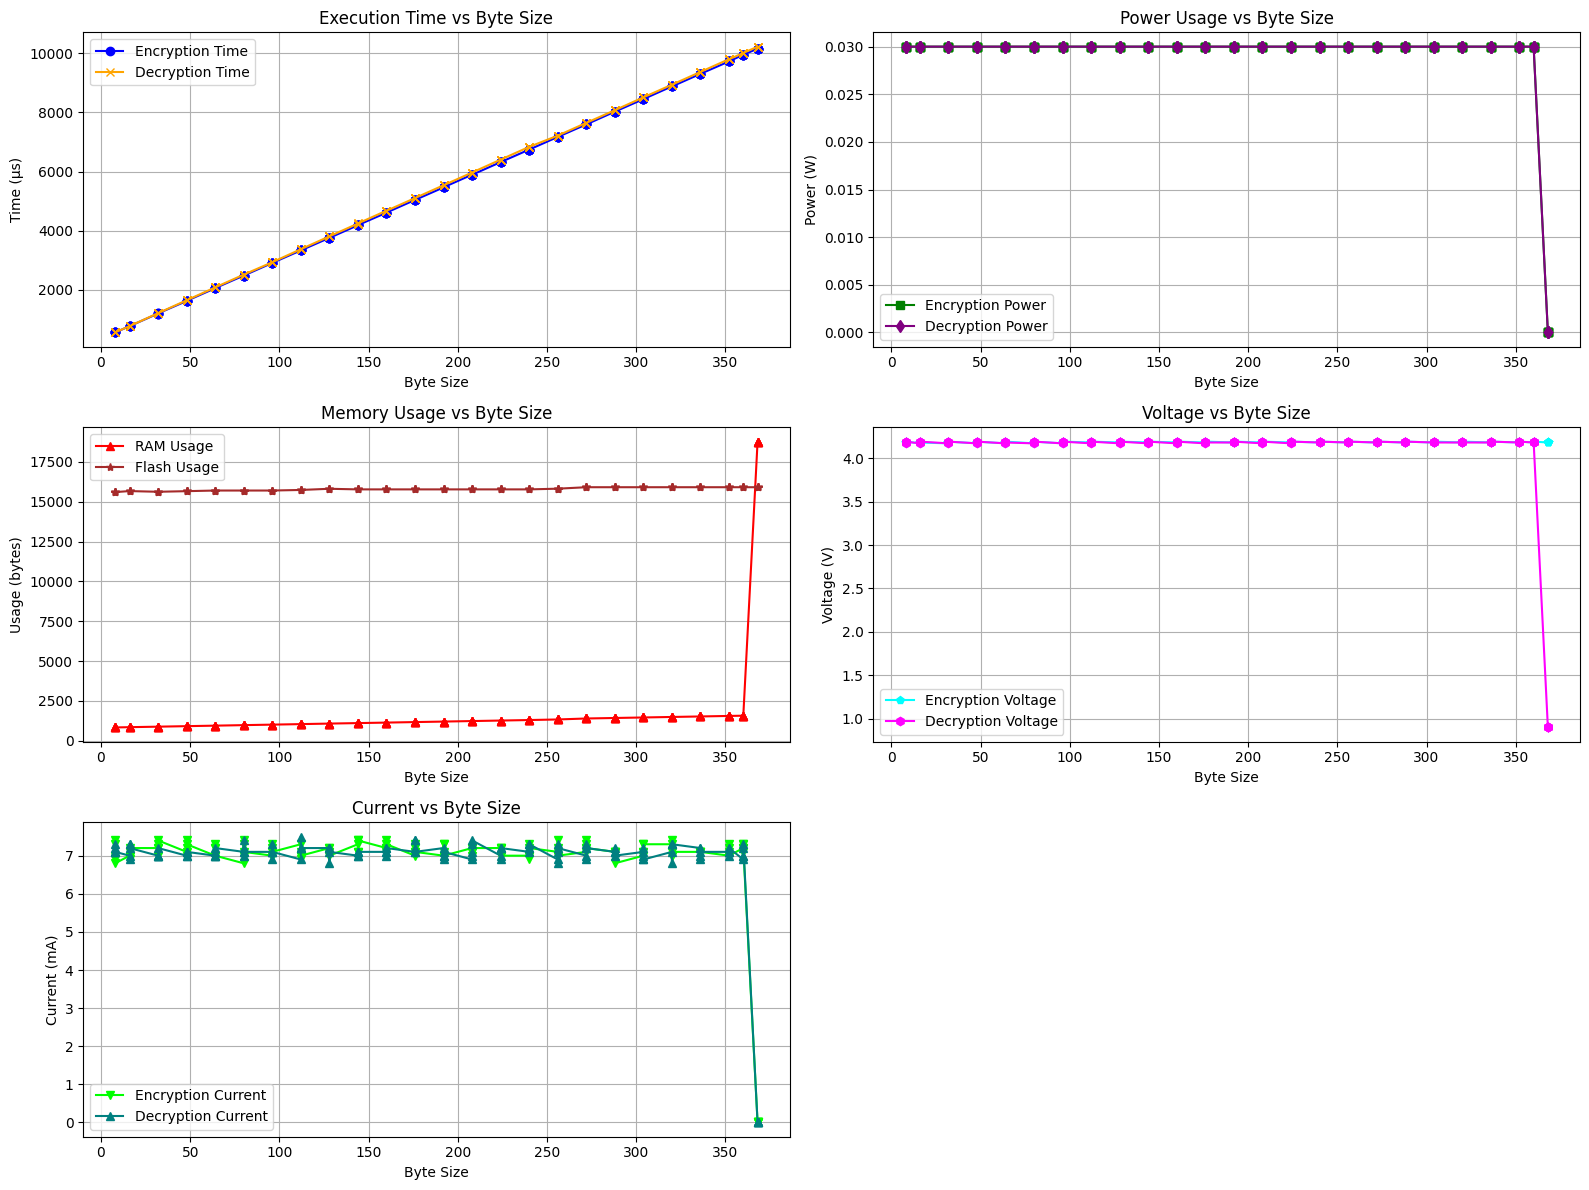

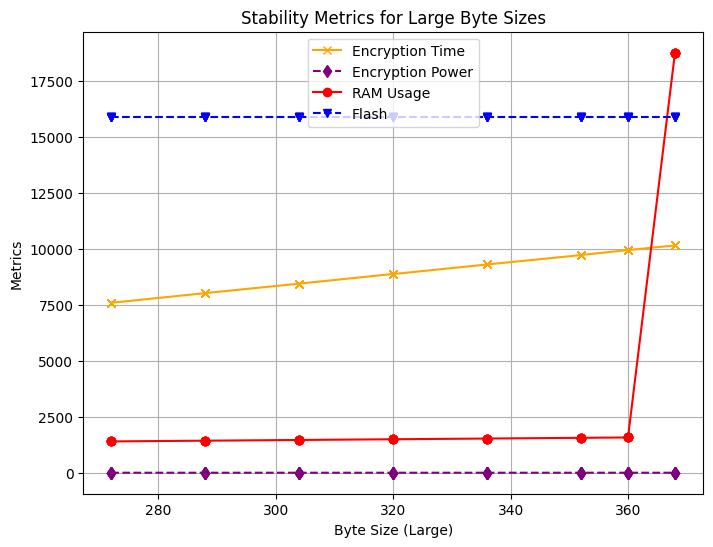

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kruskal

# Load the dataset
file_path = "nomean_skinny64128_data.xlsx"  # Replace with your file name
data = pd.read_excel(file_path)

# Display structure of dataset
print(data.head())

# Define columns
byte_sizes = data["Byte Size"]
flash_usages = data["Flash (bytes)"]
ram_usages = data["RAM (bytes)"]
encryption_times = data["Encryption Time (\u00b5s)"]
decryption_times = data["Decryption Time (\u00b5s)"]
encryption_voltages = data["Encryption Voltage (V)"]
encryption_currents = data["Encryption Current (mA)"]
encryption_powers = data["Encryption Power (W)"]
decryption_voltages = data["Decryption Voltage (V)"]
decryption_currents = data["Decryption Current (mA)"]
decryption_powers = data["Decryption Power (W)"]

# Define groups for Kruskal-Wallis based on byte size thresholds
threshold = byte_sizes.max() * 0.7  # Define "large" as the top 30% of byte sizes
group_large = data[data["Byte Size"] >= threshold]
group_small = data[data["Byte Size"] < threshold]

# Perform Kruskal-Wallis test for each performance metric
kruskal_results = {
    "Flash": kruskal(group_large["Flash (bytes)"], group_small["Flash (bytes)"]),
    "RAM": kruskal(group_large["RAM (bytes)"], group_small["RAM (bytes)"]),
    "Encryption Time": kruskal(group_large["Encryption Time (\u00b5s)"], group_small["Encryption Time (\u00b5s)"]),
    "Decryption Time": kruskal(group_large["Decryption Time (\u00b5s)"], group_small["Decryption Time (\u00b5s)"]),
    "Encryption Voltage": kruskal(group_large["Encryption Voltage (V)"], group_small["Encryption Voltage (V)"]),
    "Decryption Voltage": kruskal(group_large["Decryption Voltage (V)"], group_small["Decryption Voltage (V)"]),
    "Encryption Current": kruskal(group_large["Encryption Current (mA)"], group_small["Encryption Current (mA)"]),
    "Decryption Current": kruskal(group_large["Decryption Current (mA)"], group_small["Decryption Current (mA)"]),
    "Encryption Power": kruskal(group_large["Encryption Power (W)"], group_small["Encryption Power (W)"]),
    "Decryption Power": kruskal(group_large["Decryption Power (W)"], group_small["Decryption Power (W)"]),
}

print("Kruskal-Wallis Test Results:")
for metric, result in kruskal_results.items():
    print(f"{metric}: statistic={result.statistic:.3f}, p-value={result.pvalue:.3e}")

# Plot trends to visualize performance
plt.figure(figsize=(16, 12))

# Execution Time vs Byte Size
plt.subplot(3, 2, 1)
plt.plot(byte_sizes, encryption_times, marker='o', color='b', label="Encryption Time")
plt.plot(byte_sizes, decryption_times, marker='x', color='orange', label="Decryption Time")
plt.title("Execution Time vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Time (\u00b5s)")
plt.legend()
plt.grid(True)

# Power Usage vs Byte Size
plt.subplot(3, 2, 2)
plt.plot(byte_sizes, encryption_powers, marker='s', color='g', label="Encryption Power")
plt.plot(byte_sizes, decryption_powers, marker='d', color='purple', label="Decryption Power")
plt.title("Power Usage vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Power (W)")
plt.legend()
plt.grid(True)

# Memory Usage vs Byte Size
plt.subplot(3, 2, 3)
plt.plot(byte_sizes, ram_usages, marker='^', color='r', label="RAM Usage")
plt.plot(byte_sizes, flash_usages, marker='*', color='brown', label="Flash Usage")
plt.title("Memory Usage vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Usage (bytes)")
plt.legend()
plt.grid(True)

# Voltage vs Byte Size
plt.subplot(3, 2, 4)
plt.plot(byte_sizes, encryption_voltages, marker='p', color='cyan', label="Encryption Voltage")
plt.plot(byte_sizes, decryption_voltages, marker='h', color='magenta', label="Decryption Voltage")
plt.title("Voltage vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Voltage (V)")
plt.legend()
plt.grid(True)

# Current vs Byte Size
plt.subplot(3, 2, 5)
plt.plot(byte_sizes, encryption_currents, marker='v', color='lime', label="Encryption Current")
plt.plot(byte_sizes, decryption_currents, marker='^', color='teal', label="Decryption Current")
plt.title("Current vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Current (mA)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Stability Check for Large Data
plt.figure(figsize=(8, 6))
plt.plot(group_large["Byte Size"], group_large["Encryption Time (\u00b5s)"], marker='x', linestyle='-', color='orange', label="Encryption Time")
plt.plot(group_large["Byte Size"], group_large["Encryption Power (W)"], marker='d', linestyle='--', color='purple', label="Encryption Power")
plt.plot(group_large["Byte Size"], group_large["RAM (bytes)"], marker='o', linestyle='-', color='red', label="RAM Usage")
plt.plot(group_large["Byte Size"], group_large["Flash (bytes)"], marker='v', linestyle='--', color='blue', label="Flash")
plt.title("Stability Metrics for Large Byte Sizes")
plt.xlabel("Byte Size (Large)")
plt.ylabel("Metrics")
plt.grid(True)
plt.legend()
plt.show()


# SKINNY64192

Generate SKINNY64192

In [ ]:
import os

# Folder output utama
code_folders = ["skinny64192aa", "skinny64192bb", "skinny64192cc", "skinny64192dd", "skinny64192ee"]

# Buat folder utama jika belum ada
for folder in code_folders:
    os.makedirs(folder, exist_ok=True)

def generate_code_with_decrementing_plaintext(file_path, id_values):
    # Template kode Arduino
    code_template = f'''
#include <SPI.h>
#include <MFRC522.h>
#include <Wire.h>
#include <Adafruit_INA219.h>
#include "Skinny64.h"
#include <string.h>
#include <MemoryFree.h>
#include <LiquidCrystal_I2C.h> 

#define SS_PIN 10
#define RST_PIN 9

MFRC522 rfid(SS_PIN, RST_PIN);
Adafruit_INA219 ina219;
LiquidCrystal_I2C lcd(0x27, 16, 2);

Skinny64_192 skinny;
byte ciphertext[{id_values}];
byte decryptedtext[{id_values}];
unsigned long encryptionTime;
unsigned long decryptionTime;

byte buffer[8];

float encryptionVoltage;
float encryptionCurrent;
float decryptionVoltage;
float decryptionCurrent;

const byte key[24] = {{0x1f, 0x1e, 0x1d, 0x1c, 0x1b, 0x1a,  // 6 bytes
                             0x19, 0x18, 0x17, 0x16, 0x15, 0x14,  // 12 bytes
                            0x13, 0x12, 0x11, 0x10, 0x0f, 0x0e,  // 18 bytes
                            0x0d, 0x0c, 0x0b, 0x0a, 0x09, 0x08}};

void encryptAndMeasure(BlockCipher *cipher, const byte *key, size_t keySize, byte *plaintext, size_t plaintextSize) {{
  unsigned long startTime = micros();
  cipher->setKey(key, keySize);

  for (size_t i = 0; i < plaintextSize; i += 8) {{
    cipher->encryptBlock(buffer, &plaintext[i]);
    memcpy(&ciphertext[i], buffer, 8);
  }}

  unsigned long endTime = micros();
  encryptionVoltage = ina219.getBusVoltage_V();
  encryptionCurrent = ina219.getCurrent_mA();
  encryptionTime = endTime - startTime;

  // Output encrypted data (ciphertext)
  Serial.print(F("Ciphertext: "));
  for (size_t i = 0; i < plaintextSize; i++) {{
    if (ciphertext[i] < 0x10) Serial.print("0");
    Serial.print(ciphertext[i], HEX);
    Serial.print(" ");
  }}
  Serial.println();
  Serial.print(F("Encryption Completed in "));
  Serial.print(encryptionTime);
  Serial.println(F(" microseconds"));
}}

void decryptAndMeasure(BlockCipher *cipher, const byte *key, size_t keySize, byte *ciphertext, size_t ciphertextSize) {{
    unsigned long startdecTime = micros();
    cipher->setKey(key, keySize);

    for (size_t i = 0; i < ciphertextSize; i += 8) {{
        cipher->decryptBlock(buffer, &ciphertext[i]);
        memcpy(&decryptedtext[i], buffer, 8);
    }}

    unsigned long enddecTime = micros();
    decryptionVoltage = ina219.getBusVoltage_V();
    decryptionCurrent = ina219.getCurrent_mA();
    decryptionTime = enddecTime - startdecTime;

    // Output decrypted data
    Serial.print(F("Decrypted Text: "));
    for (size_t i = 0; i < ciphertextSize; i++) {{
        if (decryptedtext[i] < 0x10) Serial.print("0");
        Serial.print(decryptedtext[i], HEX);
        Serial.print(" ");
    }}
    Serial.println();
    Serial.print(F("Decryption Completed in "));
    Serial.print(decryptionTime);
    Serial.println(F(" microseconds"));
}}

void displayData() {{
    float encryptionPower = encryptionVoltage * (encryptionCurrent / 1000);
    float decryptionPower = decryptionVoltage * (decryptionCurrent / 1000);
    int memoryUsage = 2048 - freeMemory();

    Serial.print(F("Memory Usage = "));
    Serial.print(memoryUsage);
    Serial.println(F(" B"));

    Serial.print(F("Encryption Voltage: "));
    Serial.print(encryptionVoltage);
    Serial.println(F(" V"));
    Serial.print(F("Encryption Current: "));
    Serial.print(encryptionCurrent);
    Serial.println(F(" mA"));
    Serial.print(F("Encryption Power: "));
    Serial.print(encryptionPower);
    Serial.println(F(" W"));
    
    Serial.print(F("Decryption Voltage: "));
    Serial.print(decryptionVoltage);
    Serial.println(F(" V"));
    Serial.print(F("Decryption Current: "));
    Serial.print(decryptionCurrent);
    Serial.println(F(" mA"));
    Serial.print(F("Decryption Power: "));
    Serial.print(decryptionPower);
    Serial.println(F(" W"));

    Serial.println(F("selesai"));
}}

void setup() {{
    Serial.begin(9600);
    SPI.begin();
    rfid.PCD_Init();
    ina219.begin();
    
    lcd.begin(16, 2);
    lcd.backlight();
    lcd.setCursor(0, 0);
    lcd.print("RFID System Ready");
    delay(2000);
    lcd.clear();
}}

void loop() {{
    if (rfid.PICC_IsNewCardPresent() && rfid.PICC_ReadCardSerial()) {{
        byte cardID[{id_values}] = {{0}};
        size_t idLength = rfid.uid.size;

        for (byte i = 0; i < idLength && i < {id_values}; i++) {{
            cardID[i] = rfid.uid.uidByte[i];
        }}

        if (idLength < {id_values}) {{
            memset(&cardID[idLength], 0, {id_values} - idLength);
        }}

        lcd.clear();
        lcd.setCursor(0, 0);
        lcd.print("RFID Detected!");
        lcd.setCursor(0, 1);
        lcd.print("Encrypting...");

        encryptAndMeasure(&skinny, key, sizeof(key), cardID, {id_values});
        decryptAndMeasure(&skinny, key, sizeof(key), ciphertext, {id_values});
        displayData();

        lcd.clear();
        lcd.setCursor(0, 0);
        lcd.print("Encryption Done!");
        delay(2000);
        lcd.clear();
    }}
}}
'''

    with open(file_path, 'w') as file:
        file.write(code_template)

    print(f"Code with {id_values}-byte plaintext has been written to {file_path}")

# Generate folders and codes
for folder in code_folders:
    for i in range(384, 7, -8):
        filename = f"skinny64192_{i}"
        sketch_folder = os.path.join(folder, filename)
        os.makedirs(sketch_folder, exist_ok=True)  # Membuat folder untuk setiap file

        file_path = os.path.join(sketch_folder, f"{filename}.ino")

        generate_code_with_decrementing_plaintext(file_path, i)


Running SKINNY64192

In [ ]:
# Configuration
port = "COM8"
baud_rate = 9600
base_folders = ["skinny64192aa", "skinny64192bb", "skinny64192cc", "skinny64192dd", "skinny64192ee"]
log_folder = "logs_skinny64192_multi"
arduino_cli_path = r"C:\Program Files\Arduino IDE\resources\app\lib\backend\resources\arduino-cli.exe"

# Create log folder if it doesn't exist
os.makedirs(log_folder, exist_ok=True)

# Timeout duration in seconds for each phase
COMPILE_TIMEOUT = 60
UPLOAD_TIMEOUT = 30
SERIAL_TIMEOUT = 10


def parse_serial_data(serial_line):
    """
    Parse the serial data and return structured information.
    """
    if "Ciphertext" in serial_line:
        match = re.search(r"Ciphertext: (.+)", serial_line)
        return {"Ciphertext": match.group(1)} if match else None
    elif "Encryption Completed" in serial_line:
        match = re.search(r"Encryption Completed in (\d+) microseconds", serial_line)
        return {"Encryption Time": int(match.group(1))} if match else None
    elif "Decrypted Text" in serial_line:
        match = re.search(r"Decrypted Text: (.+)", serial_line)
        return {"Decrypted Text": match.group(1)} if match else None
    elif "Decryption Completed" in serial_line:
        match = re.search(r"Decryption Completed in (\d+) microseconds", serial_line)
        return {"Decryption Time": int(match.group(1))} if match else None
    elif "Memory Usage" in serial_line:
        match = re.search(r"Memory Usage = (\d+) B", serial_line)
        return {"Memory Usage (B)": int(match.group(1))} if match else None
    elif "Encryption Voltage" in serial_line:
        match = re.search(r"Encryption Voltage: ([\d.]+) V", serial_line)
        return {"Encryption Voltage (V)": float(match.group(1))} if match else None
    elif "Encryption Current" in serial_line:
        match = re.search(r"Encryption Current: ([\d.]+) mA", serial_line)
        return {"Encryption Current (mA)": float(match.group(1))} if match else None
    elif "Encryption Power" in serial_line:
        match = re.search(r"Encryption Power: ([\d.]+) W", serial_line)
        return {"Encryption Power (W)": float(match.group(1))} if match else None
    elif "Decryption Voltage" in serial_line:
        match = re.search(r"Decryption Voltage: ([\d.]+) V", serial_line)
        return {"Decryption Voltage (V)": float(match.group(1))} if match else None
    elif "Decryption Current" in serial_line:
        match = re.search(r"Decryption Current: ([\d.]+) mA", serial_line)
        return {"Decryption Current (mA)": float(match.group(1))} if match else None
    elif "Decryption Power" in serial_line:
        match = re.search(r"Decryption Power: ([\d.]+) W", serial_line)
        return {"Decryption Power (W)": float(match.group(1))} if match else None
    elif "selesai" in serial_line.lower():
        return {"Status": "Process Completed"}
    return {"Raw": serial_line.strip()}


def compile_and_upload(sketch_name, sketch_path):
    log_file = os.path.join(log_folder, f"{sketch_name}_output.txt")
    
    try:
        # Compile code to get storage information
        compile_command = [arduino_cli_path, "compile", "--fqbn", "arduino:avr:nano", sketch_path]
        result = subprocess.run(compile_command, capture_output=True, text=True, timeout=COMPILE_TIMEOUT)
        
        # Retrieve storage information from compilation output
        flash_match = re.search(r"Sketch uses (\d+) bytes.*Maximum is (\d+) bytes", result.stdout)
        ram_match = re.search(r"Global variables use (\d+) bytes.*Maximum is (\d+) bytes", result.stdout)
        flash_usage = f"{flash_match.group(1)} / {flash_match.group(2)} bytes" if flash_match else "Unknown"
        ram_usage = f"{ram_match.group(1)} / {ram_match.group(2)} bytes" if ram_match else "Unknown"

        print(f"{sketch_name} - Flash: {flash_usage}, RAM: {ram_usage}")

        # Log Flash and RAM info
        with open(log_file, "w", encoding="utf-8") as f:
            f.write(f"{sketch_name} - Flash: {flash_usage}, RAM: {ram_usage}\n\n")

        # Upload code to Arduino
        upload_command = [arduino_cli_path, "upload", "-p", port, "--fqbn", "arduino:avr:nano", sketch_path]
        subprocess.run(upload_command, timeout=UPLOAD_TIMEOUT)

        time.sleep(2)  # Wait after upload

    except subprocess.TimeoutExpired:
        print(f"Error: {sketch_name} - Compilation or upload timed out.")
    except Exception as e:
        print(f"Error: {sketch_name} - {e}")

    # Read from Serial Monitor and log to file
    try:
        with serial.Serial(port, baud_rate, timeout=1) as ser, open(log_file, "a", encoding="utf-8") as f:
            start_time = time.time()
            while time.time() - start_time < SERIAL_TIMEOUT:
                if ser.in_waiting > 0:
                    line = ser.readline().decode("utf-8", errors="ignore").strip()
                    parsed_line = parse_serial_data(line)
                    print(parsed_line)
                    f.write(str(parsed_line) + "\n")
                    if "Status" in parsed_line and parsed_line["Status"] == "Process Completed":
                        print(f"Detected completion for {sketch_name}.")
                        return
    except serial.SerialException as e:
        print(f"Serial Error: {sketch_name} - {e}")
    except Exception as e:
        print(f"Error while reading serial: {sketch_name} - {e}")


# Loop through each base folder
for base_folder in base_folders:
    subfolders = sorted(
        [folder for folder in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, folder))],
        key=lambda x: int(x.split('_')[1])  # Extract number after "128_" and sort numerically
    )

    for folder_name in subfolders:
        sketch_path = os.path.join(base_folder, folder_name, f"{folder_name}.ino")
        if os.path.isfile(sketch_path):
            print(f"Running {folder_name} in {base_folder}...")
            compile_and_upload(f"{base_folder}_{folder_name}", sketch_path)
            print(f"Completed {folder_name} in {base_folder}\n")
        else:
            print(f"File {folder_name}.ino not found in {folder_name} within {base_folder}")


CSV192

In [15]:
import ast  # Import untuk evaluasi literal
import pandas as pd
from glob import glob

# Konfigurasi
log_folder = "logs_skinny64192_multi"
output_csv = "nomean_skinny64192_data.csv"

# Ukuran byte yang sesuai dengan file log
byte_sizes = [8, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256, 272, 288, 304, 320, 336, 352, 360]

# List untuk menyimpan data hasil pemrosesan
data_list = []

# Proses setiap ukuran byte
for byte_size in byte_sizes:
    files = glob(f"{log_folder}/*_{byte_size}_output*")
    if not files:
        print(f"No log files found for byte size: {byte_size}")
        continue

    print(f"Processing byte size: {byte_size}...")

    for file in files:
        try:
            flash_value = ram_value = encryption_time = decryption_time = None
            encryption_voltage = encryption_current = encryption_power = None
            decryption_voltage = decryption_current = decryption_power = None

            with open(file, 'r') as f:
                for line in f:
                    line = line.strip()

                    if "Flash:" in line:
                        try:
                            flash_value = int(line.split("Flash:")[1].split('/')[0].strip())
                        except Exception as e:
                            print(f"Error parsing Flash in line: {line} - {e}")

                    elif "'Encryption Time" in line:
                        try:
                            data = ast.literal_eval(line)
                            if "Encryption Time" in data:
                                encryption_time = int(data["Encryption Time"])
                        except Exception as e:
                            print(f"Error parsing Encryption Time in line: {line} - {e}")

                    elif "'Decryption Time':" in line:
                        try:
                            data = ast.literal_eval(line)
                            if "Decryption Time" in data:
                                decryption_time = int(data["Decryption Time"])
                        except Exception as e:
                            print(f"Error parsing Decryption Time in line: {line} - {e}")

                    elif "Memory Usage:" in line or "Memory Usage (B)" in line:
                        try:
                            data = ast.literal_eval(line)
                            if "Memory Usage (B)" in data:
                                ram_value = int(data["Memory Usage (B)"])
                        except Exception as e:
                            print(f"Error parsing RAM in line: {line} - {e}")

                    elif "Voltage" in line or "Current" in line or "Power" in line:
                        try:
                            data = ast.literal_eval(line)
                            if "Encryption Voltage (V)" in data:
                                encryption_voltage = float(data["Encryption Voltage (V)"])
                            if "Encryption Current (mA)" in data:
                                encryption_current = float(data["Encryption Current (mA)"])
                            if "Encryption Power (W)" in data:
                                encryption_power = float(data["Encryption Power (W)"])
                            if "Decryption Voltage (V)" in data:
                                decryption_voltage = float(data["Decryption Voltage (V)"])
                            if "Decryption Current (mA)" in data:
                                decryption_current = float(data["Decryption Current (mA)"])
                            if "Decryption Power (W)" in data:
                                decryption_power = float(data["Decryption Power (W)"])
                        except Exception as e:
                            print(f"Error parsing Voltage/Current/Power in line: {line} - {e}")

            # Tambahkan data ke list
            data_list.append({
                "Byte Size": byte_size,
                "File Name": file,
                "Flash (bytes)": flash_value,
                "RAM (bytes)": ram_value,
                "Encryption Time (µs)": encryption_time,
                "Decryption Time (µs)": decryption_time,
                "Encryption Voltage (V)": encryption_voltage,
                "Encryption Current (mA)": encryption_current,
                "Encryption Power (W)": encryption_power,
                "Decryption Voltage (V)": decryption_voltage,
                "Decryption Current (mA)": decryption_current,
                "Decryption Power (W)": decryption_power,
            })

        except Exception as e:
            print(f"Error reading file {file}: {e}")

# Simpan data ke CSV
df = pd.DataFrame(data_list)
df.to_csv(output_csv, index=False)

# Tampilkan beberapa data
print(df.head())


Processing byte size: 8...
Processing byte size: 16...
Processing byte size: 32...
Processing byte size: 48...
Processing byte size: 64...
Processing byte size: 80...
Processing byte size: 96...
Processing byte size: 112...
Processing byte size: 128...
Processing byte size: 144...
Processing byte size: 160...
Processing byte size: 176...
Processing byte size: 192...
Processing byte size: 208...
Processing byte size: 224...
Processing byte size: 240...
Processing byte size: 256...
Processing byte size: 272...
Processing byte size: 288...
Processing byte size: 304...
Processing byte size: 320...
Processing byte size: 336...
Processing byte size: 352...
Processing byte size: 360...
   Byte Size                                          File Name  \
0          8  logs_skinny64192_multi\skinny64192a_skinny6419...   
1          8  logs_skinny64192_multi\skinny64192b_skinny6419...   
2          8  logs_skinny64192_multi\skinny64192c_skinny6419...   
3          8  logs_skinny64192_multi\skinny6

OUTPUT

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Membaca data dari CSV (sesuaikan path jika diperlukan)
file_path = 'processed_skinny64192_data.csv'
data = pd.read_csv(file_path)

# Grafik 1: Byte Size vs Encryption Time
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Encryption Time (µs)'], marker='o', label='Encryption Time (µs)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Encryption Time (µs)')
plt.title('Byte Size vs Encryption Time')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 2: Byte Size vs Decryption Time
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Decryption Time (µs)'], marker='o', label='Decryption Time (µs)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Decryption Time (µs)')
plt.title('Byte Size vs Decryption Time')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 3: Byte Size vs Encryption & Decryption Time
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Encryption Time (µs)'], marker='o', label='Encryption Time (µs)')
plt.plot(data['Byte Size'], data['Avg Decryption Time (µs)'], marker='o', label='Decryption Time (µs)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Time (µs)')
plt.title('Byte Size vs Encryption & Decryption Time')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 4: Byte Size vs Flash
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Flash (bytes)'], marker='o', label='Flash (bytes)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Flash (bytes)')
plt.title('Byte Size vs Flash')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 5: Byte Size vs RAM
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg RAM (bytes)'], marker='o', label='RAM (bytes)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('RAM (bytes)')
plt.title('Byte Size vs RAM')
plt.grid(True)
plt.legend()
plt.show()

# # Grafik 6: Byte Size vs Encryption Voltage
# plt.figure(figsize=(8, 6))
# plt.plot(data['Byte Size'], data['Avg Encryption Voltage (V)'], marker='o', label='Encryption Voltage (V)')
# plt.xlabel('Byte Size (bytes)')
# plt.ylabel('Voltage (V)')
# plt.title('Byte Size vs Encryption Voltage')
# plt.grid(True)
# plt.legend()
# plt.show()

# # Grafik 7: Byte Size vs Encryption Current
# plt.figure(figsize=(8, 6))
# plt.plot(data['Byte Size'], data['Avg Encryption Current (A)'], marker='o', label='Encryption Current (A)')
# plt.xlabel('Byte Size (bytes)')
# plt.ylabel('Current (A)')
# plt.title('Byte Size vs Encryption Current')
# plt.grid(True)
# plt.legend()
# plt.show()

# # Grafik 8: Byte Size vs Encryption Power
# plt.figure(figsize=(8, 6))
# plt.plot(data['Byte Size'], data['Avg Encryption Power (W)'], marker='o', label='Encryption Power (W)')
# plt.xlabel('Byte Size (bytes)')
# plt.ylabel('Power (W)')
# plt.title('Byte Size vs Encryption Power')
# plt.grid(True)
# plt.legend()
# plt.show()

# Grafik 9: Byte Size vs Encryption Voltage dan Decryption Voltage
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Encryption Voltage (V)'], marker='o', label='Encryption Voltage (V)')
plt.plot(data['Byte Size'], data['Avg Decryption Voltage (V)'], marker='h', label='Decryption Voltage (V)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Voltage (V)')
plt.title('Byte Size vs Encryption Voltage & Decryption Voltage')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 10: Byte Size vs Encryption Current dan Duplicate Current
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Encryption Current (mA)'], marker='o', label='Encryption Current (mA)')
plt.plot(data['Byte Size'], data['Avg Decryption Current (mA)'], marker='h', label='Decryption Current (mA)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Current (A)')
plt.title('Byte Size vs Encryption Current & Decryption Current')
plt.grid(True)
plt.legend()
plt.show()

# Grafik 11: Byte Size vs Encryption Power dan Duplicate Power
plt.figure(figsize=(8, 6))
plt.plot(data['Byte Size'], data['Avg Encryption Power (W)'], marker='o', label='Encryption Power (W)')
plt.plot(data['Byte Size'], data['Avg Decryption Power (W)'], marker='h', label='Decryption Power (W)')
plt.xlabel('Byte Size (bytes)')
plt.ylabel('Power (W)')
plt.title('Byte Size vs Encryption Power & Decryption Power')
plt.grid(True)
plt.legend()
plt.show()


KW

RM2

In [6]:

# Load dataset
file_path = "nomean_skinny64192_data.xlsx"  # Replace with your file path
data = pd.read_excel(file_path)

# Display the structure of the dataset
print(data.head())

# Define columns for analysis
byte_sizes = data["Byte Size"].unique()  # Unique byte sizes

# Group data by byte size for Kruskal-Wallis analysis
grouped_flash_usages = [data[data["Byte Size"] == b]["Flash (bytes)"].dropna() for b in byte_sizes]
grouped_ram_usages = [data[data["Byte Size"] == b]["RAM (bytes)"].dropna() for b in byte_sizes]
grouped_encryption_times = [data[data["Byte Size"] == b]["Encryption Time (µs)"].dropna() for b in byte_sizes]
grouped_decryption_times = [data[data["Byte Size"] == b]["Decryption Time (µs)"].dropna() for b in byte_sizes]
grouped_encryption_powers = [data[data["Byte Size"] == b]["Encryption Power (W)"].dropna() for b in byte_sizes]
grouped_decryption_powers = [data[data["Byte Size"] == b]["Decryption Power (W)"].dropna() for b in byte_sizes]

# Perform Kruskal-Wallis test for each metric
kw_flash_usage = kruskal(*grouped_flash_usages)
kw_ram_usage = kruskal(*grouped_ram_usages)
kw_encryption_time = kruskal(*grouped_encryption_times)
kw_decryption_time = kruskal(*grouped_decryption_times)
kw_encryption_power = kruskal(*grouped_encryption_powers)
kw_decryption_power = kruskal(*grouped_decryption_powers)

# Display results
print("Kruskal-Wallis Test Results:")
print(f"Flash Usage: H-statistic = {kw_flash_usage.statistic}, p-value = {kw_flash_usage.pvalue}")
print(f"RAM Usage: H-statistic = {kw_ram_usage.statistic}, p-value = {kw_ram_usage.pvalue}")
print(f"Encryption Time: H-statistic = {kw_encryption_time.statistic}, p-value = {kw_encryption_time.pvalue}")
print(f"Decryption Time: H-statistic = {kw_decryption_time.statistic}, p-value = {kw_decryption_time.pvalue}")
print(f"Encryption Power: H-statistic = {kw_encryption_power.statistic}, p-value = {kw_encryption_power.pvalue}")
print(f"Decryption Power: H-statistic = {kw_decryption_power.statistic}, p-value = {kw_decryption_power.pvalue}")

# Interpretation
if kw_flash_usage.pvalue < 0.05:
    print("Significant difference found in Flash Usage across byte sizes.")
else:
    print("No significant difference in Flash Usage across byte sizes.")

if kw_ram_usage.pvalue < 0.05:
    print("Significant difference found in RAM Usage across byte sizes.")
else:
    print("No significant difference in RAM Usage across byte sizes.")

if kw_encryption_time.pvalue < 0.05:
    print("Significant difference found in Encryption Time across byte sizes.")
else:
    print("No significant difference in Encryption Time across byte sizes.")

if kw_decryption_time.pvalue < 0.05:
    print("Significant difference found in Decryption Time across byte sizes.")
else:
    print("No significant difference in Decryption Time across byte sizes.")

if kw_encryption_power.pvalue < 0.05:
    print("Significant difference found in Encryption Power across byte sizes.")
else:
    print("No significant difference in Encryption Power across byte sizes.")

if kw_decryption_power.pvalue < 0.05:
    print("Significant difference found in Decryption Power across byte sizes.")
else:
    print("No significant difference in Decryption Power across byte sizes.")


   Byte Size                                          File Name  \
0          8  logs_skinny64192_multi\skinny64192a_skinny6419...   
1          8  logs_skinny64192_multi\skinny64192b_skinny6419...   
2          8  logs_skinny64192_multi\skinny64192c_skinny6419...   
3          8  logs_skinny64192_multi\skinny64192d_skinny6419...   
4          8  logs_skinny64192_multi\skinny64192e_skinny6419...   

   Flash (bytes)  RAM (bytes)  Encryption Time (µs)  Decryption Time (µs)  \
0          15692          863                   820                   824   
1          15692          863                   820                   824   
2          15692          863                   820                   824   
3          15692          863                   820                   824   
4          15692          863                   820                   824   

   Encryption Voltage (V)  Encryption Current (mA)  Encryption Power (W)  \
0                    4.19                      7.0        

rm3

   Byte Size                                          File Name  \
0          8  logs_skinny64192_multi\skinny64192a_skinny6419...   
1          8  logs_skinny64192_multi\skinny64192b_skinny6419...   
2          8  logs_skinny64192_multi\skinny64192c_skinny6419...   
3          8  logs_skinny64192_multi\skinny64192d_skinny6419...   
4          8  logs_skinny64192_multi\skinny64192e_skinny6419...   

   Flash (bytes)  RAM (bytes)  Encryption Time (µs)  Decryption Time (µs)  \
0          15692          863                   820                   824   
1          15692          863                   820                   824   
2          15692          863                   820                   824   
3          15692          863                   820                   824   
4          15692          863                   820                   824   

   Encryption Voltage (V)  Encryption Current (mA)  Encryption Power (W)  \
0                    4.19                      7.0        

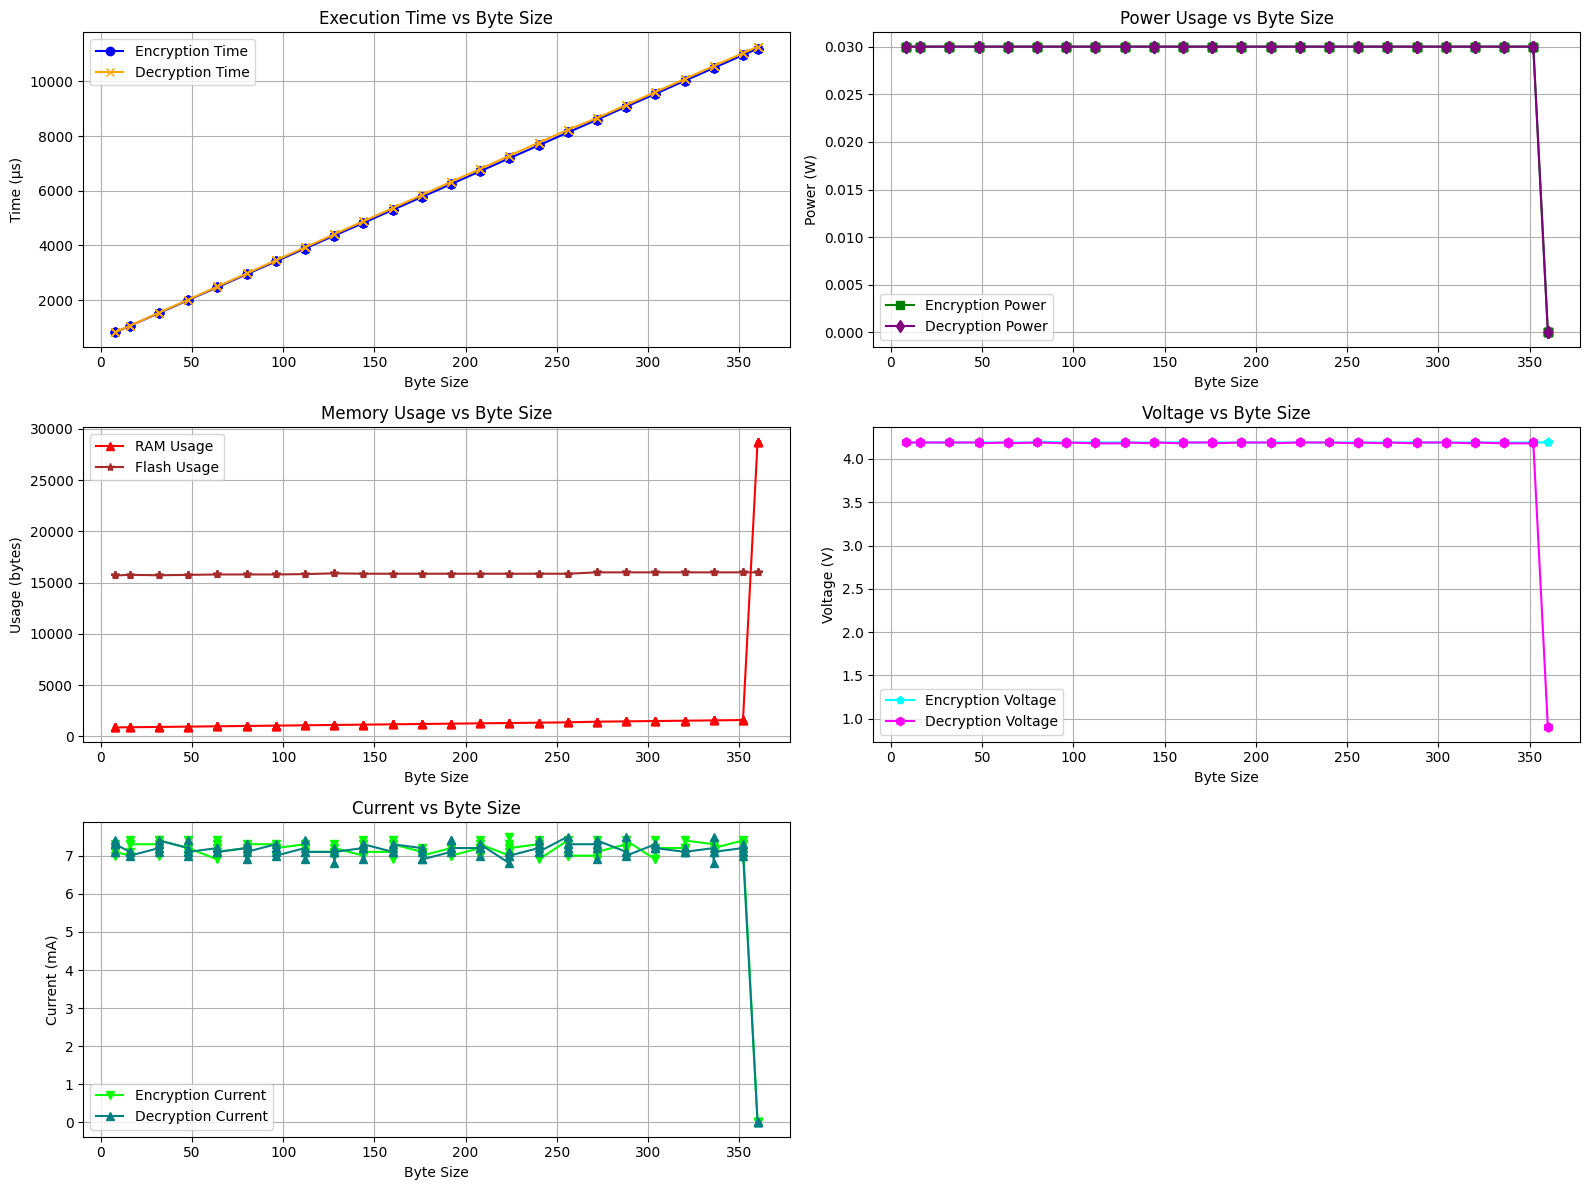

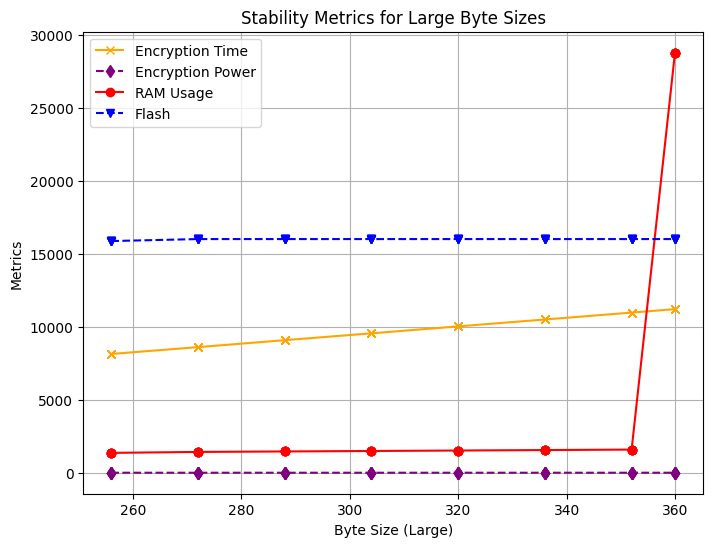

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kruskal

# Load the dataset
file_path = "nomean_skinny64192_data.xlsx"  # Replace with your file name
data = pd.read_excel(file_path)

# Display structure of dataset
print(data.head())

# Define columns
byte_sizes = data["Byte Size"]
flash_usages = data["Flash (bytes)"]
ram_usages = data["RAM (bytes)"]
encryption_times = data["Encryption Time (\u00b5s)"]
decryption_times = data["Decryption Time (\u00b5s)"]
encryption_voltages = data["Encryption Voltage (V)"]
encryption_currents = data["Encryption Current (mA)"]
encryption_powers = data["Encryption Power (W)"]
decryption_voltages = data["Decryption Voltage (V)"]
decryption_currents = data["Decryption Current (mA)"]
decryption_powers = data["Decryption Power (W)"]

# Define groups for Kruskal-Wallis based on byte size thresholds
threshold = byte_sizes.max() * 0.7  # Define "large" as the top 30% of byte sizes
group_large = data[data["Byte Size"] >= threshold]
group_small = data[data["Byte Size"] < threshold]

# Perform Kruskal-Wallis test for each performance metric
kruskal_results = {
    "Flash": kruskal(group_large["Flash (bytes)"], group_small["Flash (bytes)"]),
    "RAM": kruskal(group_large["RAM (bytes)"], group_small["RAM (bytes)"]),
    "Encryption Time": kruskal(group_large["Encryption Time (\u00b5s)"], group_small["Encryption Time (\u00b5s)"]),
    "Decryption Time": kruskal(group_large["Decryption Time (\u00b5s)"], group_small["Decryption Time (\u00b5s)"]),
    "Encryption Voltage": kruskal(group_large["Encryption Voltage (V)"], group_small["Encryption Voltage (V)"]),
    "Decryption Voltage": kruskal(group_large["Decryption Voltage (V)"], group_small["Decryption Voltage (V)"]),
    "Encryption Current": kruskal(group_large["Encryption Current (mA)"], group_small["Encryption Current (mA)"]),
    "Decryption Current": kruskal(group_large["Decryption Current (mA)"], group_small["Decryption Current (mA)"]),
    "Encryption Power": kruskal(group_large["Encryption Power (W)"], group_small["Encryption Power (W)"]),
    "Decryption Power": kruskal(group_large["Decryption Power (W)"], group_small["Decryption Power (W)"]),
}

print("Kruskal-Wallis Test Results:")
for metric, result in kruskal_results.items():
    print(f"{metric}: statistic={result.statistic:.3f}, p-value={result.pvalue:.3e}")

# Plot trends to visualize performance
plt.figure(figsize=(16, 12))

# Execution Time vs Byte Size
plt.subplot(3, 2, 1)
plt.plot(byte_sizes, encryption_times, marker='o', color='b', label="Encryption Time")
plt.plot(byte_sizes, decryption_times, marker='x', color='orange', label="Decryption Time")
plt.title("Execution Time vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Time (\u00b5s)")
plt.legend()
plt.grid(True)

# Power Usage vs Byte Size
plt.subplot(3, 2, 2)
plt.plot(byte_sizes, encryption_powers, marker='s', color='g', label="Encryption Power")
plt.plot(byte_sizes, decryption_powers, marker='d', color='purple', label="Decryption Power")
plt.title("Power Usage vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Power (W)")
plt.legend()
plt.grid(True)

# Memory Usage vs Byte Size
plt.subplot(3, 2, 3)
plt.plot(byte_sizes, ram_usages, marker='^', color='r', label="RAM Usage")
plt.plot(byte_sizes, flash_usages, marker='*', color='brown', label="Flash Usage")
plt.title("Memory Usage vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Usage (bytes)")
plt.legend()
plt.grid(True)

# Voltage vs Byte Size
plt.subplot(3, 2, 4)
plt.plot(byte_sizes, encryption_voltages, marker='p', color='cyan', label="Encryption Voltage")
plt.plot(byte_sizes, decryption_voltages, marker='h', color='magenta', label="Decryption Voltage")
plt.title("Voltage vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Voltage (V)")
plt.legend()
plt.grid(True)

# Current vs Byte Size
plt.subplot(3, 2, 5)
plt.plot(byte_sizes, encryption_currents, marker='v', color='lime', label="Encryption Current")
plt.plot(byte_sizes, decryption_currents, marker='^', color='teal', label="Decryption Current")
plt.title("Current vs Byte Size")
plt.xlabel("Byte Size")
plt.ylabel("Current (mA)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Stability Check for Large Data
plt.figure(figsize=(8, 6))
plt.plot(group_large["Byte Size"], group_large["Encryption Time (\u00b5s)"], marker='x', linestyle='-', color='orange', label="Encryption Time")
plt.plot(group_large["Byte Size"], group_large["Encryption Power (W)"], marker='d', linestyle='--', color='purple', label="Encryption Power")
plt.plot(group_large["Byte Size"], group_large["RAM (bytes)"], marker='o', linestyle='-', color='red', label="RAM Usage")
plt.plot(group_large["Byte Size"], group_large["Flash (bytes)"], marker='v', linestyle='--', color='blue', label="Flash")
plt.title("Stability Metrics for Large Byte Sizes")
plt.xlabel("Byte Size (Large)")
plt.ylabel("Metrics")
plt.grid(True)
plt.legend()
plt.show()


# Test Keamanan

In [ ]:
import re

# Baca file
file_path = 'testaman.txt'
with open(file_path, 'r') as file:
    data = file.read()

# Ekstrak ciphertext
ciphertexts = re.findall(r"'Ciphertext': '([^']+)'", data)

# Ubah ciphertext ke dalam bentuk byte
def hex_to_bytes(hex_string):
    return bytes.fromhex(hex_string.replace(" ", ""))

byte_ciphertexts = [hex_to_bytes(ct) for ct in ciphertexts]

# Analisis distribusi byte
def analyze_byte_distribution(ciphertexts):
    from collections import Counter
    byte_freq = Counter()
    for ct in ciphertexts:
        byte_freq.update(ct)
    return byte_freq

byte_distribution = analyze_byte_distribution(byte_ciphertexts)

# Tampilkan hasil distribusi byte
print("Distribusi Byte:")
for byte, freq in byte_distribution.items():
    print(f"Byte: {byte:02X}, Frequency: {freq}")


In [ ]:
from itertools import product
from skinny import SkinnyCipher
import re
import string

# Fungsi untuk membaca file dan ekstrak ciphertext
def extract_ciphertexts(file_path):
    with open(file_path, 'r') as file:
        data = file.read()
    # Cari semua ciphertext di file
    ciphertext_matches = re.findall(r"'Ciphertext': '([^']+)'", data)
    # Ubah dari heksadesimal ke byte array
    ciphertexts = [bytes.fromhex(ct.replace(" ", "")) for ct in ciphertext_matches]
    return ciphertexts

# Fungsi untuk mengonversi byte array ke integer
def bytes_to_int(byte_data):
    return int.from_bytes(byte_data, byteorder='big')

# Fungsi dekripsi menggunakan SkinnyCipher
def decrypt_with_key_skinny(ciphertext, key, key_size=128, block_size=128):
    try:
        cipher = SkinnyCipher(key, key_size, block_size)
        return cipher.decrypt(ciphertext)
    except Exception:
        return None

# Brute force kunci untuk semua ciphertext
def brute_force_decrypt_skinny(ciphertexts):
    possible_characters = string.printable.encode()  # ASCII karakter yang mungkin
    key_size = 16  # Panjang kunci dalam byte (16 byte = 128 bit)

    for key_bytes in product(possible_characters, repeat=key_size):
        key = int.from_bytes(bytes(key_bytes), byteorder='big')
        plaintexts = []
        success = True
        for ciphertext in ciphertexts:
            plaintext = decrypt_with_key_skinny(ciphertext, key)
            if plaintext is None or not b' ' in plaintext.to_bytes((plaintext.bit_length() + 7) // 8, 'big'):
                success = False
                break
            plaintexts.append(plaintext)
        if success:
            return key, plaintexts
    return None, None

# Jalankan seluruh proses
def main():
    # File input (ganti dengan path file Anda)
    file_path = 'testaman.txt'
    
    # Ekstraksi ciphertext
    ciphertexts = extract_ciphertexts(file_path)
    ciphertexts_int = [bytes_to_int(ct) for ct in ciphertexts]  # Konversi ke integer

    # Jalankan brute force
    key_found, plaintexts_found = brute_force_decrypt_skinny(ciphertexts_int)

    # Tampilkan hasil
    if key_found:
        print("Kunci ditemukan:", key_found)
        for idx, plaintext in enumerate(plaintexts_found):
            decoded_plaintext = plaintext.to_bytes((plaintext.bit_length() + 7) // 8, 'big')
            print(f"Plaintext {idx + 1}:", decoded_plaintext)
    else:
        print("Kunci tidak ditemukan.")

# Eksekusi program utama
if __name__ == "__main__":
    main()


In [14]:
from itertools import product
from skinny import SkinnyCipher
import string

# Fungsi dekripsi menggunakan SkinnyCipher
def decrypt_with_key_skinny(ciphertext, key, key_size=128, block_size=128):
    try:
        # Konversi kunci dari bytes ke integer
        if isinstance(key, bytes):
            key = int.from_bytes(key, byteorder='big')

        # Konversi ciphertext dari bytes ke integer
        if isinstance(ciphertext, bytes):
            ciphertext = int.from_bytes(ciphertext, byteorder='big')

        cipher = SkinnyCipher(key, key_size, block_size)
        return cipher.decrypt(ciphertext)
    except Exception as e:
        print(f"Error during decryption: {e}")
        return None



# Fungsi brute force kunci
def brute_force_decrypt_skinny(ciphertexts):
    possible_characters = list(range(0x00, 0x10))  # Byte range (0x00 - 0x0F untuk simulasi)
    key_size = 16  # Panjang kunci dalam byte (16 byte = 128 bit)

    for key_bytes in product(possible_characters, repeat=key_size):
        key = bytes(key_bytes)  # Konversi ke array byte
        decrypted_ciphertexts = []
        success = True
        for ciphertext in ciphertexts:
            decrypted = decrypt_with_key_skinny(ciphertext, key)
            if decrypted is None:
                success = False
                break
            decrypted_ciphertexts.append(decrypted)
        if success:
            return key, decrypted_ciphertexts
    return None, None

# Konversi ciphertext dari hexadecimal ke byte
def extract_ciphertexts(file_path):
    with open(file_path, 'r') as f:
        data = f.readlines()
    ciphertexts = []
    for line in data:
        if "Ciphertext" in line:
            # Ambil bagian setelah "Ciphertext: " dan hapus karakter tidak diperlukan
            hex_str = line.split(': ')[1].strip().replace(' ', '').replace("'", "").replace("{", "").replace("}", "")
            try:
                # Konversi ke bytes
                ciphertexts.append(bytes.fromhex(hex_str))
            except ValueError:
                print(f"Error: Format hexadecimal tidak valid pada line: {line}")
                continue  # Abaikan line dengan format yang salah
    return ciphertexts



# Jalankan brute force
def main():
    # File input (ganti dengan path file Anda)
    file_path = 'testaman.txt'
    
    # Ekstraksi ciphertext
    ciphertexts = extract_ciphertexts(file_path)

    # Jalankan brute force
    key_found, decrypted_ciphertexts = brute_force_decrypt_skinny(ciphertexts)

    # Tampilkan hasil
    if key_found:
        print("Kunci ditemukan (dalam format array byte):", list(key_found))
        for idx, decrypted in enumerate(decrypted_ciphertexts):
            print(f"Decrypted Ciphertext {idx + 1}:", decrypted)
    else:
        print("Kunci tidak ditemukan.")

# Eksekusi program utama
if __name__ == "__main__":
    main()


Kunci ditemukan (dalam format array byte): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decrypted Ciphertext 1: 312228313820217339211055330889614900152
Decrypted Ciphertext 2: 22764130654606766803309015492597614388
Decrypted Ciphertext 3: 22764130654606766803309015492597614388
Decrypted Ciphertext 4: 22764130654606766803309015492597614388
Decrypted Ciphertext 5: 22764130654606766803309015492597614388
Decrypted Ciphertext 6: 22764130654606766803309015492597614388
Decrypted Ciphertext 7: 22764130654606766803309015492597614388
Decrypted Ciphertext 8: 22764130654606766803309015492597614388
Decrypted Ciphertext 9: 22764130654606766803309015492597614388
Decrypted Ciphertext 10: 22764130654606766803309015492597614388
Decrypted Ciphertext 11: 22764130654606766803309015492597614388
Decrypted Ciphertext 12: 22764130654606766803309015492597614388
Decrypted Ciphertext 13: 22764130654606766803309015492597614388
Decrypted Ciphertext 14: 22764130654606766803309015492597614388
Decrypted Ciphertext